# Translator using Transformer

__To-do__
  - Add a metric for translator
  - Try another loss function
  - different seq_len for input and output

__Done__
  - Batch size adjustment
  - Train-validation set split
  - Fix the code errata
  - Hyperparameter adjustment
  - Drop-out and training option setting

In [1]:
import numpy as np
import tensorflow as tf

import re
import os
import io
import time
import random

print(tf.__version__)

2.6.0


In [2]:
import seaborn # Attention 시각화를 위해 필요!
import matplotlib.pyplot as plt
import matplotlib as mpl
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [3]:
import sentencepiece as spm

In [4]:
data_dir = os.getenv('HOME')+'/aiffel/transformer_revisited/data'
corp_dir = os.getenv('HOME')+"/aiffel/seq2seq_gd"
kor_path = corp_dir+"/korean-english-park.train.ko"
eng_path = corp_dir+"/korean-english-park.train.en"

In [5]:
# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    kor_eng_pairs = set(kor_eng for kor_eng in zip(kor, eng))
    print("kor_eng_pairs: ", len(kor_eng_pairs))
    
    return kor_eng_pairs

kor_eng_pairs = clean_corpus(kor_path, eng_path)

kor_eng_pairs:  78968


In [6]:
def preprocess_sentence(sentence, lang='eng', s_token=False, e_token=False):
    
    # 모든 입력을 소문자로 변환; 알파벳, 문장부호, 한글만 남기고 모두 제거
    sentence = re.sub(r"[^a-zA-Z가-힣ㄱ-ㅎㅏ-ㅣ\?.!,]+", " ", sentence.lower())
        
    sentence = sentence.strip()

    # 문장부호 양옆에 공백을 추가합니다
    sentence = re.sub(r"([\?.!,])", r" \1 ", sentence)
    
    # 문장 앞뒤의 불필요한 공백을 제거합니다
    sentence = sentence.strip()
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    ''' # spm은 필요 없는 코드
    if s_token:
        sentence = '<s> ' + sentence

    if e_token:
        sentence += ' </s>'
    # '''
    return sentence

In [7]:
preprocess_sentence('where is my coffee?')

'where is my coffee ?'

In [8]:
enc_corpus = []
dec_corpus = []

# num_examples = 30000

for pair in kor_eng_pairs:
    kor, eng = pair
    enc_corpus.append(preprocess_sentence(kor, lang='kor',))
    dec_corpus.append(preprocess_sentence(eng, s_token=True, e_token=True))

In [9]:
enc_corpus[:5]

['insurgent 폭도 , 반정부운동가',
 '지난주 그는 골든 게이트 다리 밑 코테 마데라 해안으로 돌아왔다 .',
 '이라크 북부 아르빌에 , 명의 파병군을 둔 우리 정부는 이슬람 테러리스트 단체의 반복적인 경고에 경계를 강화하고 있다 . 삼가다 , 억누르다 이슬람의',
 '이렇게 하면 수업시간에 문자 메시지를 보내기가 편하다 .',
 '미 경찰 당국은 키드록이 이날 미 조지아주 애틀랜타 태버너클에서 공연을 마친 후 와플하우스 레스토랑으로 향했다고 주장했다 .']

In [10]:
len(enc_corpus)

78968

In [11]:
i = 0; print(enc_corpus[i], '\n', dec_corpus[i])

insurgent 폭도 , 반정부운동가 
 taliban insurgents in afghanistan freed the two women and took them to the red cross .


In [12]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    temp_file = data_dir+'/kor-eng-park.train.{}.temp'.format(lang)
    
    with open(temp_file, 'w') as f:
        for row in corpus:   
            f.write(str(row) + '\n')

    spm.SentencePieceTrainer.Train(
        '--input={} --model_prefix={}_spm --vocab_size={} \
         --pad_id={} --bos_id={} --eos_id={} --unk_id={} '.format(
                                       temp_file, lang, vocab_size,
                                       pad_id, bos_id, eos_id, unk_id) )
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('{}_spm.model'.format(lang))
    
    return tokenizer

In [13]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

ko_tokenizer = generate_tokenizer(enc_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(dec_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/transformer_revisited/data/kor-eng-park.train.ko.temp --model_prefix=ko_spm --vocab_size=20000          --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/transformer_revisited/data/kor-eng-park.train.ko.temp
  input_format: 
  model_prefix: ko_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus:

True

) LOG(INFO) Done: 99.9909% characters are covered.
trainer_interface.cc(487) LOG(INFO) Alphabet size=29
trainer_interface.cc(488) LOG(INFO) Final character coverage=0.999909
trainer_interface.cc(520) LOG(INFO) Done! preprocessed 78956 sentences.
unigram_model_trainer.cc(139) LOG(INFO) Making suffix array...
unigram_model_trainer.cc(143) LOG(INFO) Extracting frequent sub strings...
unigram_model_trainer.cc(194) LOG(INFO) Initialized 82992 seed sentencepieces
trainer_interface.cc(526) LOG(INFO) Tokenizing input sentences with whitespace: 78956
trainer_interface.cc(537) LOG(INFO) Done! 44562
unigram_model_trainer.cc(489) LOG(INFO) Using 44562 sentences for EM training
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=34535 obj=9.86221 num_tokens=83351 num_tokens/piece=2.41352
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=25851 obj=8.00619 num_tokens=83809 num_tokens/piece=3.242
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=21977 obj=7.92346 num_tokens=84

In [54]:
# SentencePiece를 활용한 sentence -> encoding
tokensIDs = en_tokenizer.EncodeAsIds('where is my coffee ?')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(en_tokenizer.SampleEncodeAsPieces('where is my coffee ?',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(en_tokenizer.DecodeIds(tokensIDs))

[1, 151, 22, 221, 3224, 24, 3, 2]
['<s>', '▁where', '▁is', '▁my', '▁coffee', '▁', '?', '</s>']
where is my coffee  ⁇ 


- 왜 '?' 는 \<unk\>로 처리 될까?

In [66]:
POS_LEN = 50 # 50

In [159]:
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(enc_corpus) == len(dec_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(enc_corpus))):
    k = ko_tokenizer.EncodeAsIds(enc_corpus[idx])
    e = en_tokenizer.EncodeAsIds(dec_corpus[idx])
    if len(k) <= POS_LEN and len(e) <= POS_LEN :
        src_corpus.append(k); tgt_corpus.append(e)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_padded = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_padded = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

enc_train, enc_val, dec_train, dec_val = train_test_split(
                                enc_padded, dec_padded, test_size=0.2, random_state=42)

  0%|          | 0/78968 [00:00<?, ?it/s]

In [160]:
print(enc_train.shape)

(57714, 50)


In [161]:
print(enc_train.shape[-2])

57714


In [162]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return tf.cast(sinusoid_table , tf.float32) ##

In [163]:
p = positional_encoding(50, 512)
print(p.shape, p[np.newaxis, ...].shape, p[np.newaxis, ...][:, :POS_LEN, :].shape)

(50, 512) (1, 50, 512) (1, 50, 512)


In [164]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)

        """
        Scaled QK 값 구하기 [ batch x heads x pos_len x d_k ]
        """
        # K_t = tf.transpose(K, [1, 0,]) ## 차원 오류
        # scaled_qk = tf.tensordot(Q, K_t, axes=1) / d_k**(1/2)
        QK = tf.matmul(Q, K, transpose_b=True) # LMS 예시
        scaled_qk = QK / tf.sqrt(d_k)
        # scaled_qk -> (..., seq_len_q, seq_len_k)
        # mask -> [ batch x None x pos_len x None ]
        if mask is not None: scaled_qk += (mask * -1e9) #[:, :, :Q.shape[-2]] ?

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        attentions = tf.nn.softmax(scaled_qk, axis=-1) # 예시 참고
        out = tf.matmul(attentions, V)
        # out = tf.tensordot(attentions, V, axes=1)
        # InvalidArgumentError: In[0] mismatch In[1] shape:
        # 50 vs. 64: [25600,50] [64,25600] 0 0 [Op:MatMul]

        return out, attentions
        
    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x heads x length x self.depth ]
        """
        seq_len = x.shape[1]
        split_x = tf.reshape(x,
                         [-1, seq_len, self.num_heads, self.depth] )
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        
        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x heads x length x self.depth ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[2] # 예시 참고
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x,
                         [-1, seq_len, self.d_model] )
        
        return combined_x
    
    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_q(K)
        WV = self.W_q(V)
        
        WQ_split = self.split_heads(WQ) # 예시 참고
        WK_split = self.split_heads(WK)
        WV_split = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
                                    WQ_split, WK_split, WV_split, mask )
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights

In [165]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [166]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask, training):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out, training=training)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out, training=training)
        out += residual
        
        return out, enc_attn

In [167]:
# DecoderLayer 클래스를 작성하세요.
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, n_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x1, x2, c_mask, mask, training):

        """
        Masked Self Multi-Head Attention
        """
        residual = x1
        norm_x1 = self.norm_1(x1)
        out, dec_attn = self.dec_self_attn(norm_x1, norm_x1, norm_x1, c_mask) ###
        out = self.dropout(out, training=training)
        out += residual
 
        """
        Encoder-Decoder Multi-Head Attention
        """
        residual = out
        norm_x1 = self.norm_2_1(out)
        norm_x2 = self.norm_2_2(x2) ## enc_out
        out, dec_enc_attn = self.enc_dec_attn(norm_x1, norm_x2, norm_x2, mask)
        out = self.dropout(out, training=training)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out, training=training)
        out += residual
        
        return out, dec_attn, dec_enc_attn

In [168]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask, training):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask, training)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [169]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask, training):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
              self.dec_layers[i](out, enc_out, causality_mask, padding_mask, training)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [170]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        # self.d_model = d_model
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        self.src_embedding = tf.keras.layers.Embedding(src_vocab_size, d_model) ##
        self.tgt_embedding = tf.keras.layers.Embedding(tgt_vocab_size, d_model) ##
        self.pos_encoding = positional_encoding(pos_len, d_model) ##
        
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        self.shared = shared # 예시 참고
        self.linear = tf.keras.layers.Dense(tgt_vocab_size) # 예시 참고
        if shared : # 예시 참고
            self.shared_weights = self.tgt_embedding.weights
            self.linear.set_weights(tf.transpose(self.shared_weights))
        
        # self.dropout = tf.keras.layers.Dropout(dropout)

    def embedding(self, emb, x, shared=False):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        self.pos_encoding: [ length x emb ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)
        if shared: out *= tf.math.sqrt(self.d_model)
        # pos_enc = tf.reshape(self.pos_encoding,
        #                  [1, seq_len, -1] )
        # pos_enc = tf.transpose(pos_enc, perm=[0, 2, 1,])
        # pos_enc = tf.expand_dims(self.pos_encoding, axis=0,)
        pos_enc = self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = out + pos_enc ## Op:AddV2

        return out

        
    def call(self, enc_in, dec_in, enc_mask, combined_mask, dec_enc_mask, training):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.src_embedding, enc_in)
        dec_in = self.embedding(self.tgt_embedding, dec_in, self.shared)
        
        enc_out, enc_attns = self.encoder(enc_in, enc_mask, training)
        dec_out, dec_attns, dec_enc_attns = self.decoder(
                            dec_in, enc_out, combined_mask, dec_enc_mask, training)
        
        # dec_out = self.dropout(dec_out)
        logits = self.linear(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [171]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)
    
    dec_padd_mask = generate_padding_mask(tgt)
    causality_mask = generate_causality_mask(tgt.shape[1])
    combined_mask = tf.maximum(dec_padd_mask, causality_mask) ###

    return enc_mask, combined_mask, dec_enc_mask

In [196]:
N_LAYERS = 6
D_MODEL = 256
N_HEADS = 8
D_FF = 1024
pos_len = POS_LEN
BATCH_SIZE = 512 # 64

In [173]:
transformer = Transformer(
                 N_LAYERS,
                 D_MODEL,
                 N_HEADS,
                 D_FF,
                 SRC_VOCAB_SIZE,
                 TGT_VOCAB_SIZE,
                 pos_len,
                 dropout=0.1,
                 shared=True)

In [174]:
# sample forward call
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_dec = tf.random.uniform((BATCH_SIZE, sequence_len))

sample_enc = tf.keras.preprocessing.sequence.pad_sequences(sample_enc, padding='post', maxlen=35)
sample_dec = tf.keras.preprocessing.sequence.pad_sequences(sample_dec, padding='post', maxlen=40)

enc_mask, combined_mask, dec_enc_mask = \
    generate_masks(sample_enc, sample_dec)

In [175]:
sample_logits, enc_attns, dec_attns, dec_enc_attns = transformer(
            sample_enc, sample_dec, enc_mask, combined_mask, dec_enc_mask )

In [176]:
print ('enc_mask:', enc_mask.shape) # .shape
print ('dec_enc_mask:', dec_enc_mask.shape) # .shape
print ('dec_mask:', causality_mask.shape) # .shape
print ('enc_attns:', enc_attns[0].shape) # .shape

print ('Decoder Output:', sample_logits.shape)
print ('dec_attns:', dec_attns[0].shape) # .shape
print ('dec_enc_attns:', dec_enc_attns[0].shape) # .shape

enc_mask: (64, 1, 1, 35)
dec_enc_mask: (64, 1, 1, 35)
dec_mask: (64, 1, 1, 35)
enc_attns: (64, 8, 35, 35)
Decoder Output: (64, 40, 20000)
dec_attns: (64, 8, 40, 40)
dec_enc_attns: (64, 8, 40, 35)


In [177]:
transformer.summary()

Model: "transformer_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     multiple                  5120000   
_________________________________________________________________
embedding_11 (Embedding)     multiple                  5120000   
_________________________________________________________________
encoder_5 (Encoder)          multiple                  3949056   
_________________________________________________________________
decoder_5 (Decoder)          multiple                  4744704   
_________________________________________________________________
dense_581 (Dense)            multiple                  5140000   
Total params: 24,073,760
Trainable params: 24,073,760
Non-trainable params: 0
_________________________________________________________________


In [178]:
dec_train[0]

array([    1,    86,    15,  4234,    20,    11,   418,     7,    86,
           6,    13,    49,   291,    43,    27,    24,   237,     8,
       13314,    28,     5,     2,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [179]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [180]:
learning_rate = LearningRateScheduler(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [181]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    # 실제 시퀀스중 0인 값을 0, 나머지 1로 반환
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    # 실제 시퀀스중 0값을 갖는 위치의 손실에 0을 곱해줌
    loss_ *= mask

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [182]:
# Train/ evaluation Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, combined_mask, dec_enc_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
                model(src, tgt, enc_mask, combined_mask, dec_enc_mask, training=True)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 

    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, combined_mask, dec_enc_attns

@tf.function  # 예제코드 재사용
def eval_step(src, tgt, model):
    gold = tgt[:, 1:]
        
    enc_mask, combined_mask, dec_enc_mask = generate_masks(src, tgt)
    
    predictions, enc_attns, dec_attns, dec_enc_attns = \
            model(src, tgt, enc_mask, combined_mask, dec_enc_mask, training=False)
    
    loss = loss_function(gold, predictions[:, :-1])

    return loss

In [218]:
# 번역 생성 함수
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_mask, combined_mask, dec_enc_mask = \
                                    generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
                                            model(_input, 
                                                  output,
                                                  enc_mask,
                                                  combined_mask,
                                                  dec_enc_mask,
                                                  training=False,)

        predicted_id = \
            tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
            evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

# Attention 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        # import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, len(enc_attns), 1):
        fig, axs = plt.subplots(1, N_HEADS, figsize=(5*N_HEADS, 10))
        print("Encoder Layer", layer+1)
        for h in range(N_HEADS):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, len(dec_attns), 1):
        fig, axs = plt.subplots(1, N_HEADS, figsize=(5*N_HEADS, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(N_HEADS):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, N_HEADS, figsize=(5*N_HEADS, 10))
        for h in range(N_HEADS):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [184]:
run_idx = 0

In [185]:
examples = ["오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다.", ]

In [ ]:
EPOCHS = 30

for epoch in range(EPOCHS):  # 예제코드 재사용
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE)) # 
    random.shuffle(idx_list)
    t = tqdm(idx_list)
    t.set_description_str('Epoch %2d' % (epoch + 1))

    for (batch, idx) in enumerate(t):
        batch_loss, _, _, _ = train_step(enc_train[idx:idx+BATCH_SIZE], ##
                                dec_train[idx:idx+BATCH_SIZE],
                                transformer,
                                optimizer)
    
        total_loss += batch_loss
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    if (epoch+1) % 5 == 0: pass
    elif epoch+1 == EPOCHS: pass
    else: continue
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE)) # 
    random.shuffle(idx_list)
    t = tqdm(idx_list)
    t.set_description_str('Test Epoch %2d' % (epoch + 1))
    
    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    transformer,)
    
        test_loss += test_batch_loss
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))
    
    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

```
Epoch 1: 100% 902/902 [02:57<00:00, 5.57it/s, Loss 6.2367]
Epoch 2: 100% 902/902 [02:41<00:00, 5.60it/s, Loss 5.0495]
Epoch 3: 100% 902/902 [02:41<00:00, 5.54it/s, Loss 4.6634]
Epoch 4: 100% 902/902 [02:41<00:00, 5.59it/s, Loss 4.3916]
Epoch 5: 100% 902/902 [02:41<00:00, 5.60it/s, Loss 4.1606]
Test Epoch 5: 100% 226/226 [00:19<00:00, 14.62it/s, Test Loss 4.3065]
Input: 오바마는 대통령이다. Pred. transl: obama s campaign is a big voice .
Input: 시민들은 도시 속에 산다. Pred. transl: the bus was the first time for the year .
Input: 커피는 필요 없다. Pred. transl: it s a lot of people .
Input: 일곱 명의 사망자가 발생했다. Pred. transl: the blast occurred in the city of mosul , which killed people .
Epoch 6: 100% 902/902 [02:41<00:00, 5.57it/s, Loss 3.8676]
Epoch 7: 100% 902/902 [02:41<00:00, 5.56it/s, Loss 3.6082]
Epoch 8: 100% 902/902 [02:41<00:00, 5.61it/s, Loss 3.3902]
Epoch 9: 100% 902/902 [02:41<00:00, 5.58it/s, Loss 3.2024]
Epoch 10: 100% 902/902 [02:41<00:00, 5.58it/s, Loss 3.0379]
Test Epoch 10: 100% 226/226 [00:15<00:00, 14.71it/s, Test Loss 4.1364]
Input: 오바마는 대통령이다. Pred. transl: obama is the president elect .
Input: 시민들은 도시 속에 산다. Pred. transl: the weather was a big wall .
Input: 커피는 필요 없다. Pred. transl: it s not a way .
Input: 일곱 명의 사망자가 발생했다. Pred. transl: the casualties included eight people .
Epoch 11: 100% 902/902 [02:41<00:00, 5.61it/s, Loss 2.8952]
Epoch 12: 100% 902/902 [02:41<00:00, 5.62it/s, Loss 2.7697]
Epoch 13: 100% 902/902 [02:41<00:00, 5.55it/s, Loss 2.6520]
Epoch 14: 100% 902/902 [02:41<00:00, 5.59it/s, Loss 2.5469]
Epoch 15: 100% 902/902 [02:41<00:00, 5.60it/s, Loss 2.4527]
Test Epoch 15: 100% 226/226 [00:15<00:00, 14.58it/s, Test Loss 4.3394]
Input: 오바마는 대통령이다. Pred. transl: obama is the nominee .
Input: 시민들은 도시 속에 산다. Pred. transl: the area is in the city of about minutes .
Input: 커피는 필요 없다. Pred. transl: it needs to be a brain problem .
Input: 일곱 명의 사망자가 발생했다. Pred. transl: the dead were on tuesday .
Epoch 16: 100% 902/902 [02:41<00:00, 5.62it/s, Loss 2.3645]
Epoch 1: 100% 113/113 [02:44<00:00, 1.35s/it, Loss 1.9284]
Epoch 2: 100% 113/113 [02:31<00:00, 1.34s/it, Loss 1.8018]
Epoch 3: 100% 113/113 [02:31<00:00, 1.34s/it, Loss 1.7263]
Epoch 4: 100% 113/113 [02:31<00:00, 1.35s/it, Loss 1.6530]
Epoch 5: 100% 113/113 [02:31<00:00, 1.34s/it, Loss 1.5961]
Test Epoch 5: 100% 29/29 [00:17<00:00, 1.95it/s, Test Loss 4.8281]
Input: 오바마는 대통령이다. Pred. transl: obama is the nominee .
Input: 시민들은 도시 속에 산다. Pred. transl: people are giddy .
Input: 커피는 필요 없다. Pred. transl: the need is not a
Input: 일곱 명의 사망자가 발생했다. Pred. transl: two of the dead were wounded .
Epoch 6: 100% 113/113 [02:31<00:00, 1.35s/it, Loss 1.5430]
Epoch 7: 100% 113/113 [02:31<00:00, 1.32s/it, Loss 1.5017]
Epoch 8: 100% 113/113 [02:31<00:00, 1.35s/it, Loss 1.4598]
Epoch 9: 100% 113/113 [02:31<00:00, 1.35s/it, Loss 1.4268]
Epoch 10: 100% 113/113 [02:31<00:00, 1.34s/it, Loss 1.3907]
Test Epoch 10: 100% 29/29 [00:14<00:00, 2.07it/s, Test Loss 5.1662]
Input: 오바마는 대통령이다. Pred. transl: obama is the nominee .
Input: 시민들은 도시 속에 산다. Pred. transl: the houses are parking in the mountain .
Input: 커피는 필요 없다. Pred. transl: there needs to be a sexual effect .
Input: 일곱 명의 사망자가 발생했다. Pred. transl: two of the dead were wounded .
Epoch 11: 100% 113/113 [02:31<00:00, 1.34s/it, Loss 1.3554]
Epoch 12: 100% 113/113 [02:31<00:00, 1.35s/it, Loss 1.3261]
Epoch 13: 100% 113/113 [02:31<00:00, 1.34s/it, Loss 1.2985]
Epoch 14: 100% 113/113 [02:31<00:00, 1.34s/it, Loss 1.2715]
Epoch 15: 100% 113/113 [02:31<00:00, 1.35s/it, Loss 1.2448]
Test Epoch 15: 100% 29/29 [00:14<00:00, 1.95it/s, Test Loss 5.4541]
Input: 오바마는 대통령이다. Pred. transl: obama is the only nominee .
Input: 시민들은 도시 속에 산다. Pred. transl: the evacuees are staying in the houses .
Input: 커피는 필요 없다. Pred. transl: don t need to be coffee
Input: 일곱 명의 사망자가 발생했다. Pred. transl: two of the dead were wounded .
Epoch 16: 100% 113/113 [02:31<00:00, 1.35s/it, Loss 1.2213]
Epoch 17: 100% 113/113 [02:31<00:00, 1.34s/it, Loss 1.1964]
Epoch 18: 100% 113/113 [02:31<00:00, 1.34s/it, Loss 1.1739]
Epoch 19: 100% 113/113 [02:31<00:00, 1.35s/it, Loss 1.1519]
Epoch 20: 100% 113/113 [02:31<00:00, 1.34s/it, Loss 1.1300]
Test Epoch 20: 100% 29/29 [00:14<00:00, 2.27it/s, Test Loss 5.7585]
Input: 오바마는 대통령이다. Pred. transl: obama is the only nominee .
Input: 시민들은 도시 속에 산다. Pred. transl: the houses are visitors to the count .
Input: 커피는 필요 없다. Pred. transl: there are also some of that drinking alcohol
Input: 일곱 명의 사망자가 발생했다. Pred. transl: the dead were the same according to the sunday times .
Epoch 21: 100% 113/113 [02:31<00:00, 1.35s/it, Loss 1.1109]
Epoch 22: 100% 113/113 [02:31<00:00, 1.35s/it, Loss 1.0943]
Epoch 23: 100% 113/113 [02:31<00:00, 1.34s/it, Loss 1.0719]
Epoch 24: 100% 113/113 [02:31<00:00, 1.34s/it, Loss 1.0547]
Epoch 25: 100% 113/113 [02:31<00:00, 1.35s/it, Loss 1.0389]
Test Epoch 25: 100% 29/29 [00:14<00:00, 2.11it/s, Test Loss 6.0385]
Input: 오바마는 대통령이다. Pred. transl: obama s campaign has said he will take office .
Input: 시민들은 도시 속에 산다. Pred. transl: the town is about shiy .
Input: 커피는 필요 없다. Pred. transl: just don t need to be .
Input: 일곱 명의 사망자가 발생했다. Pred. transl: two people were killed in the blast .
Epoch 26: 100% 113/113 [02:31<00:00, 1.35s/it, Loss 1.0186]
Epoch 27: 100% 113/113 [02:31<00:00, 1.35s/it, Loss 1.0036]
Epoch 28: 100% 113/113 [02:31<00:00, 1.34s/it, Loss 0.9878]
Epoch 29: 100% 113/113 [02:31<00:00, 1.35s/it, Loss 0.9726]
Epoch 30: 100% 113/113 [02:31<00:00, 1.35s/it, Loss 0.9566]
Test Epoch 30: 100% 29/29 [00:14<00:00, 1.95it/s, Test Loss 6.2548]
Input: 오바마는 대통령이다. Pred. transl: obama s campaign has said he s a president .
Input: 시민들은 도시 속에 산다. Pred. transl: the people living in the house are vacant .
Input: 커피는 필요 없다. Pred. transl: there needs to be a healthy .
Input: 일곱 명의 사망자가 발생했다. Pred. transl: the dead were the same according to the cause of the deaths .

```

In [207]:
print(run_idx)
# print(run_idx:=2)

0


Input: 사랑
Predicted translation: photos of the good thing in love
Encoder Layer 1


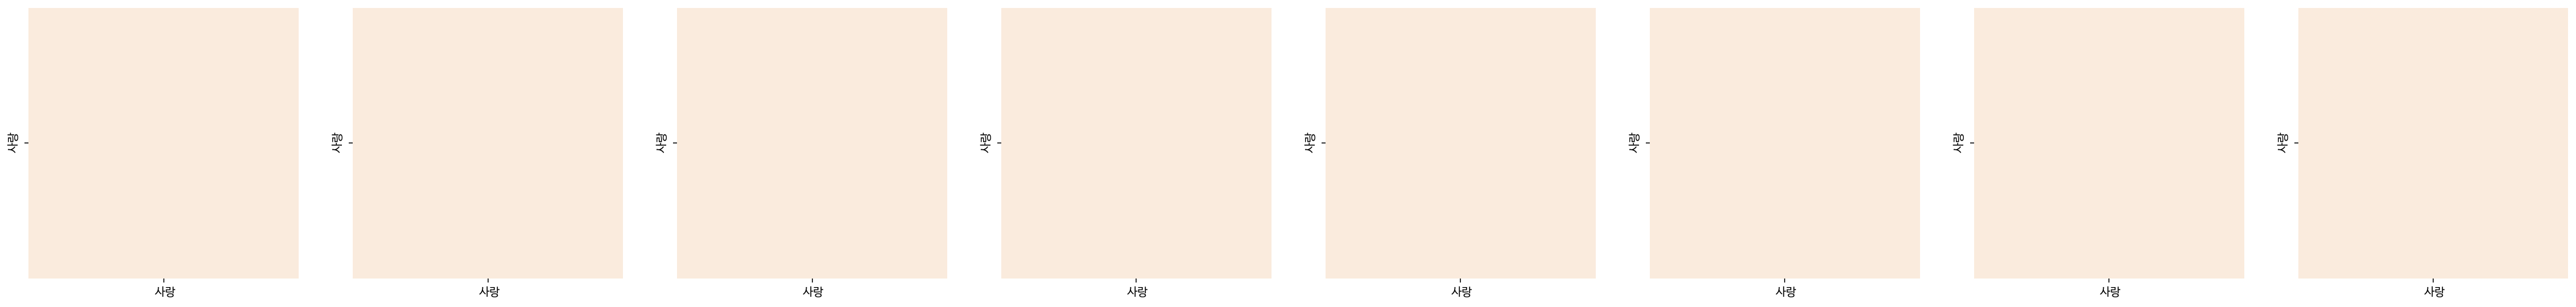

Encoder Layer 2


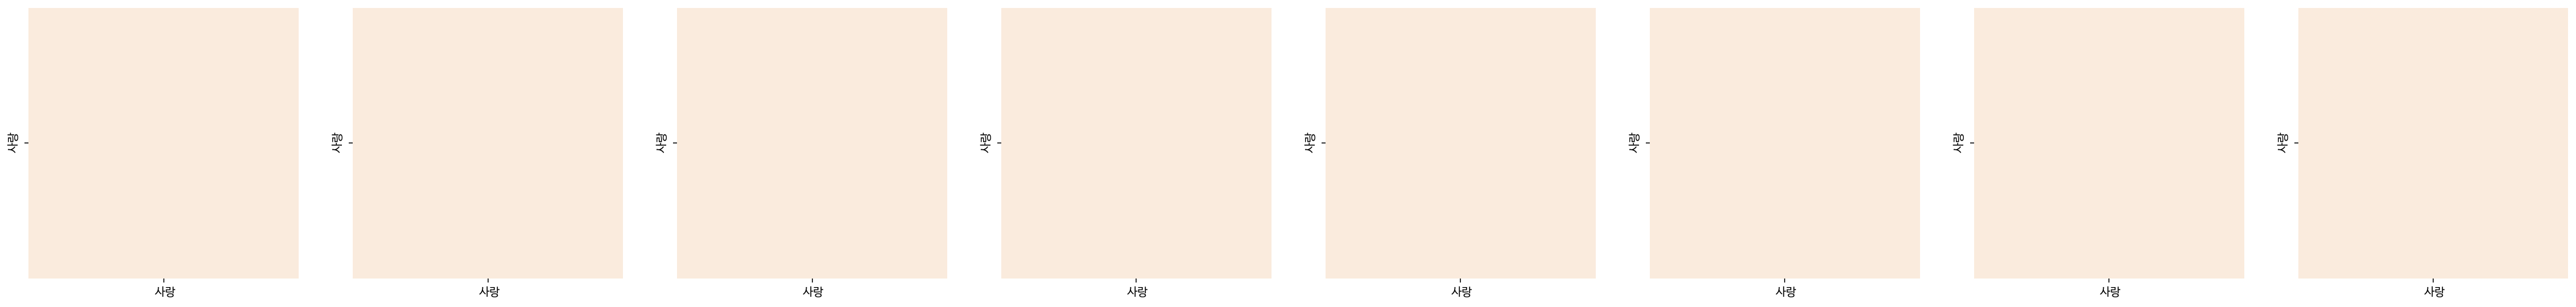

Encoder Layer 3


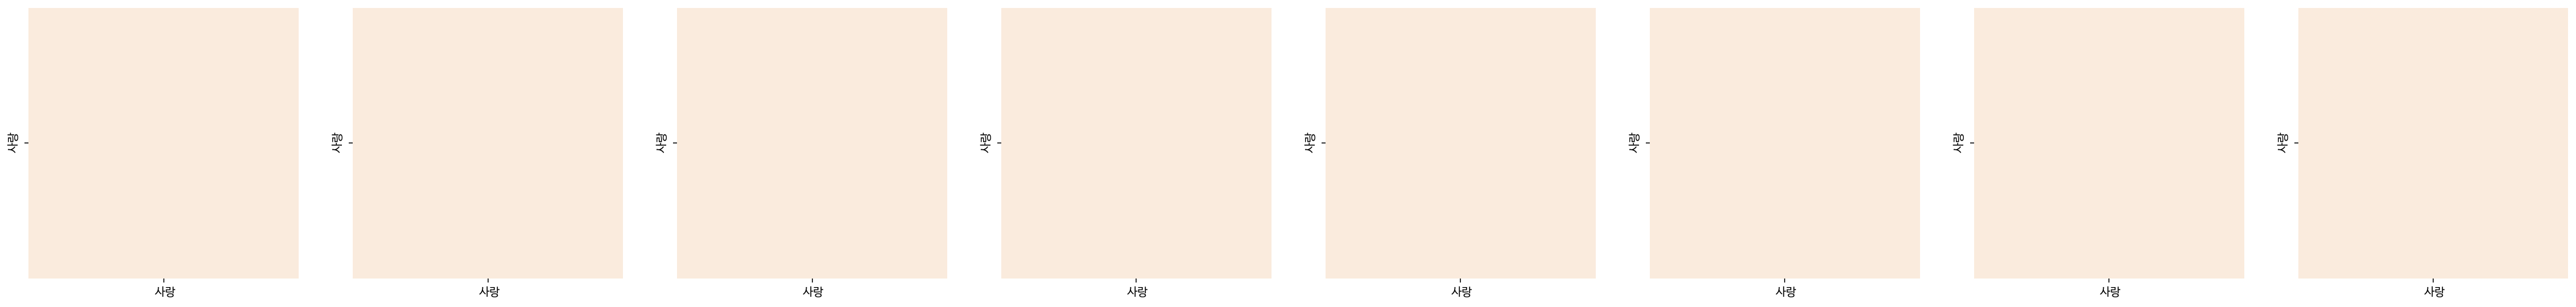

Encoder Layer 4


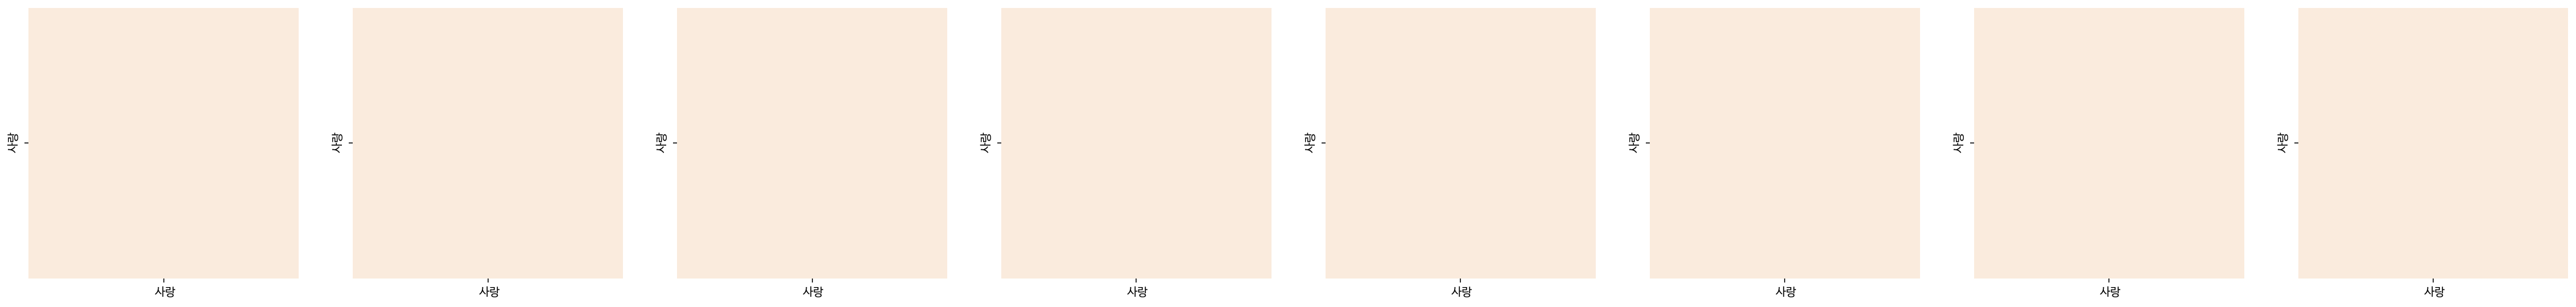

Encoder Layer 5


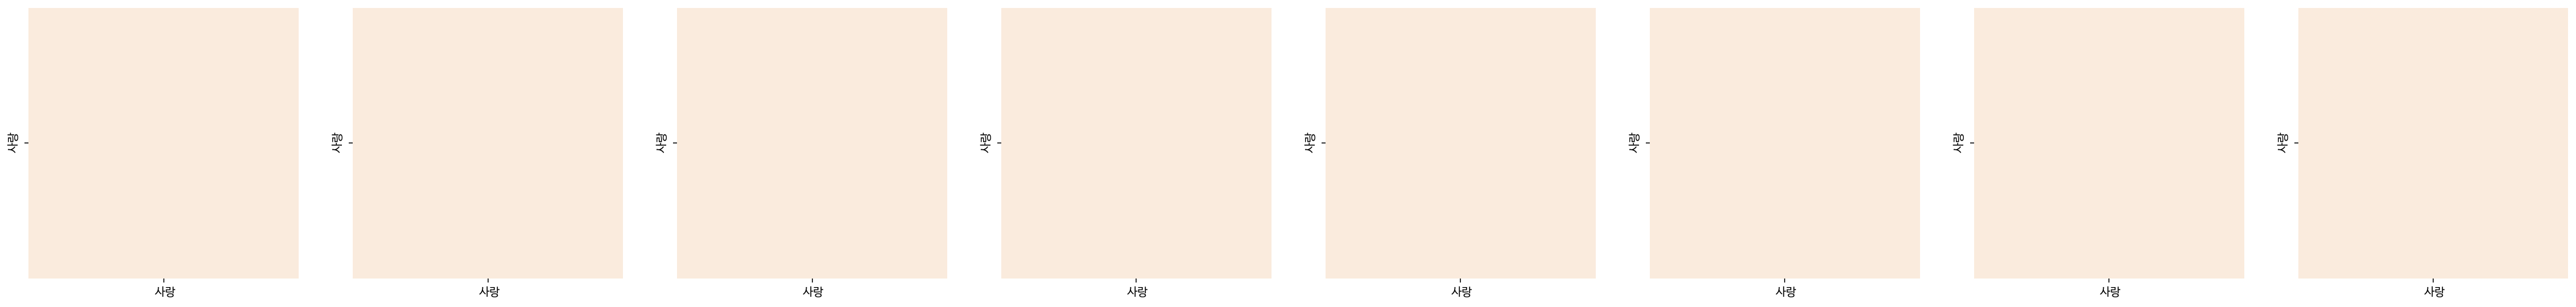

Encoder Layer 6


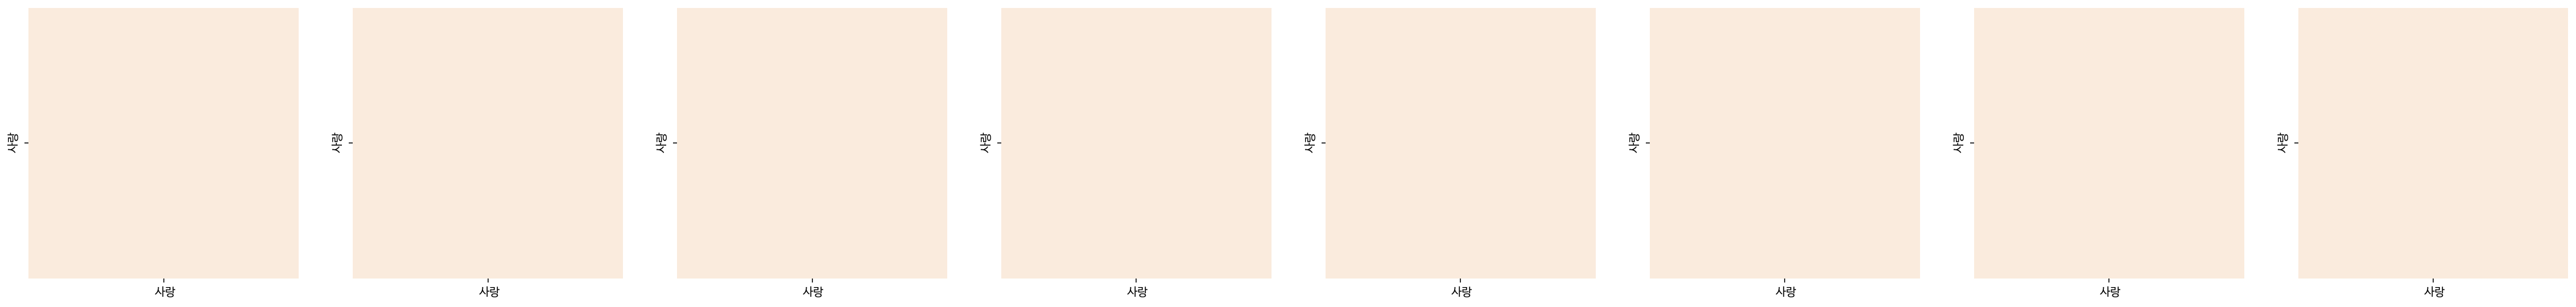

Decoder Self Layer 1


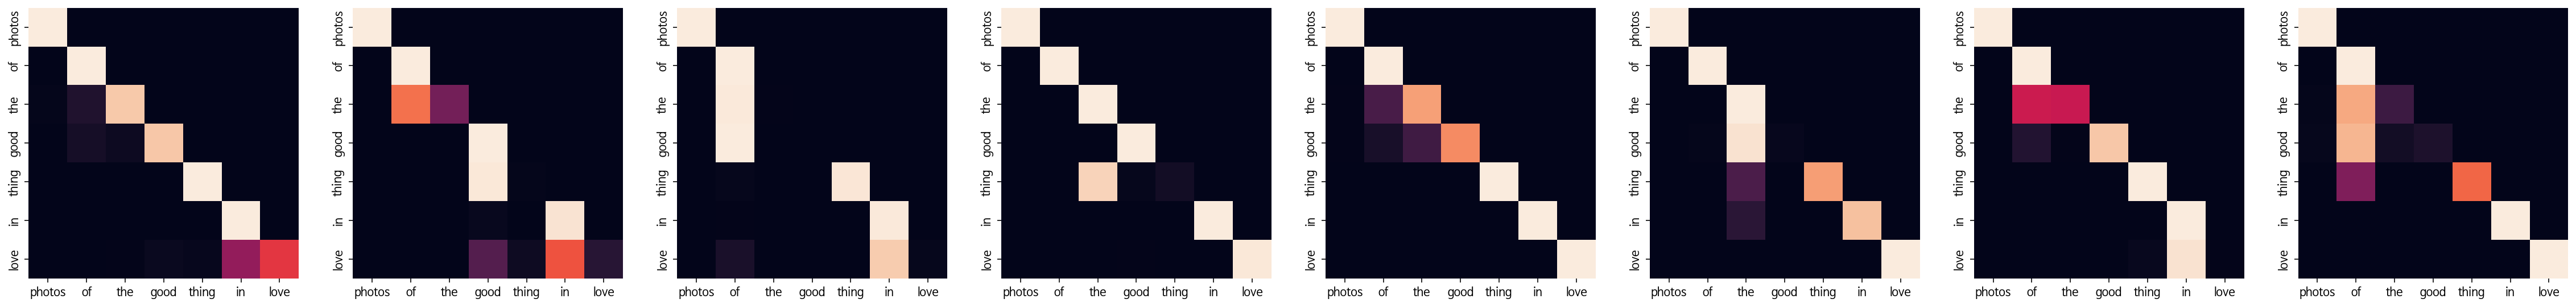

Decoder Src Layer 1


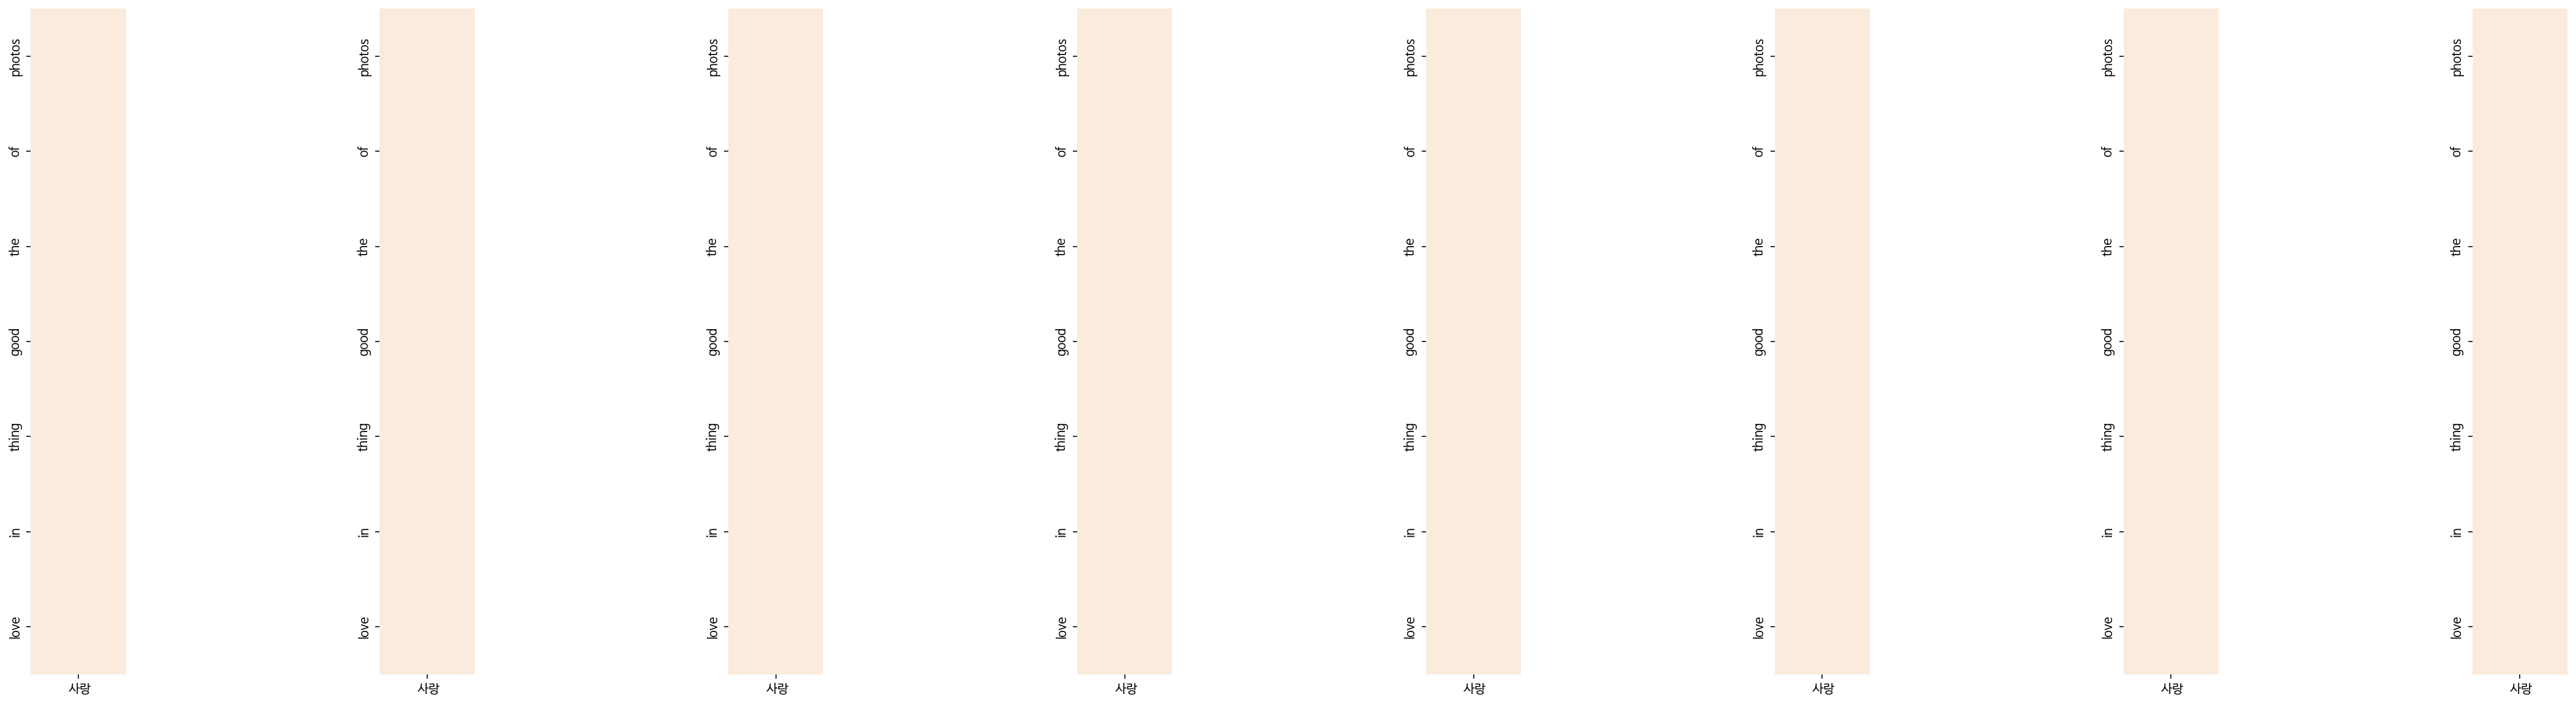

Decoder Self Layer 2


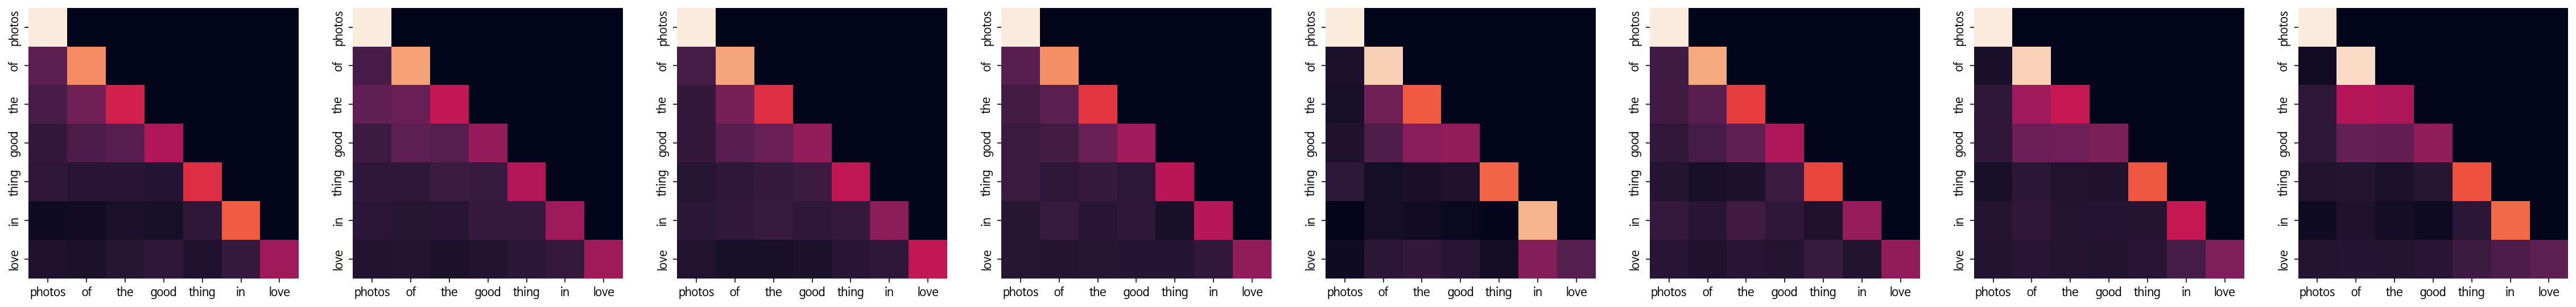

Decoder Src Layer 2


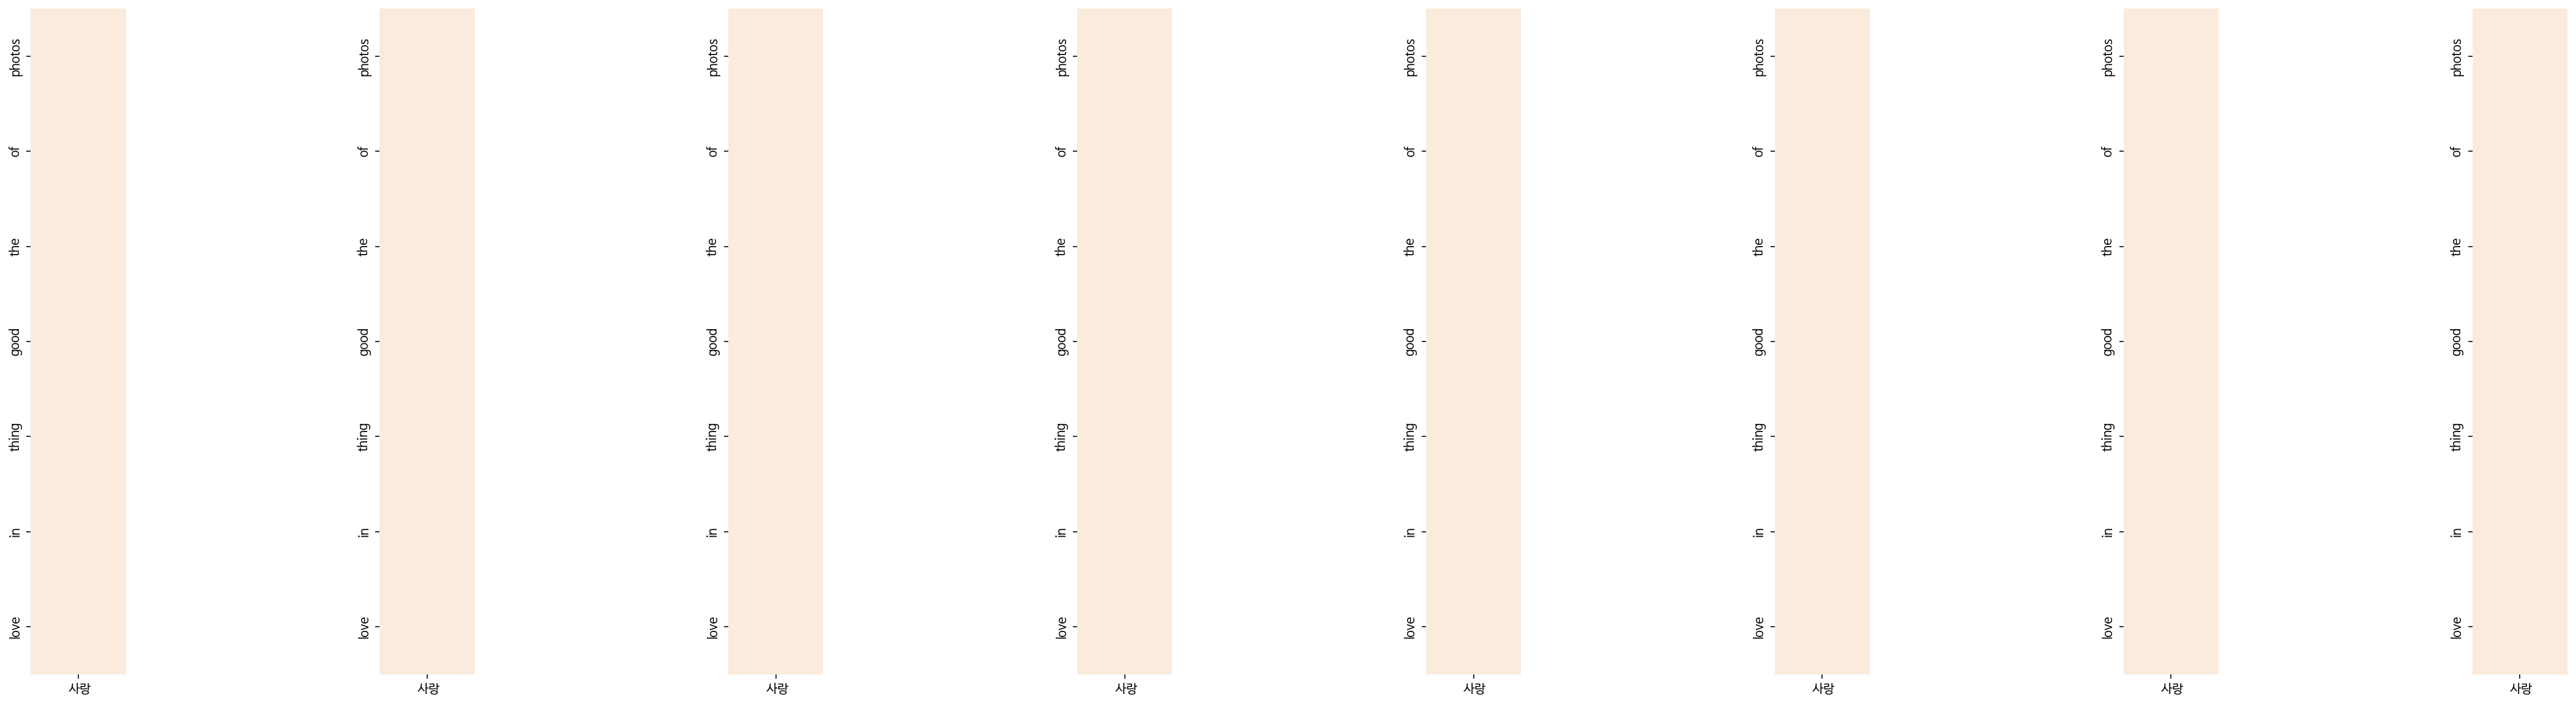

Decoder Self Layer 3


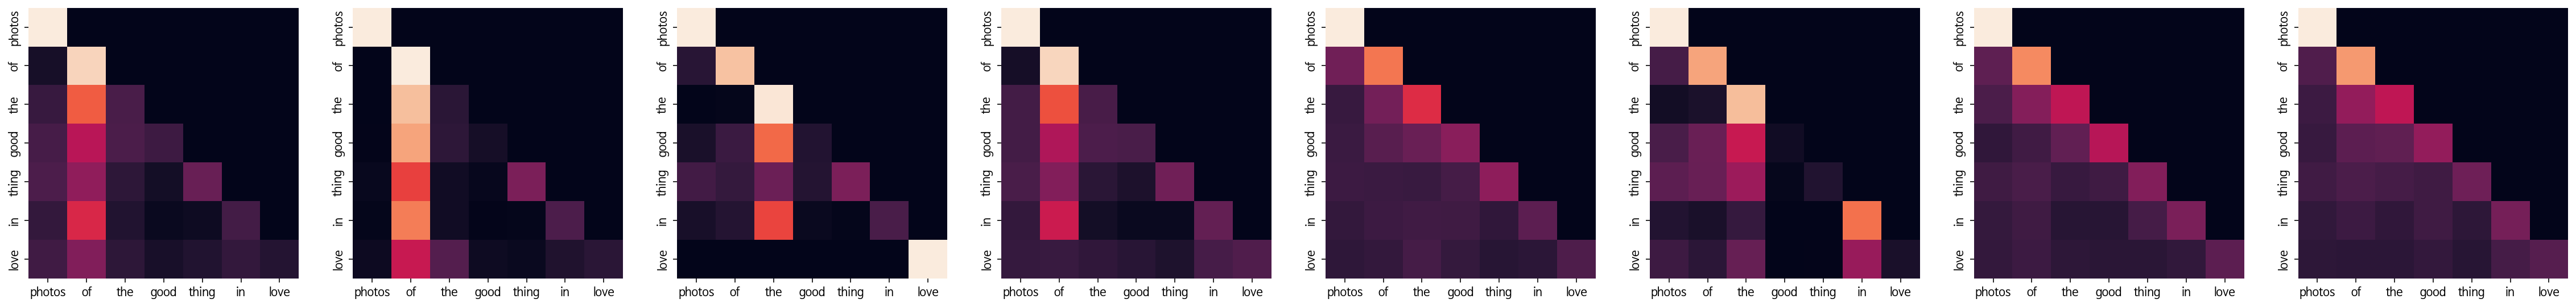

Decoder Src Layer 3


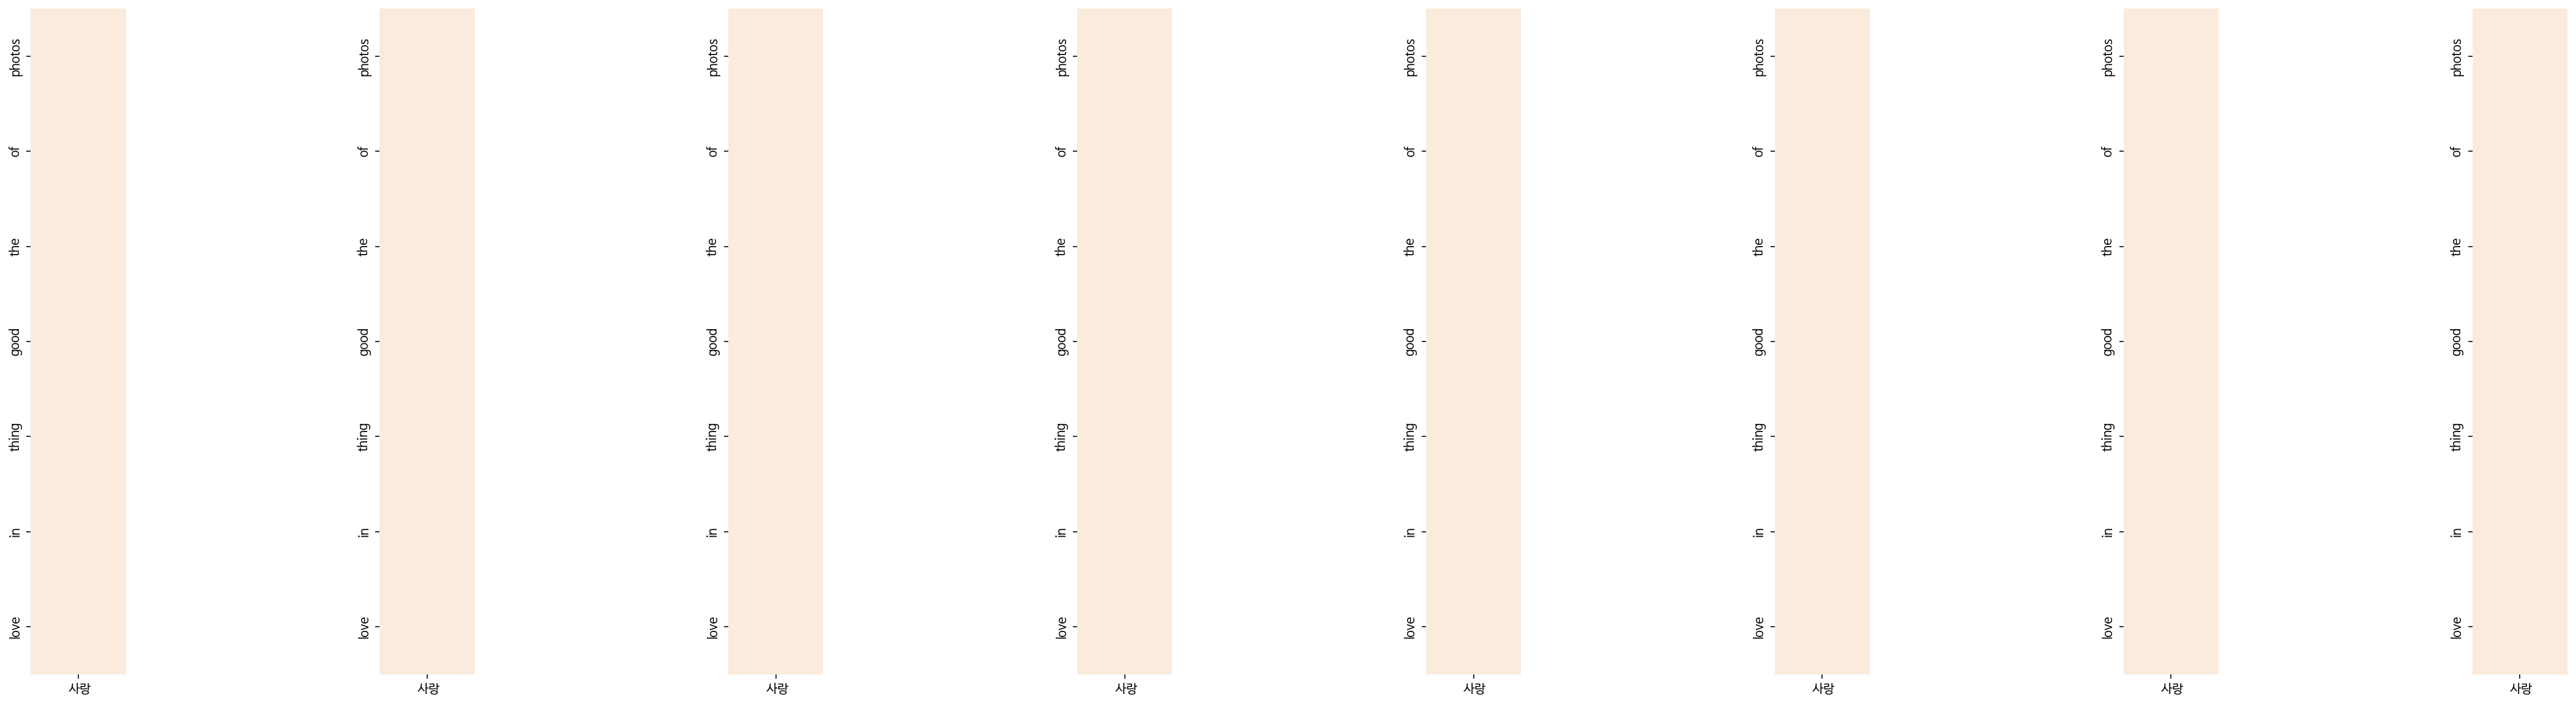

Decoder Self Layer 4


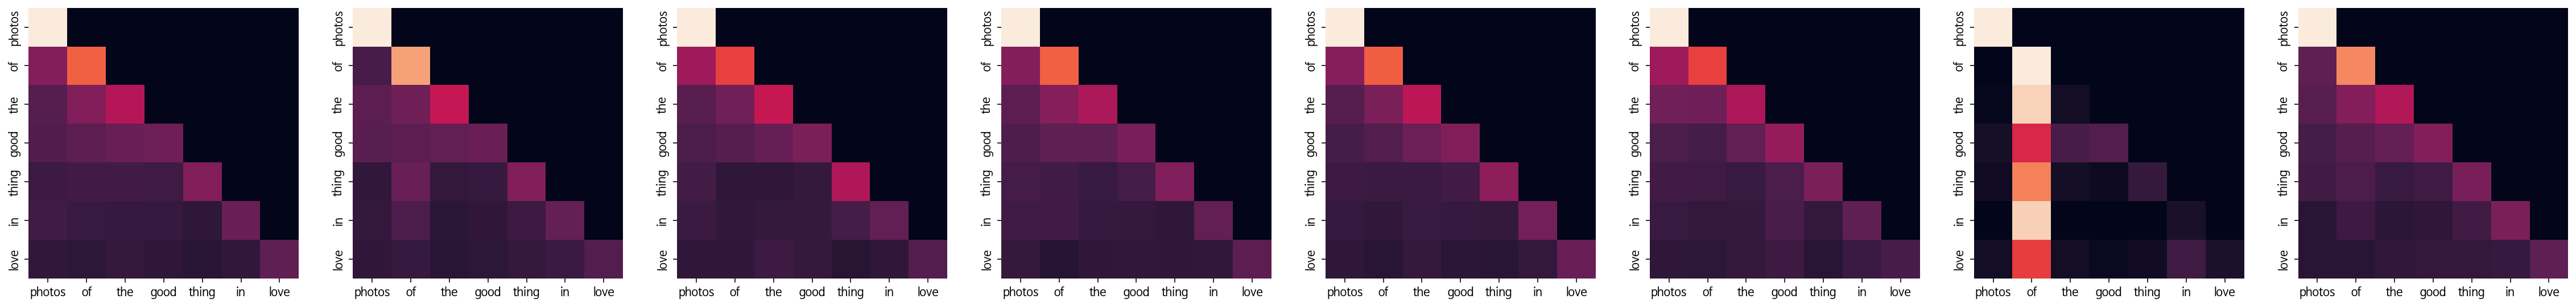

Decoder Src Layer 4


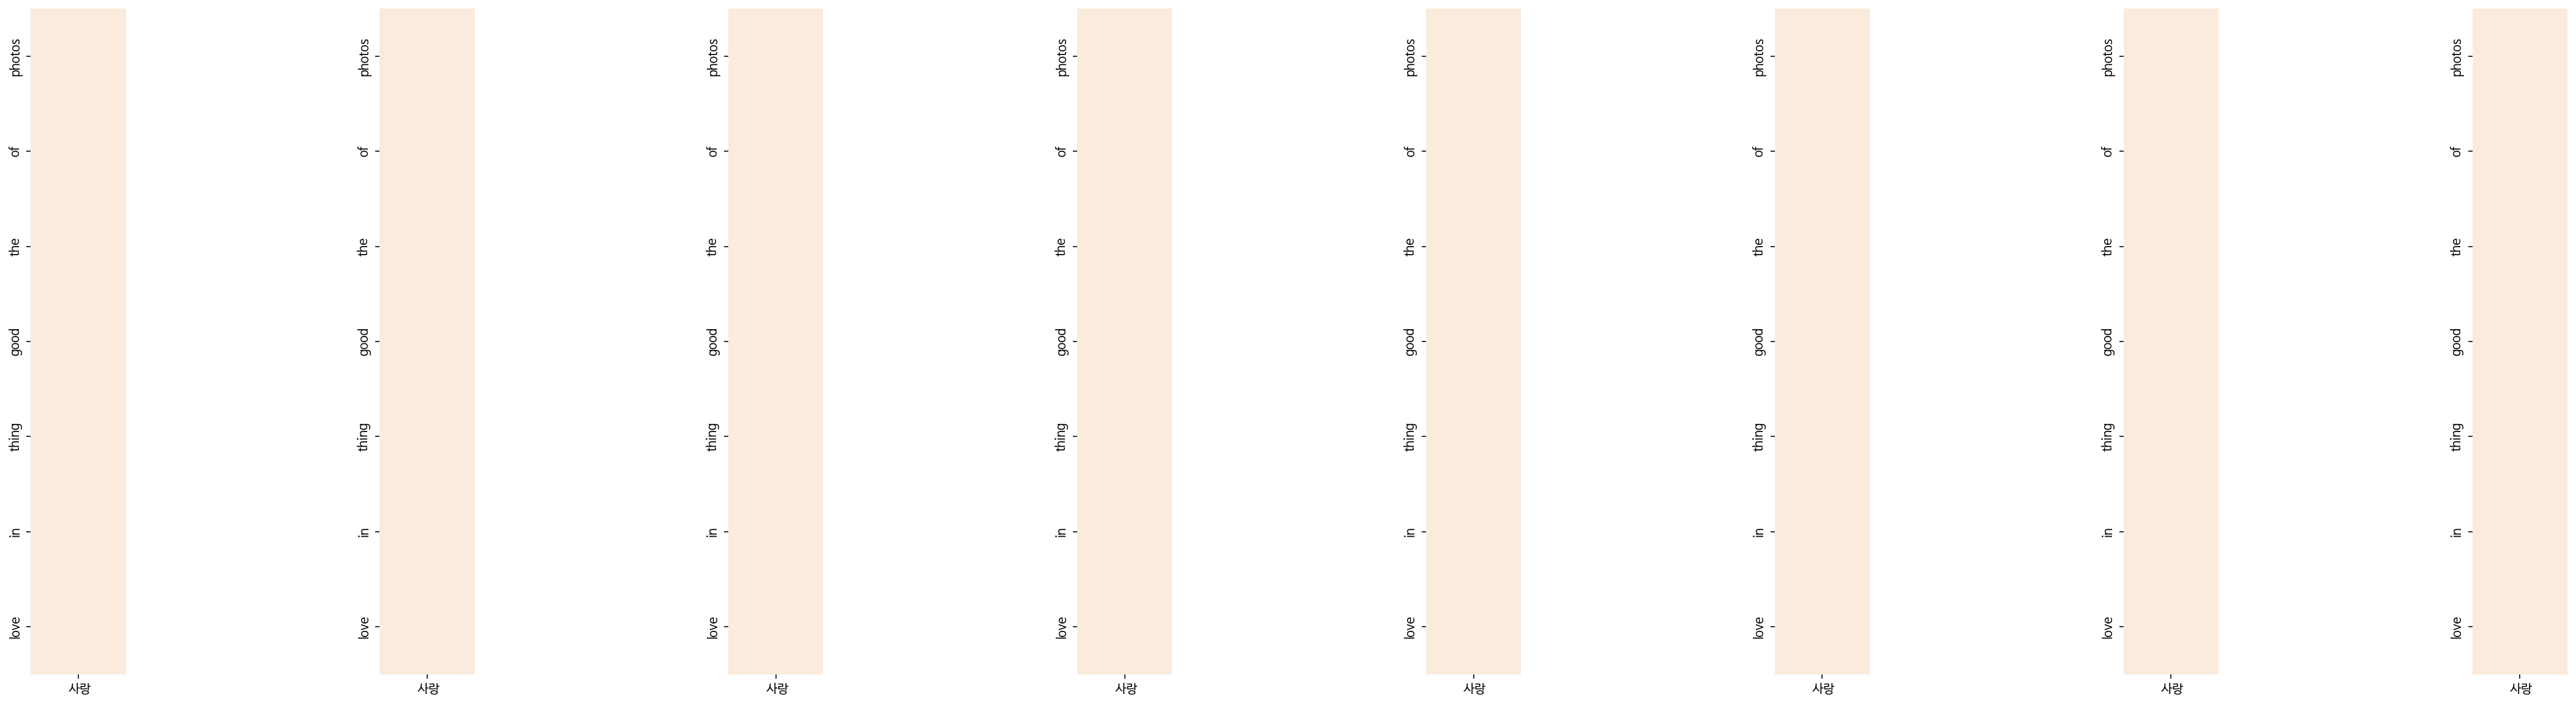

Decoder Self Layer 5


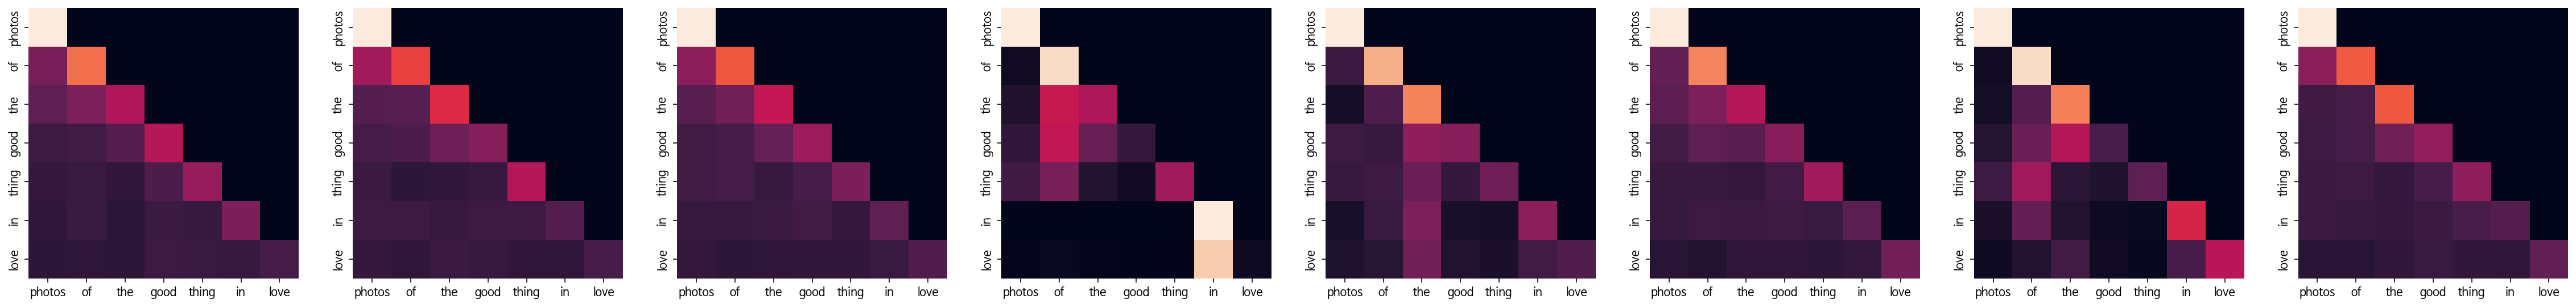

Decoder Src Layer 5


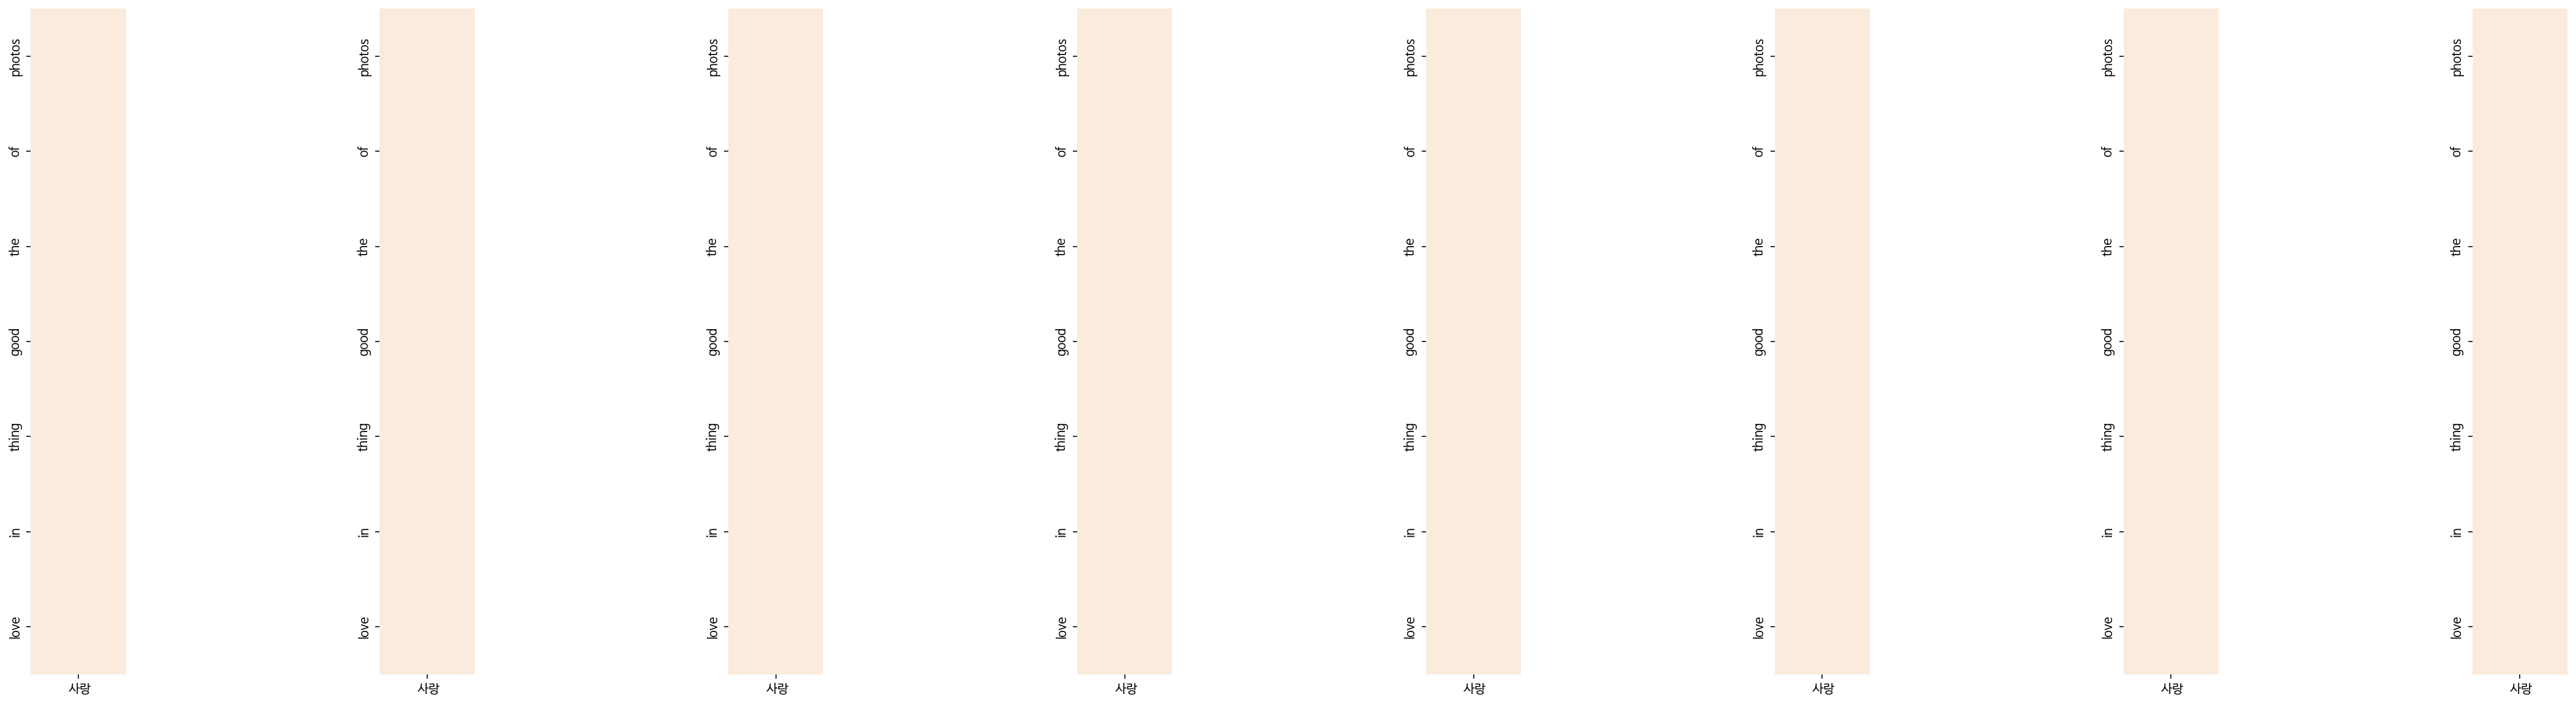

Decoder Self Layer 6


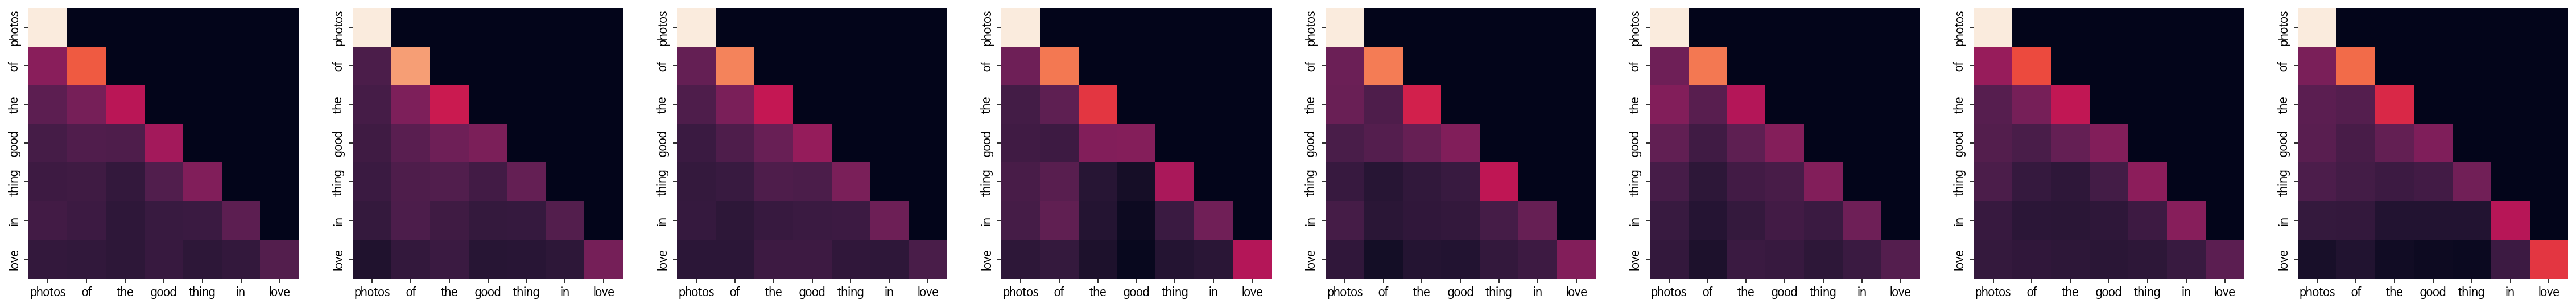

Decoder Src Layer 6


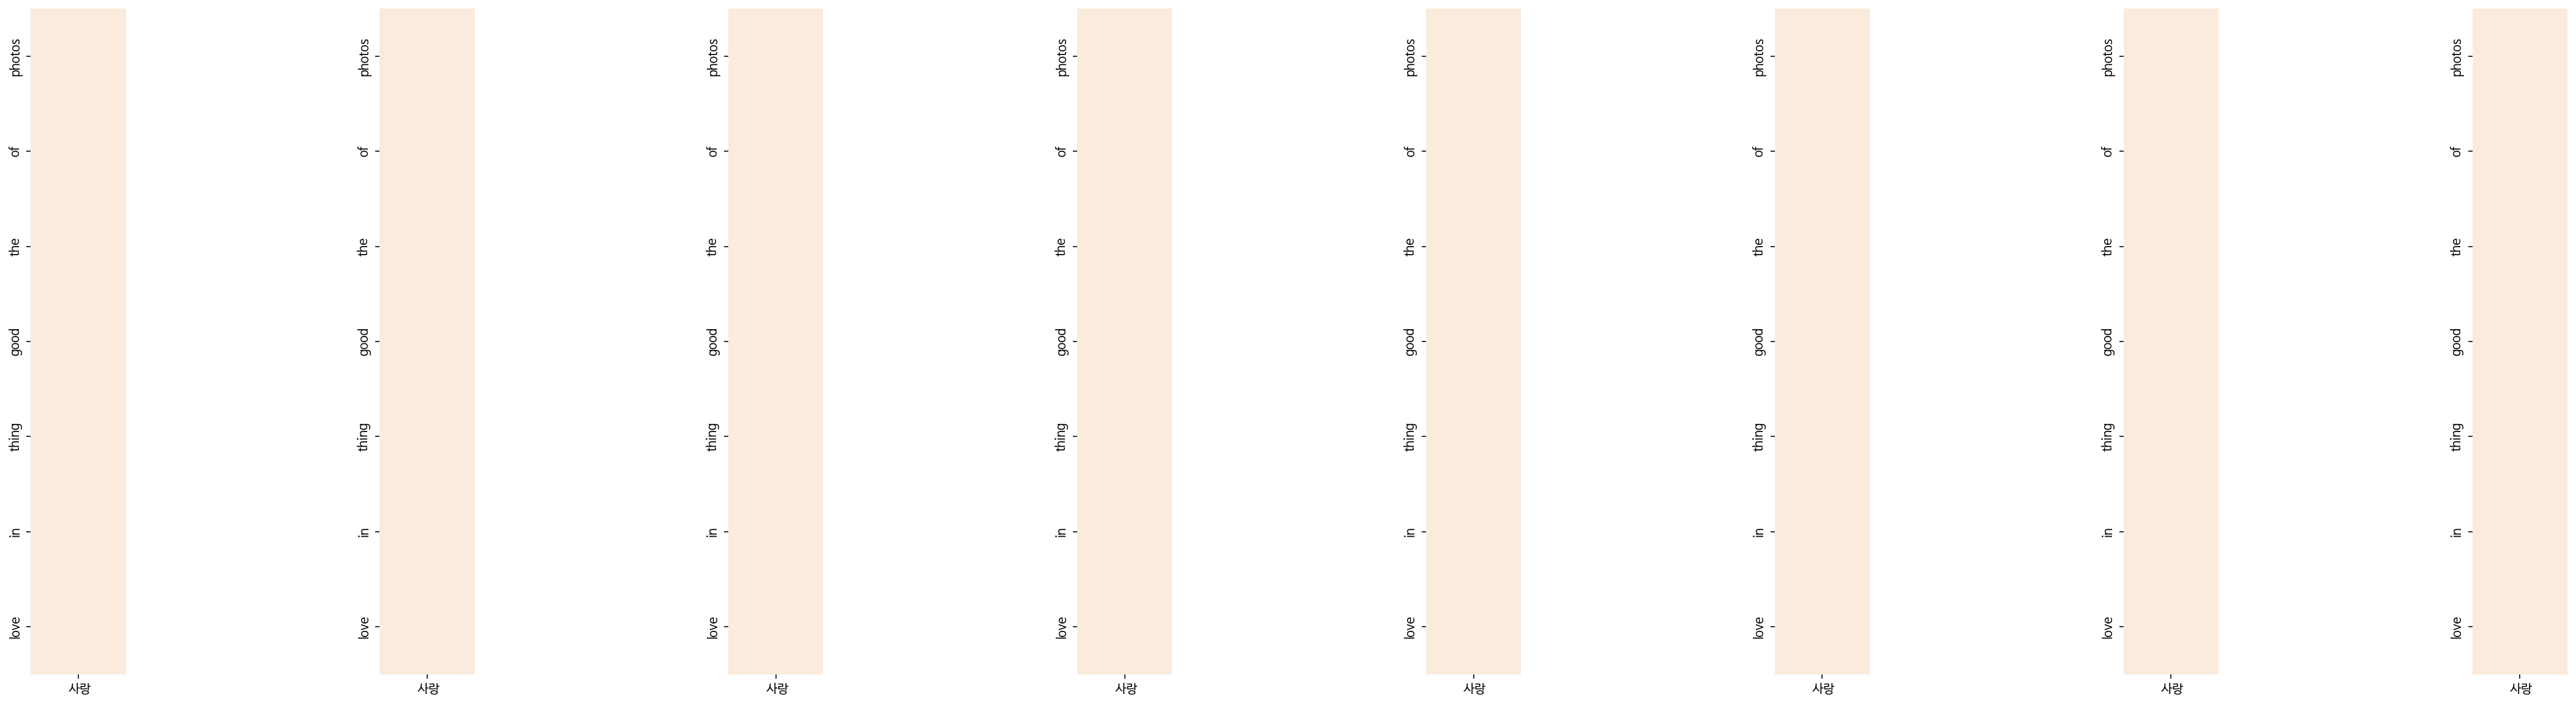

In [219]:
translate("사랑", transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Input: 식사 커피 집 자동차 노래 음악.
Predicted translation: big names like shoes
Encoder Layer 1


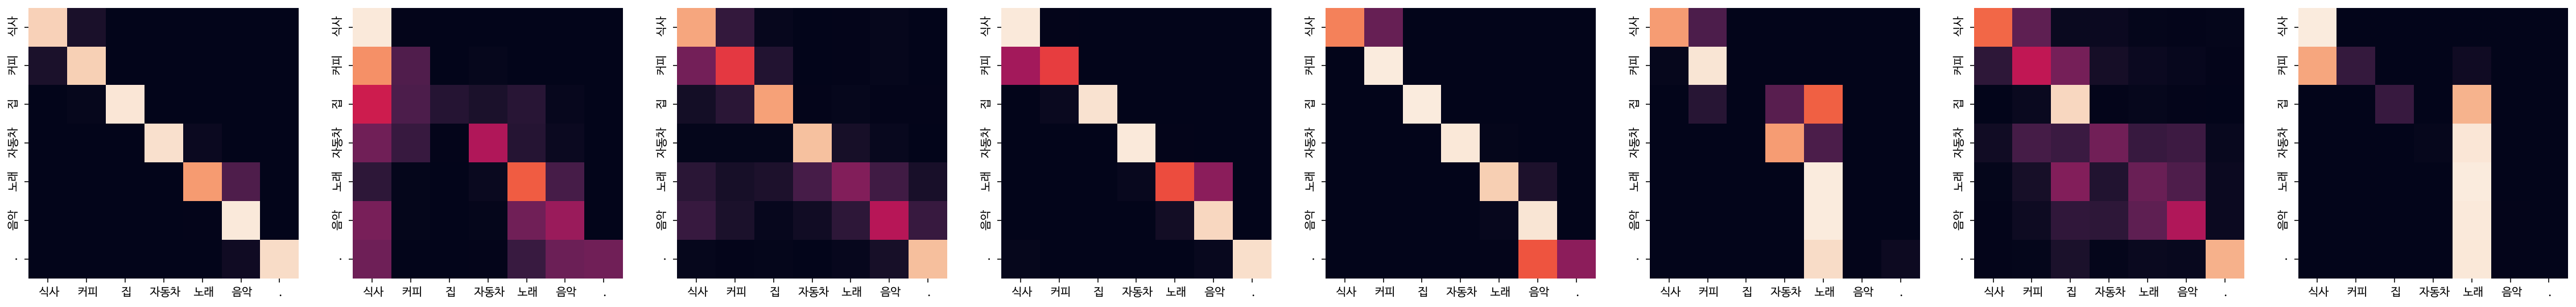

Encoder Layer 2


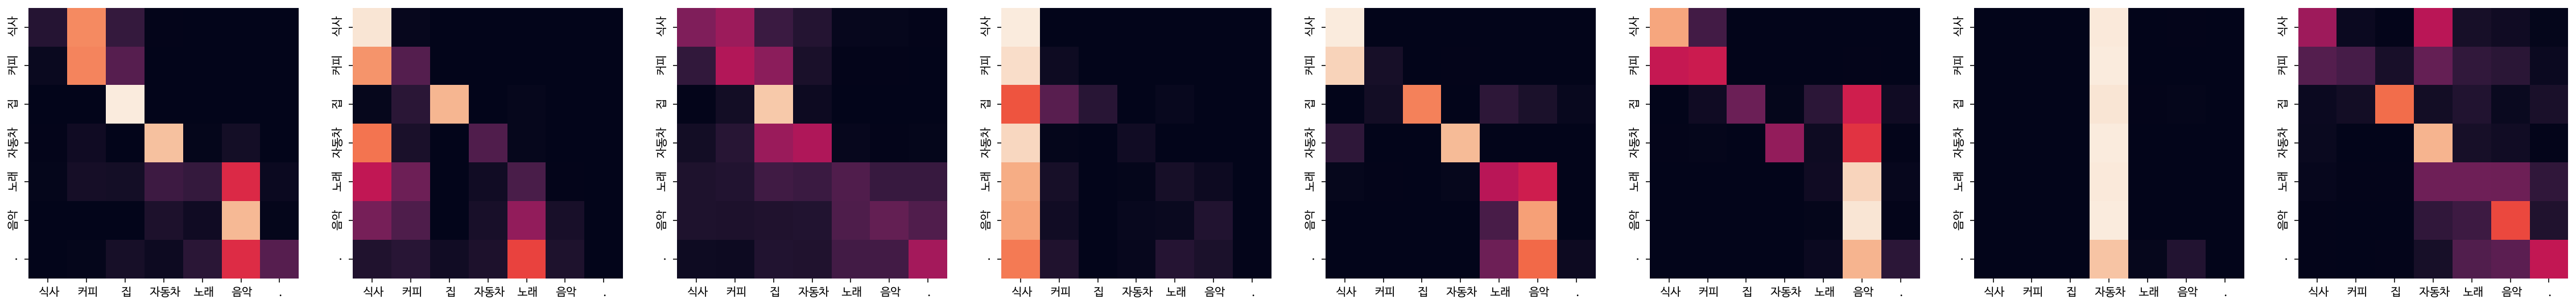

Encoder Layer 3


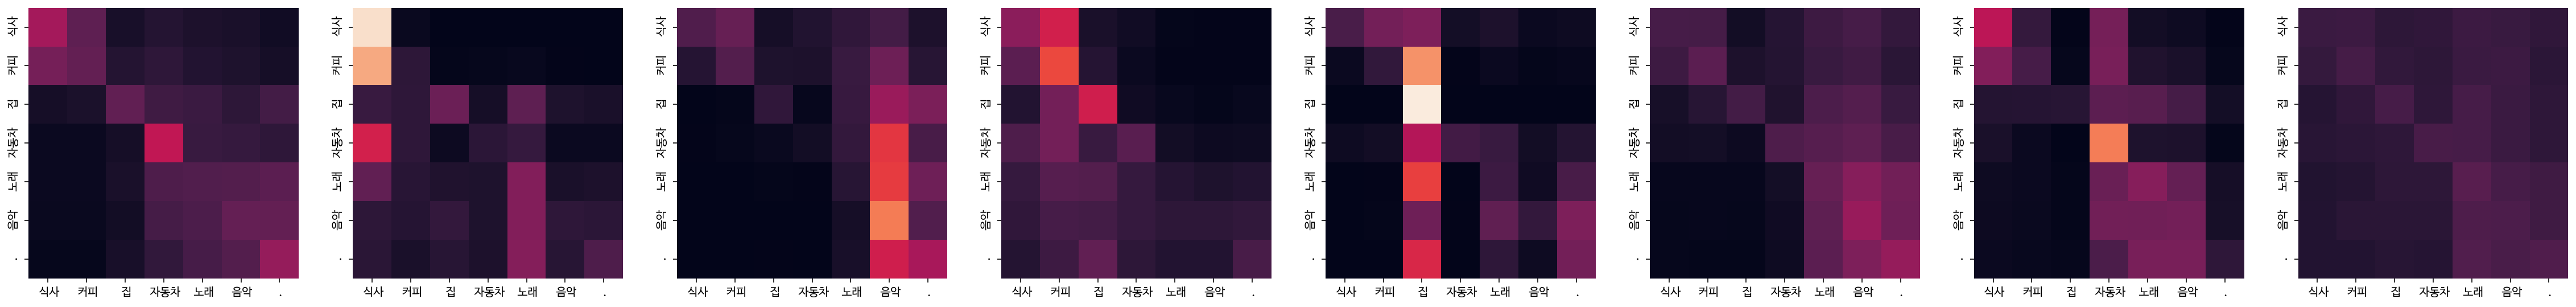

Encoder Layer 4


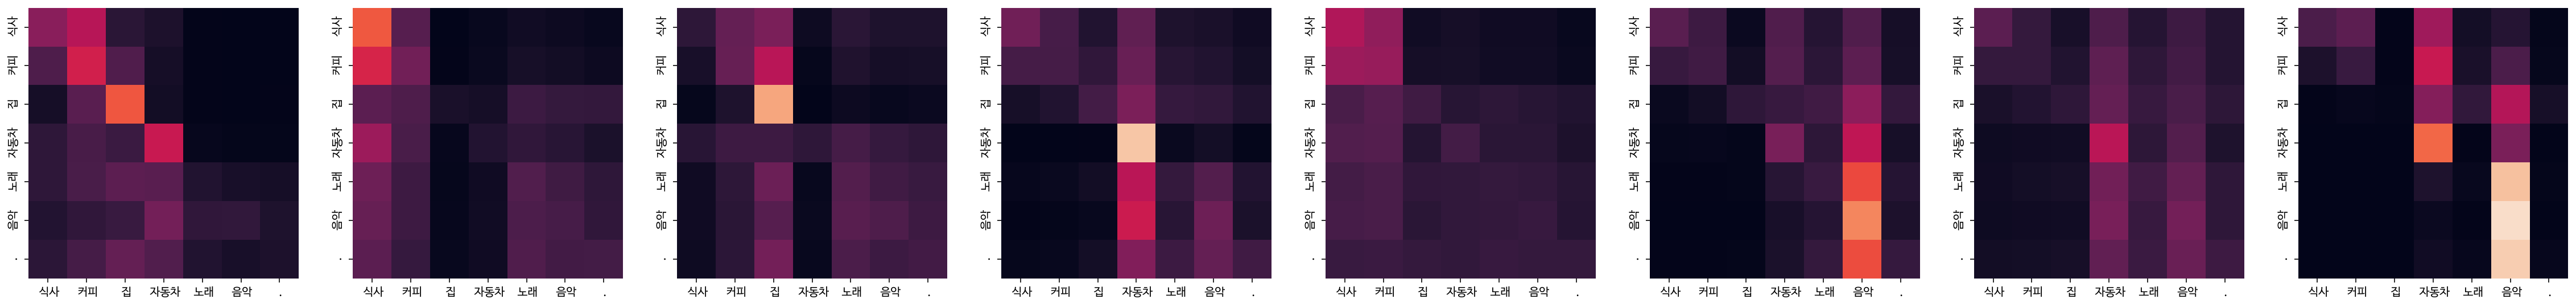

Encoder Layer 5


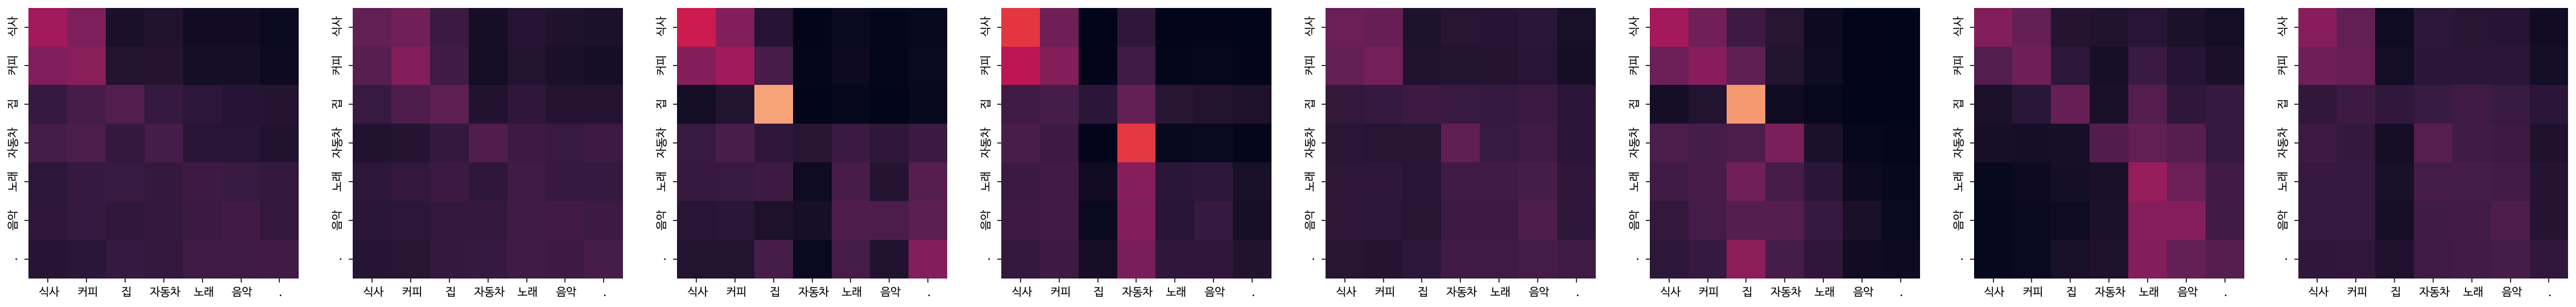

Encoder Layer 6


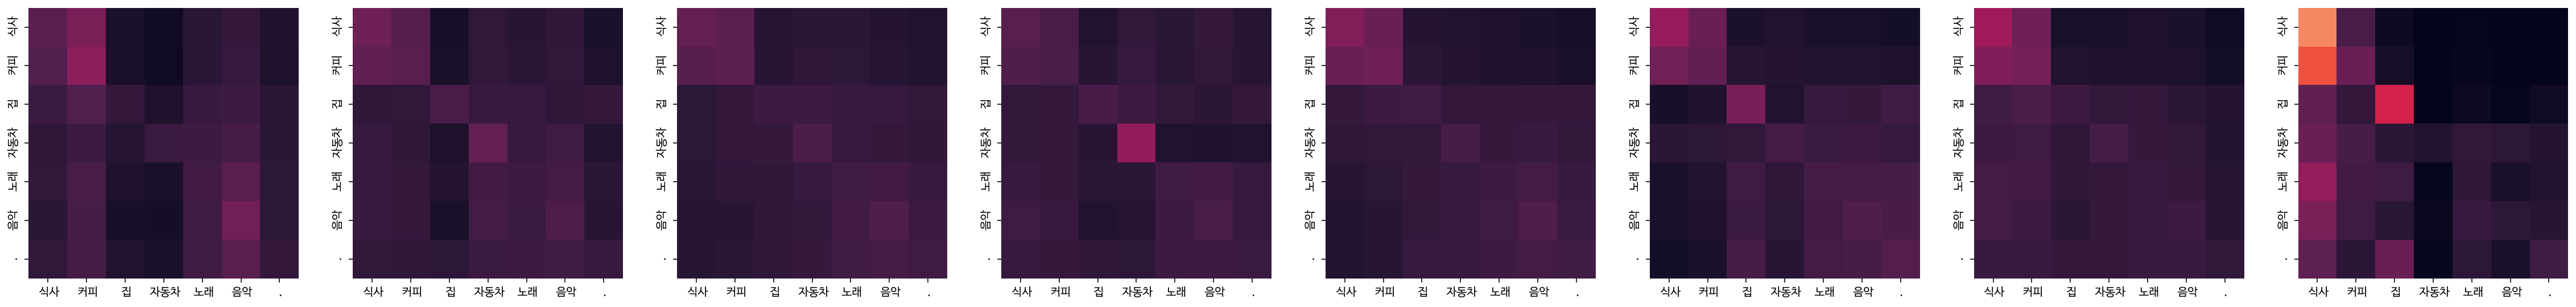

Decoder Self Layer 1


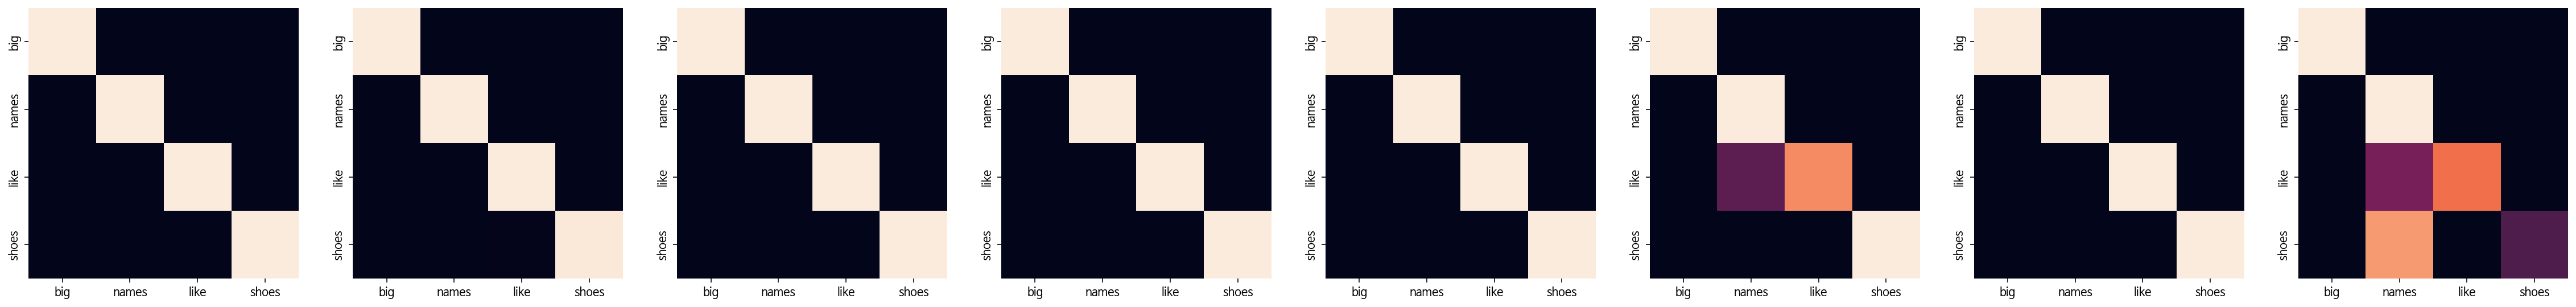

Decoder Src Layer 1


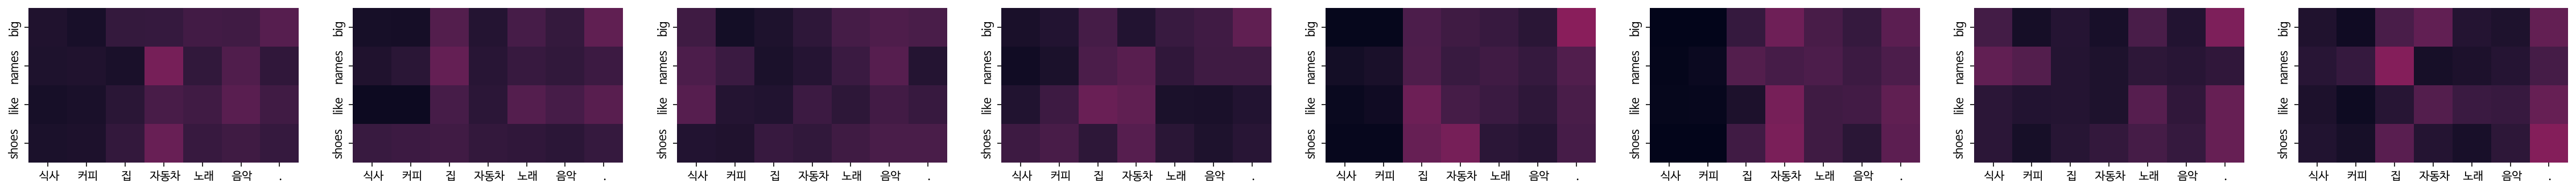

Decoder Self Layer 2


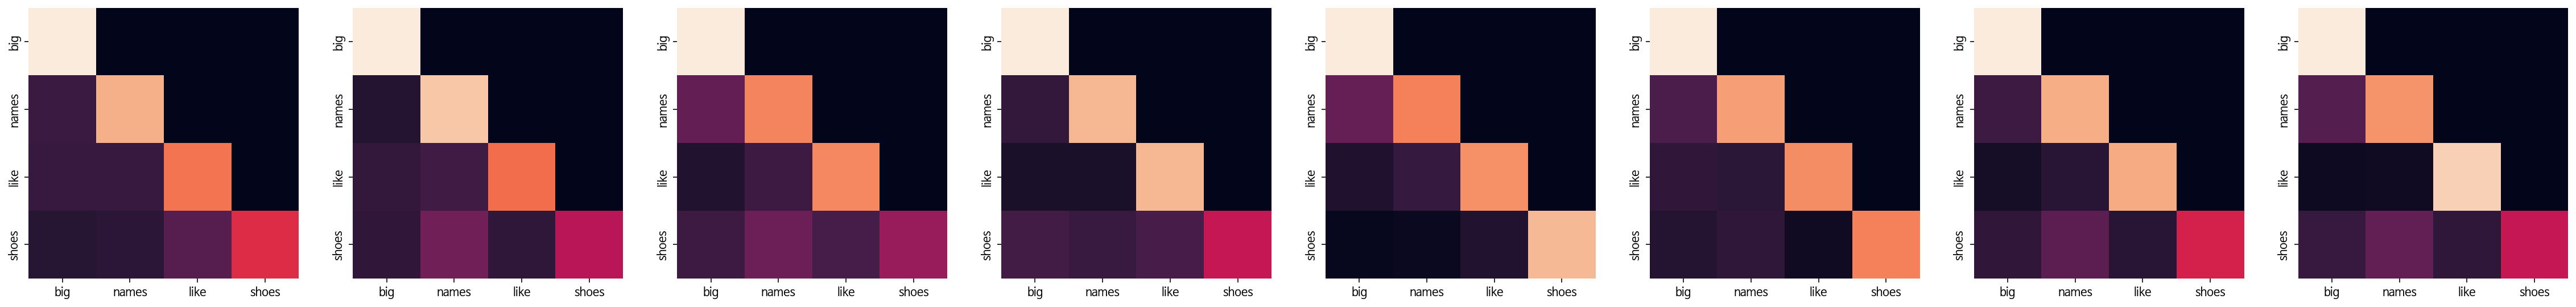

Decoder Src Layer 2


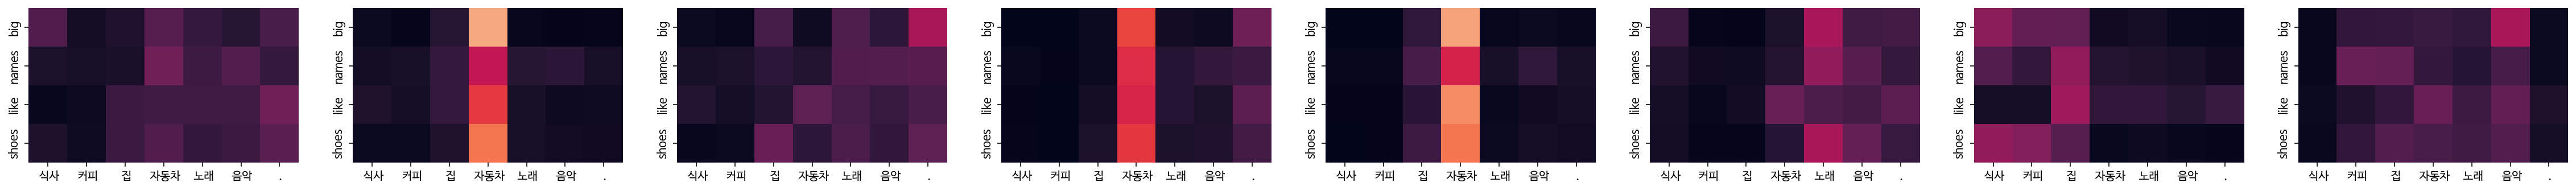

Decoder Self Layer 3


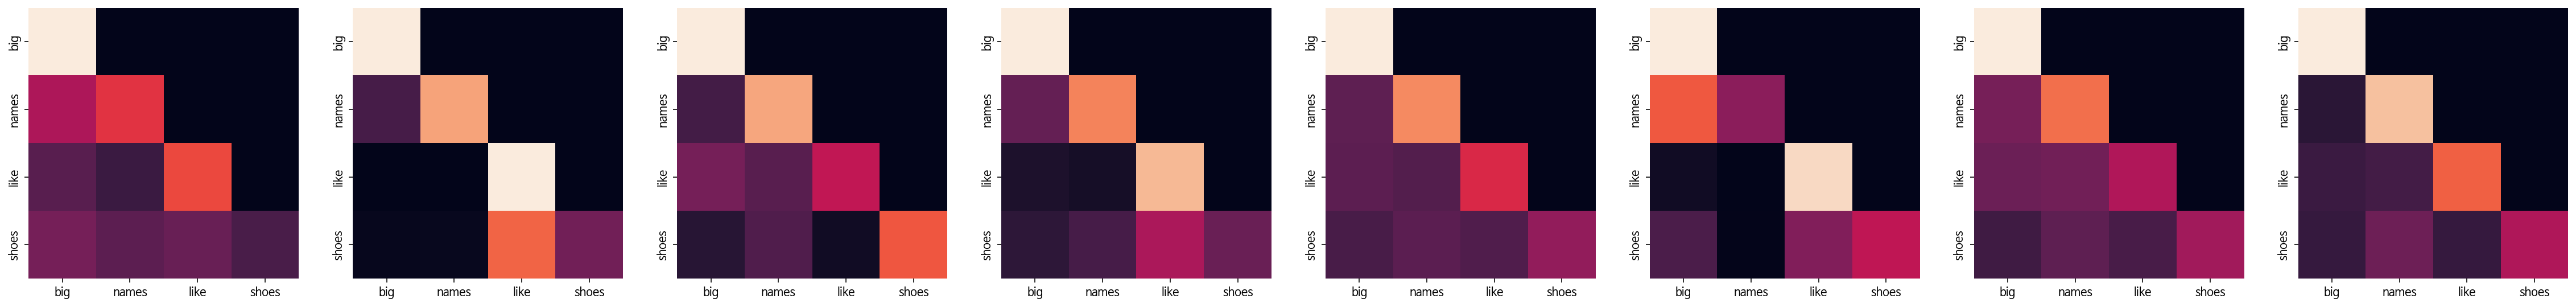

Decoder Src Layer 3


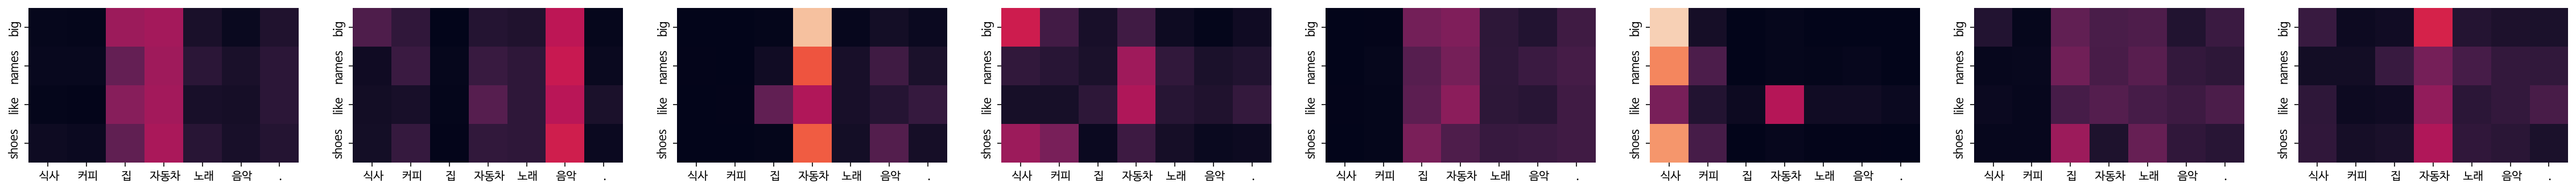

Decoder Self Layer 4


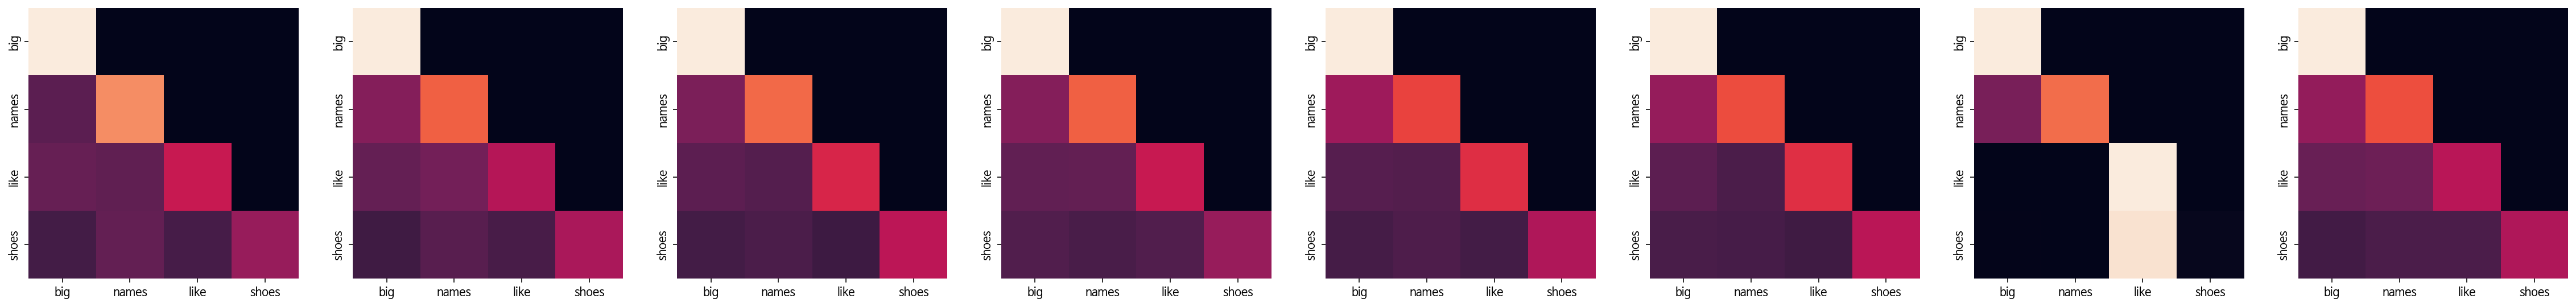

Decoder Src Layer 4


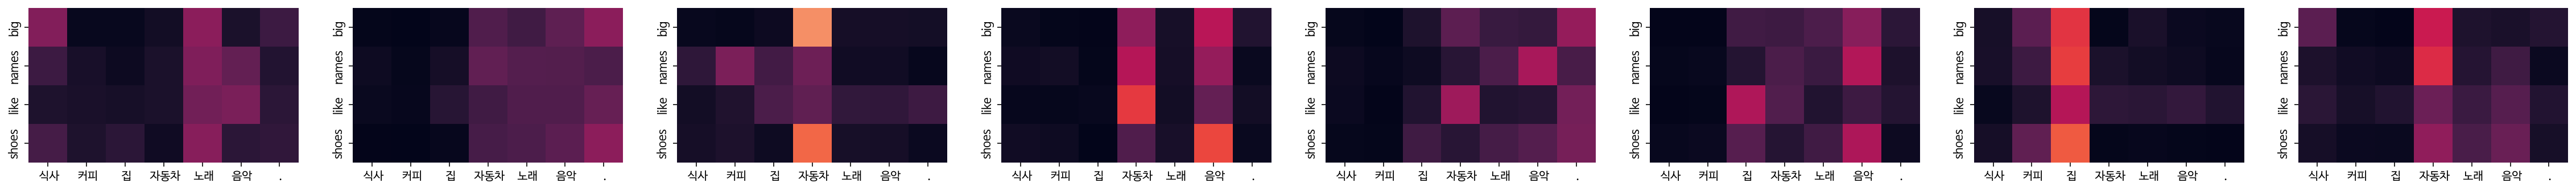

Decoder Self Layer 5


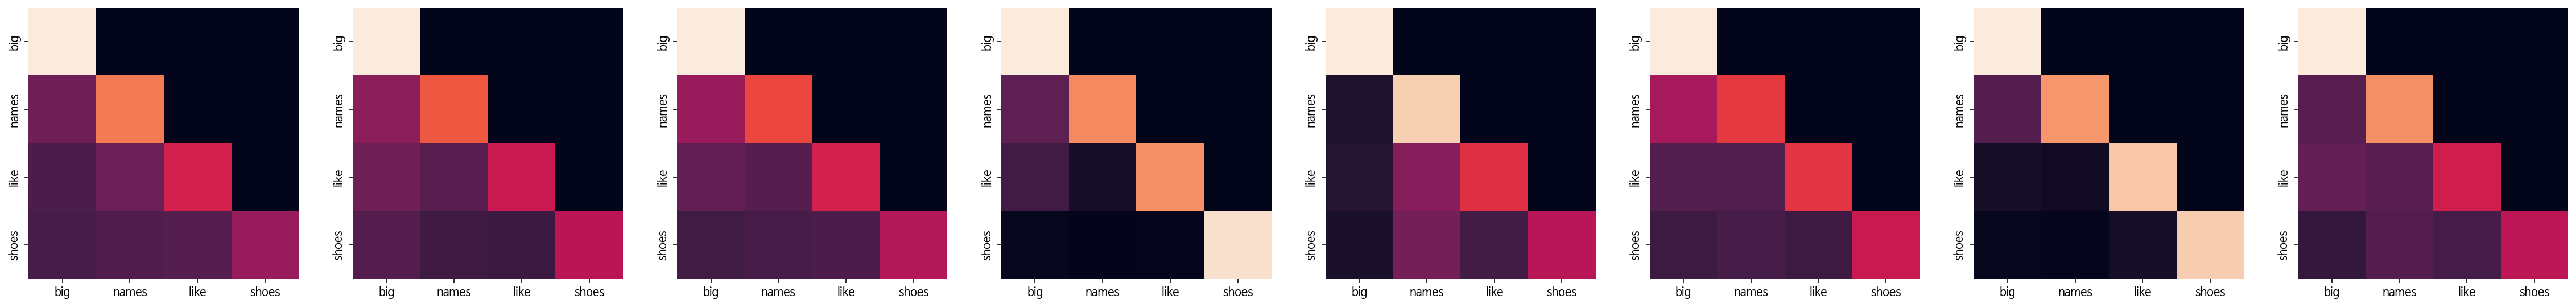

Decoder Src Layer 5


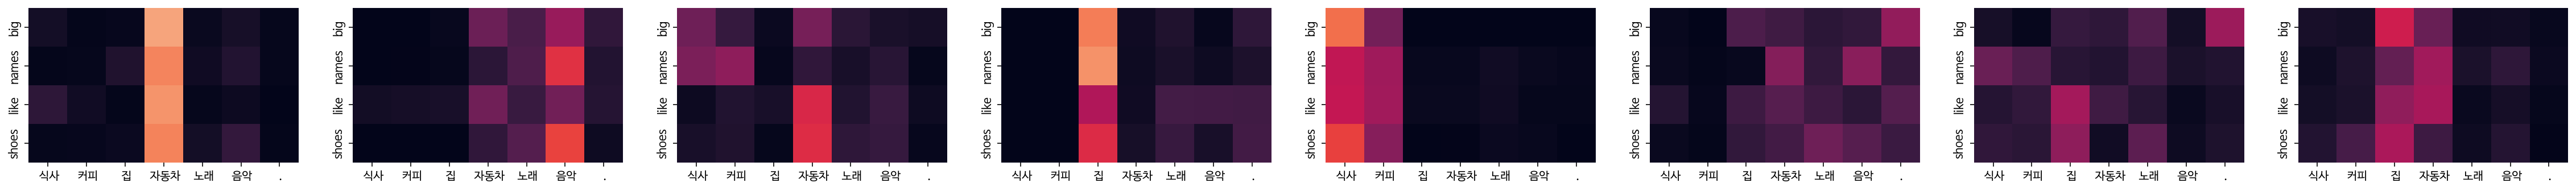

Decoder Self Layer 6


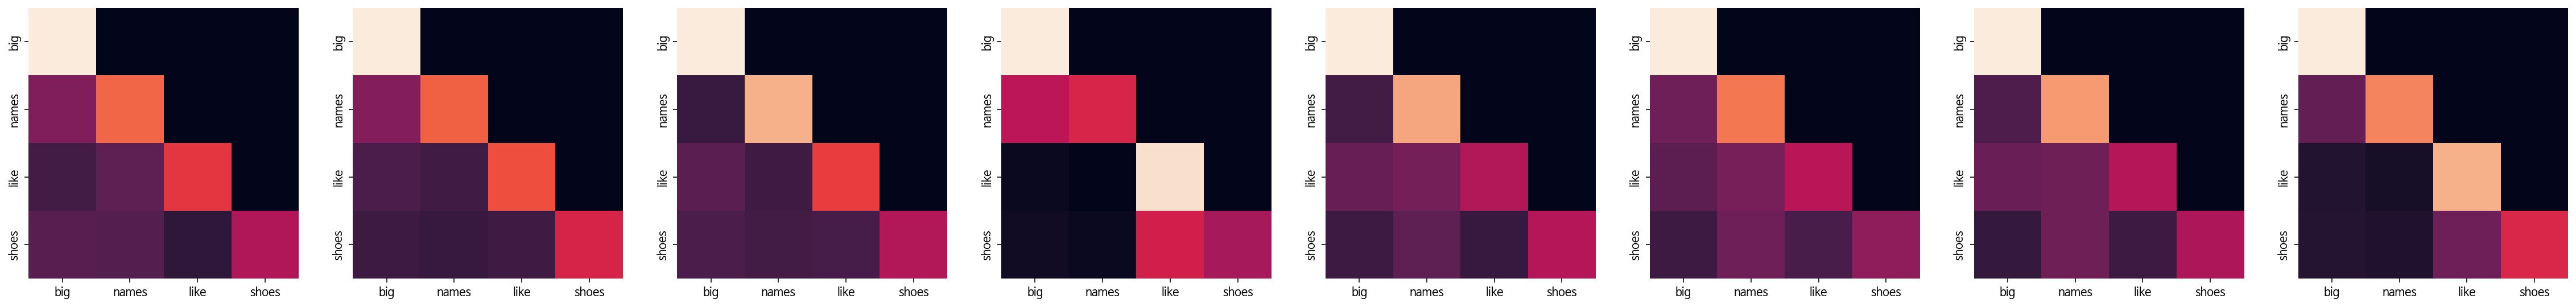

Decoder Src Layer 6


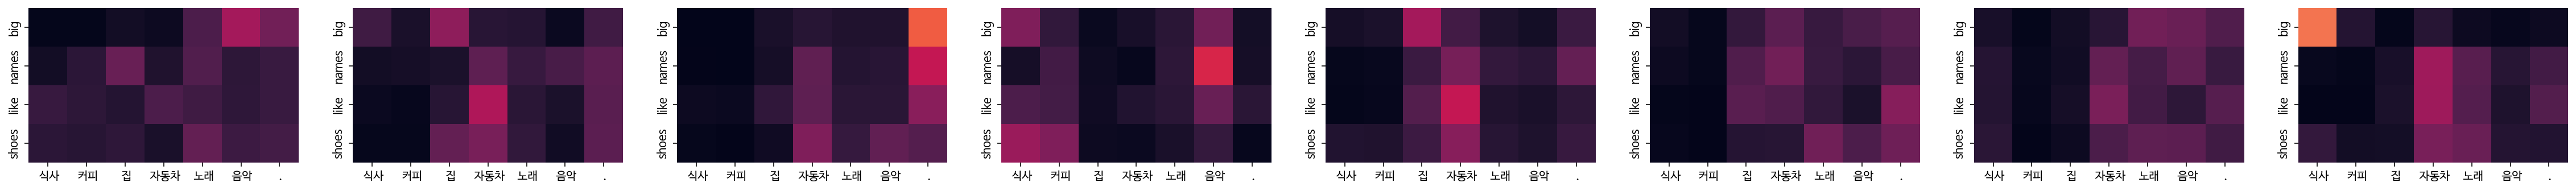

In [220]:
translate("식사 커피 집 자동차 노래 음악.", transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Input: 오바마는 대통령이다.
Predicted translation: obama s campaign has said he s a president .
Encoder Layer 1


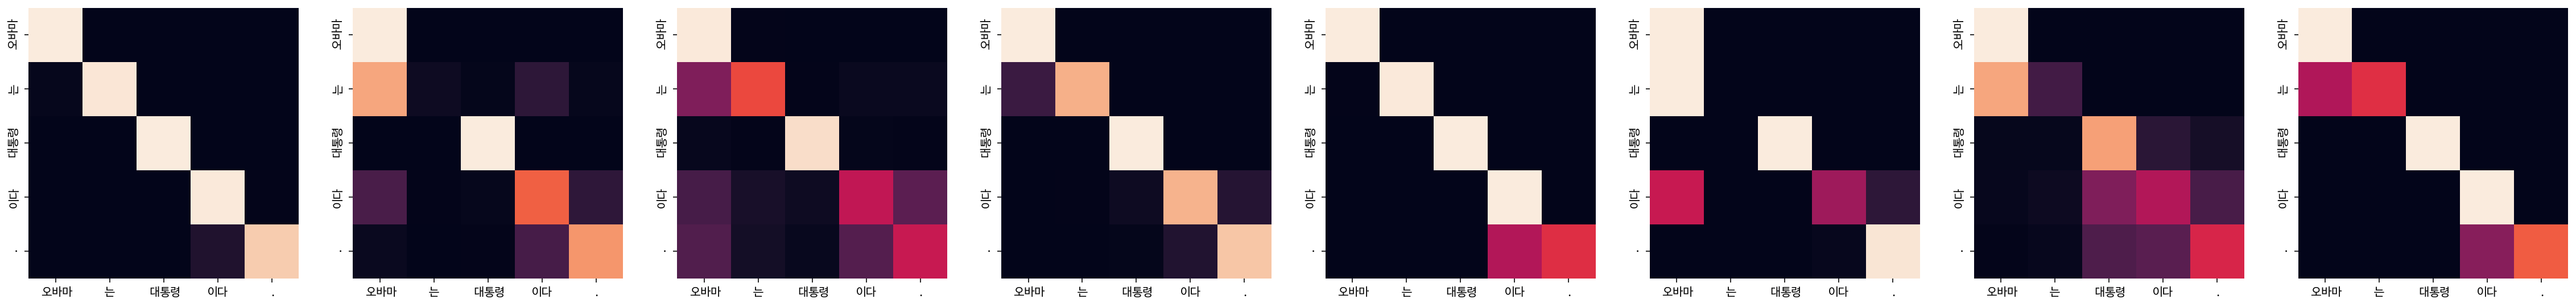

Encoder Layer 2


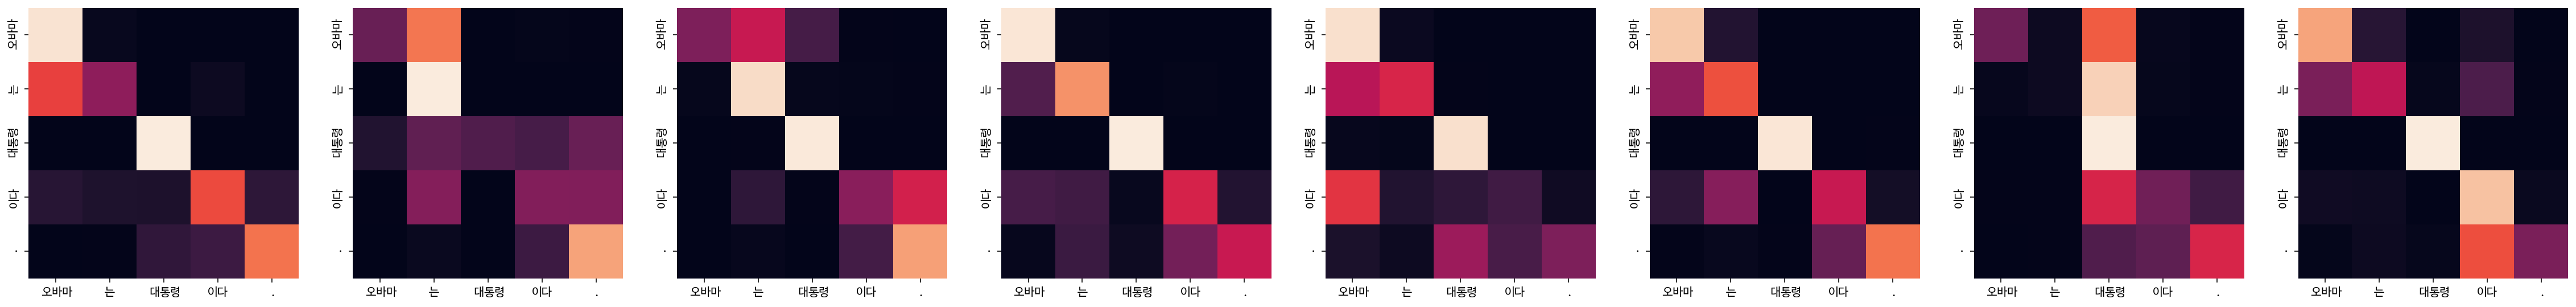

Encoder Layer 3


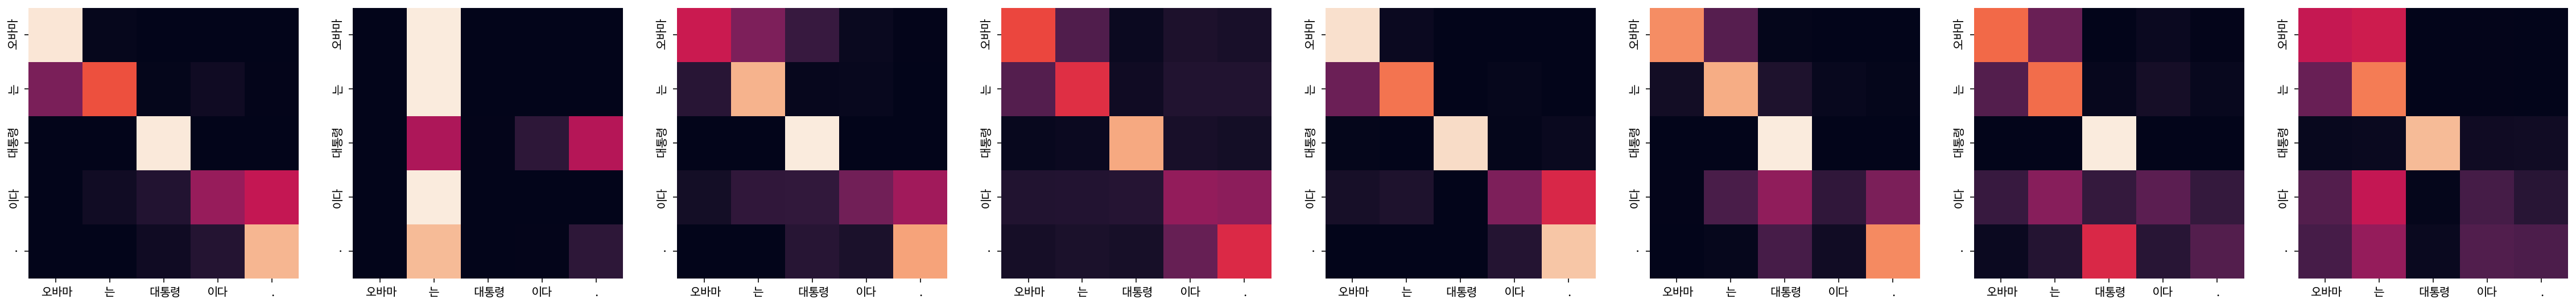

Encoder Layer 4


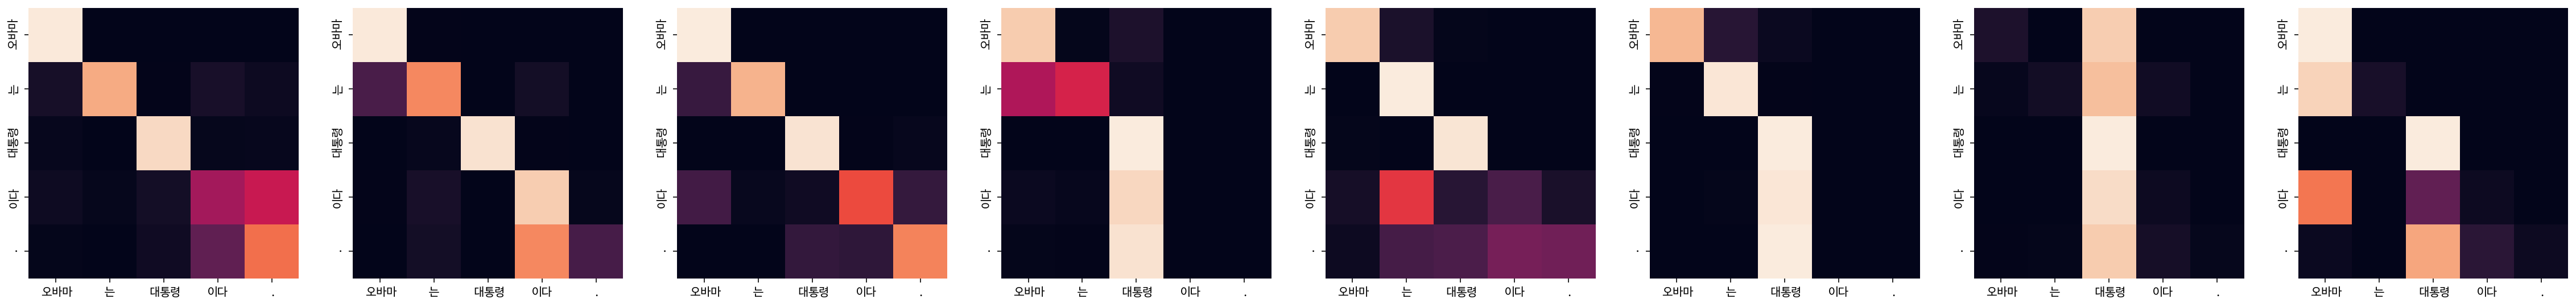

Encoder Layer 5


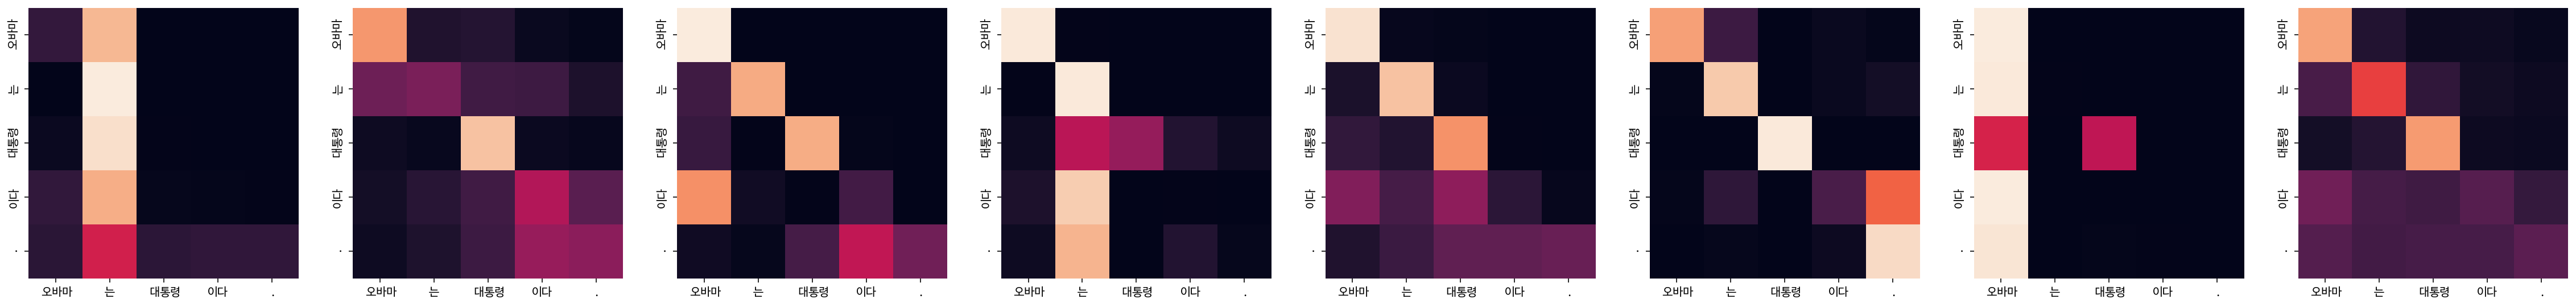

Encoder Layer 6


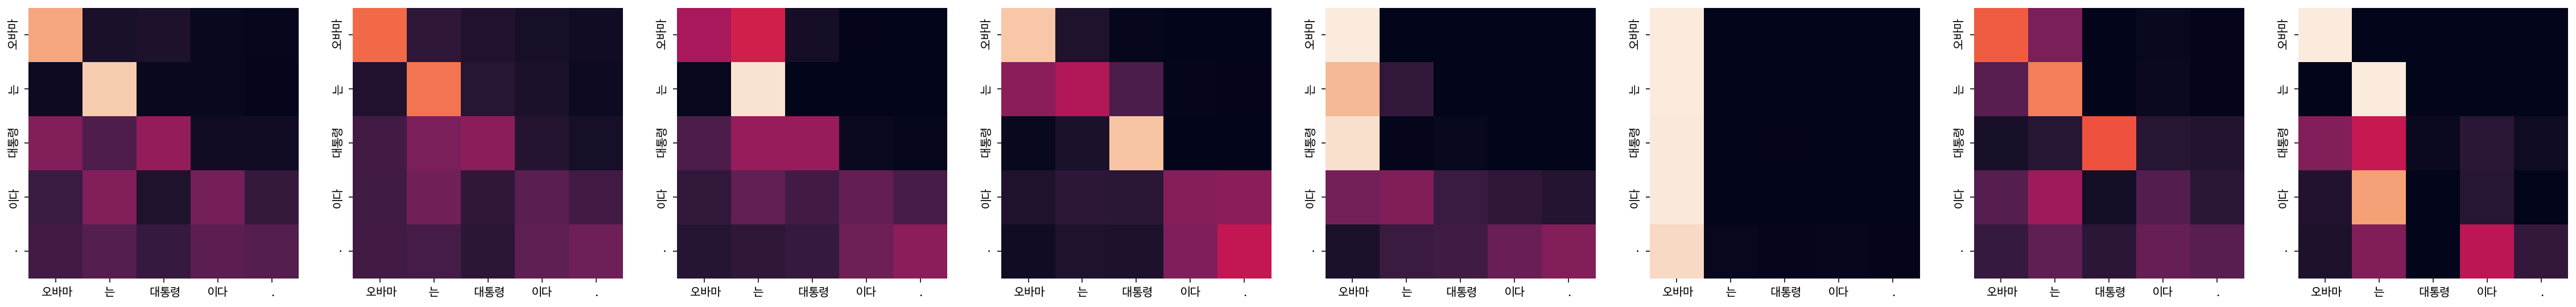

Decoder Self Layer 1


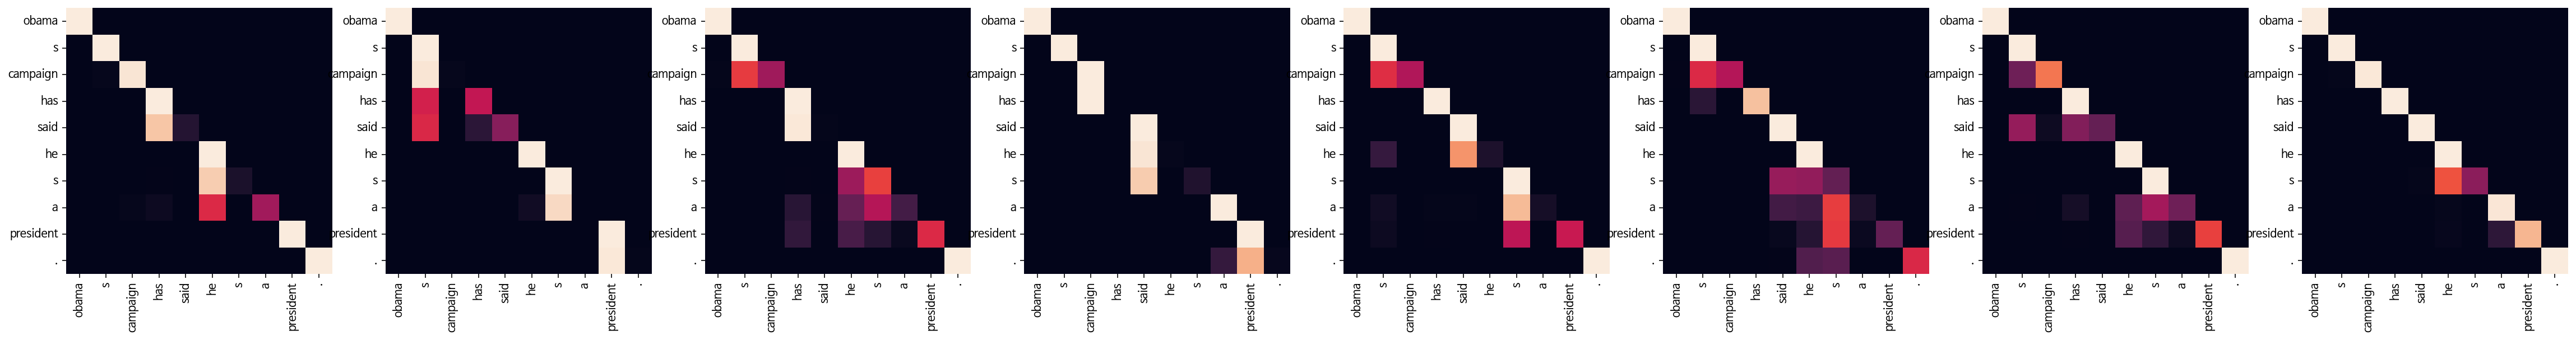

Decoder Src Layer 1


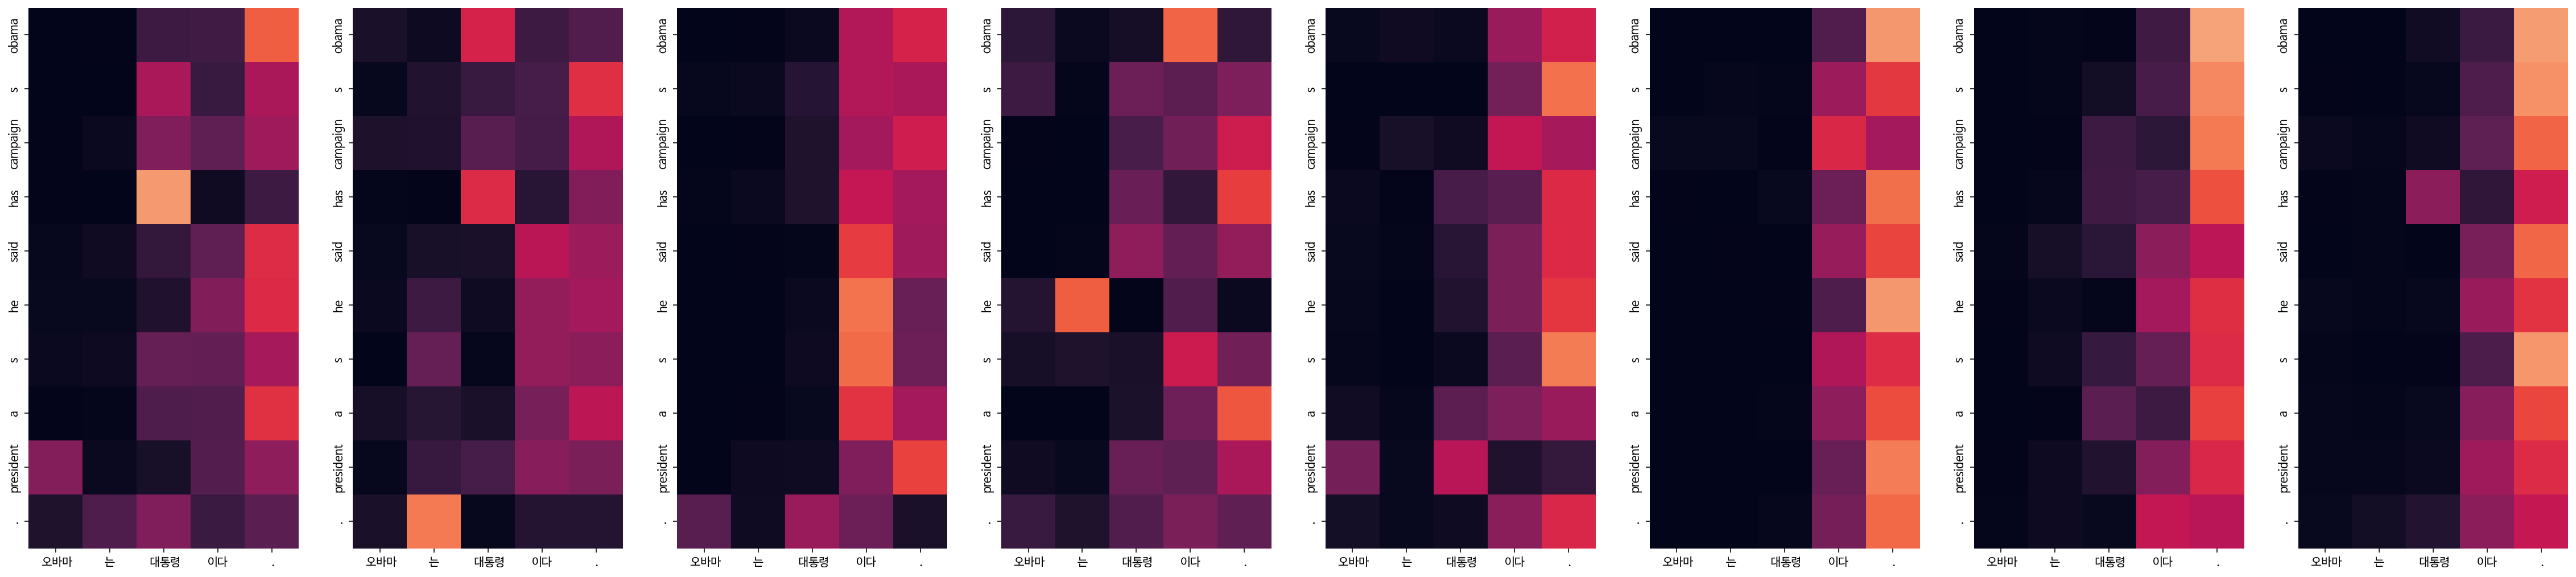

Decoder Self Layer 2


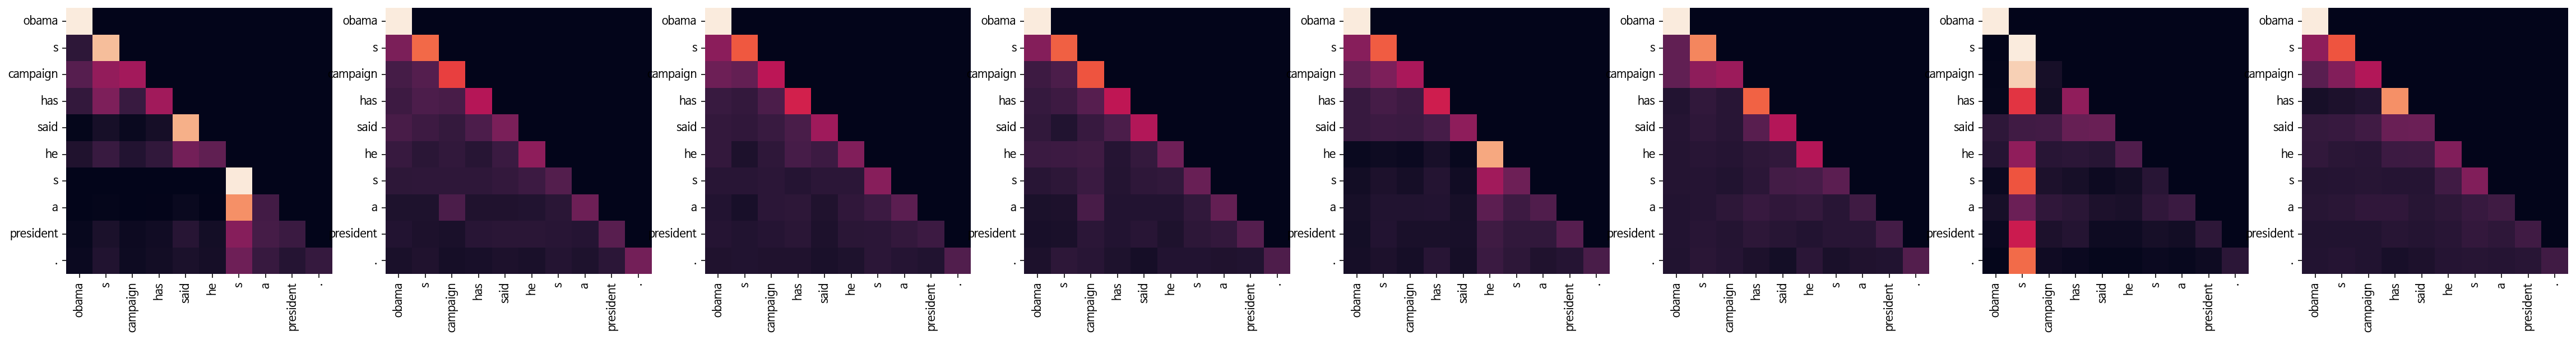

Decoder Src Layer 2


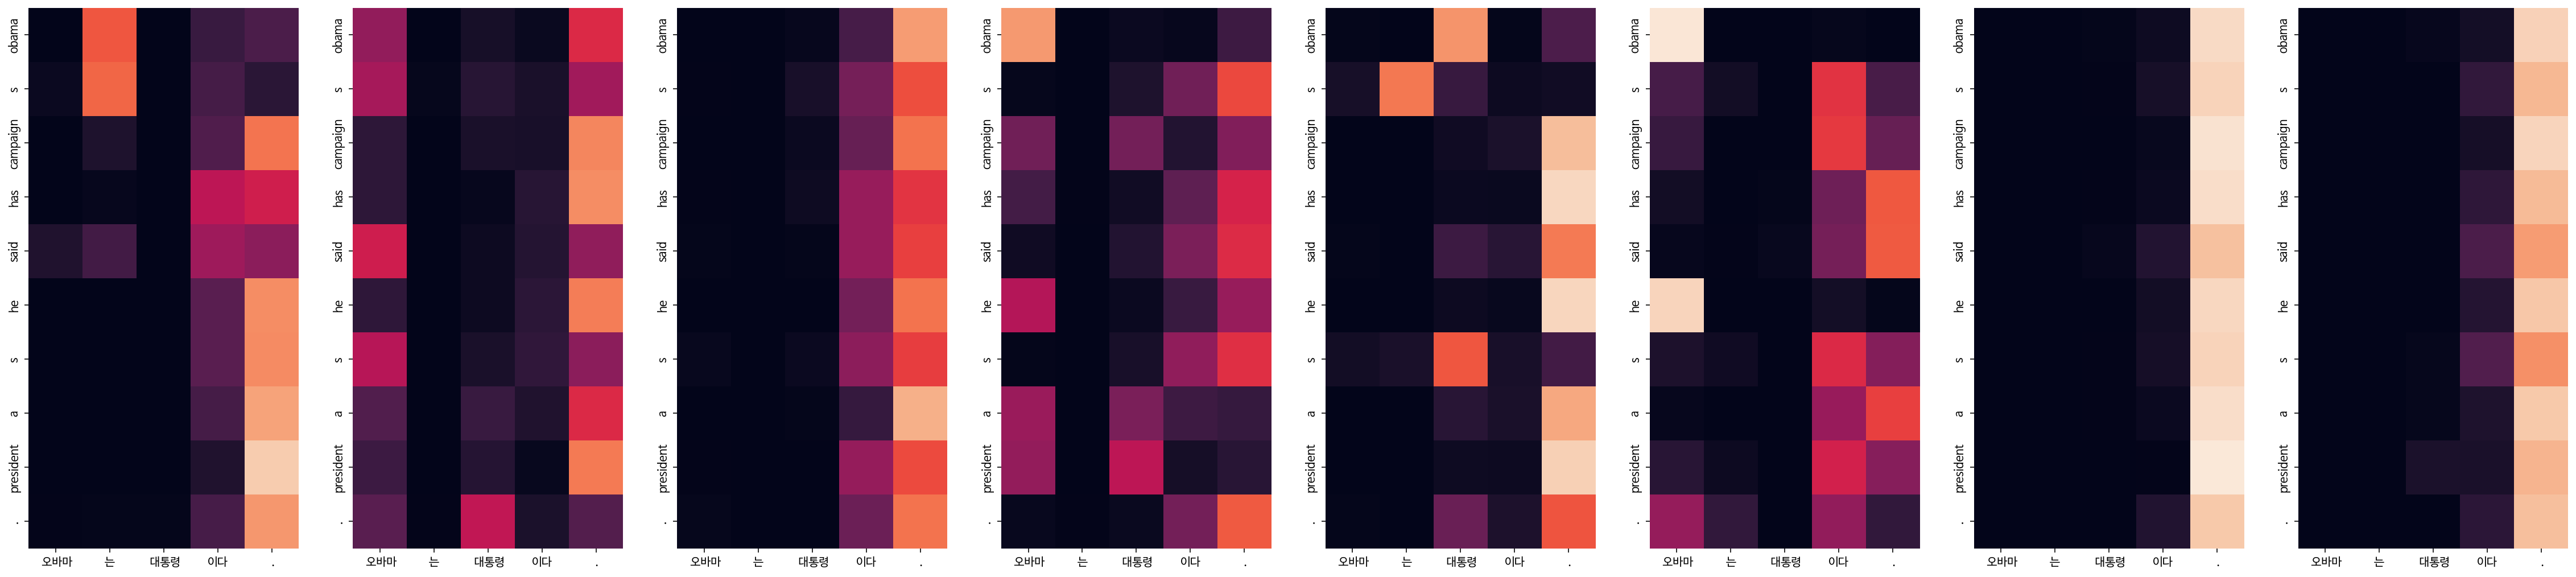

Decoder Self Layer 3


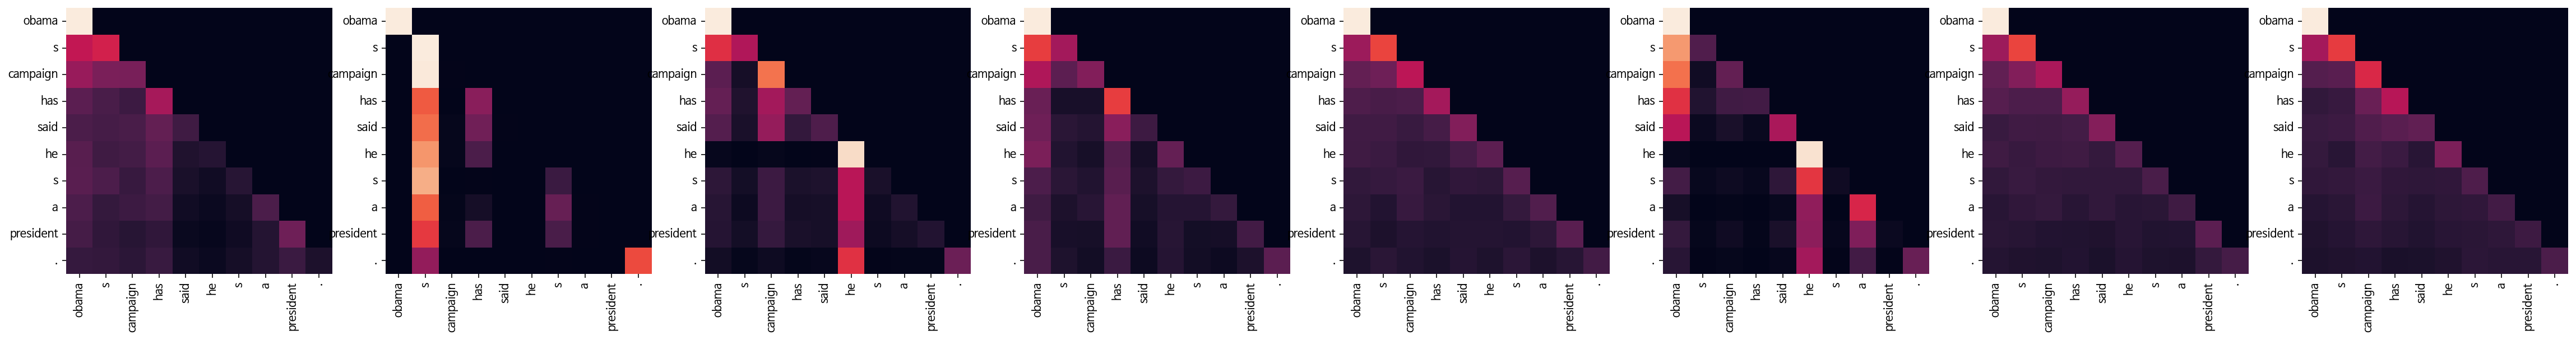

Decoder Src Layer 3


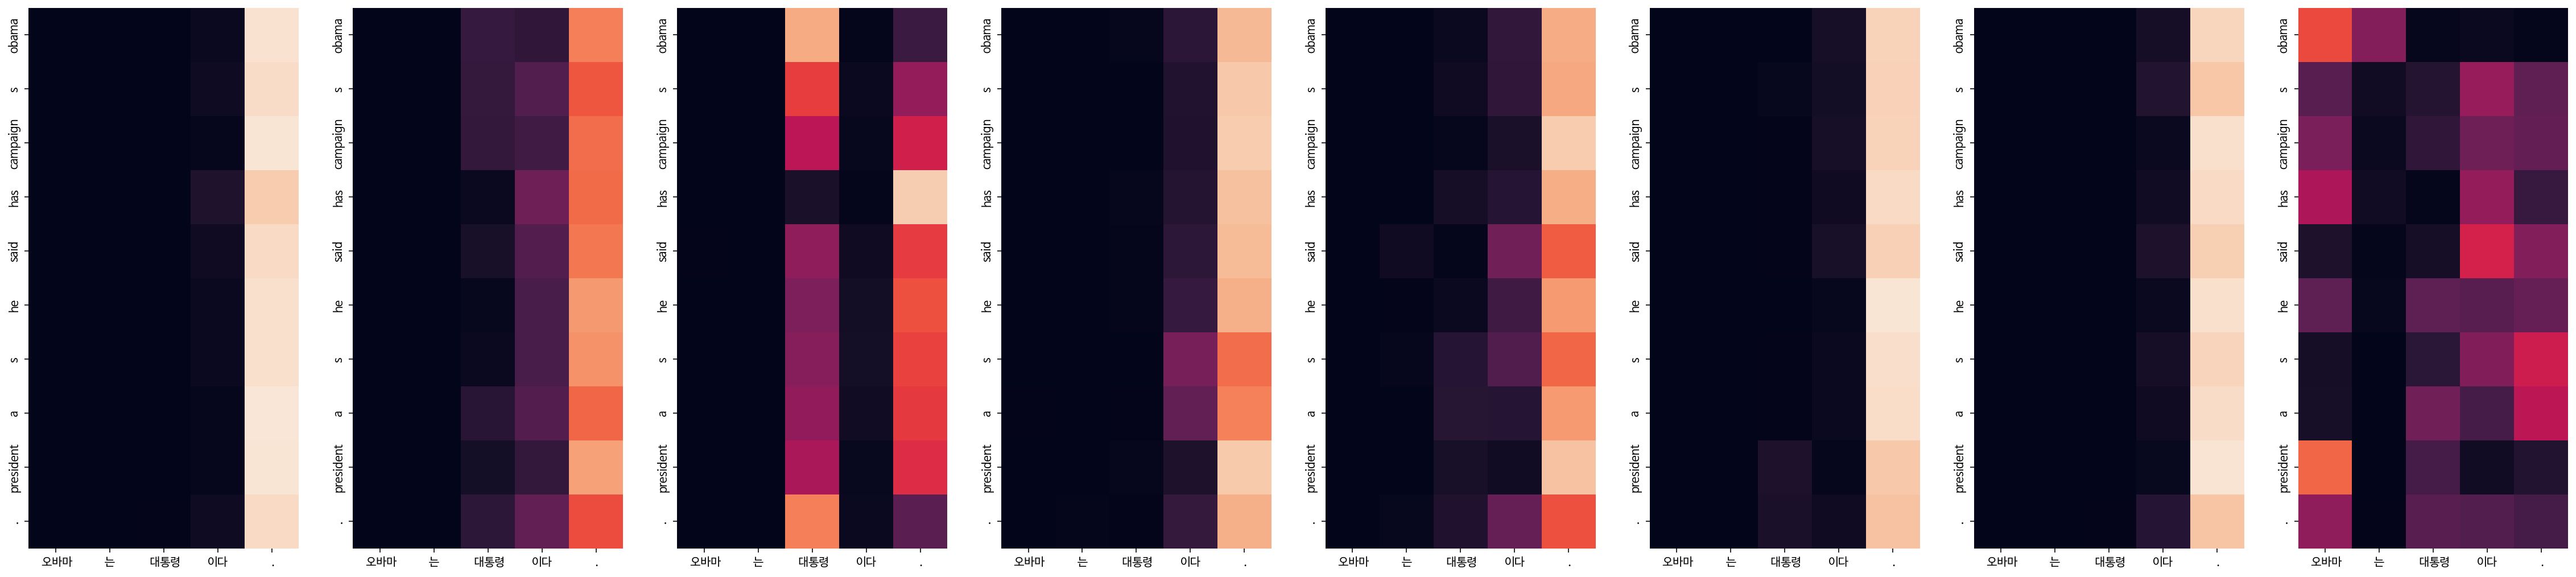

Decoder Self Layer 4


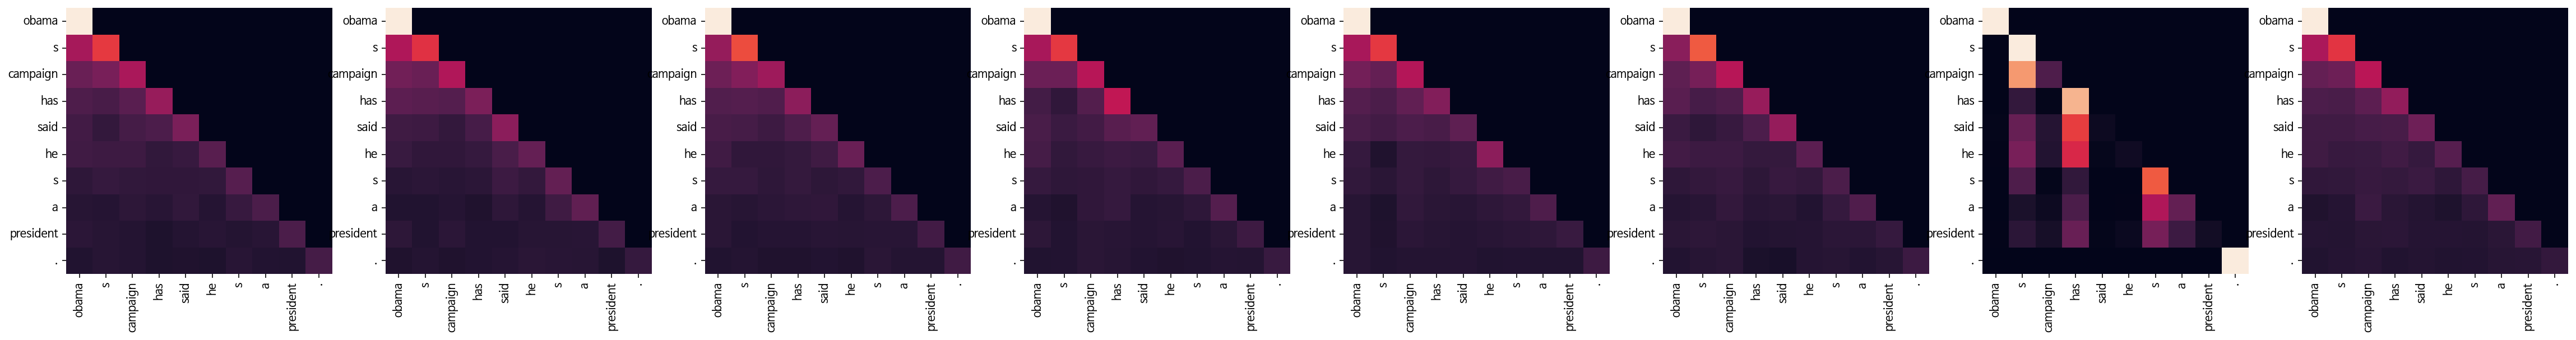

Decoder Src Layer 4


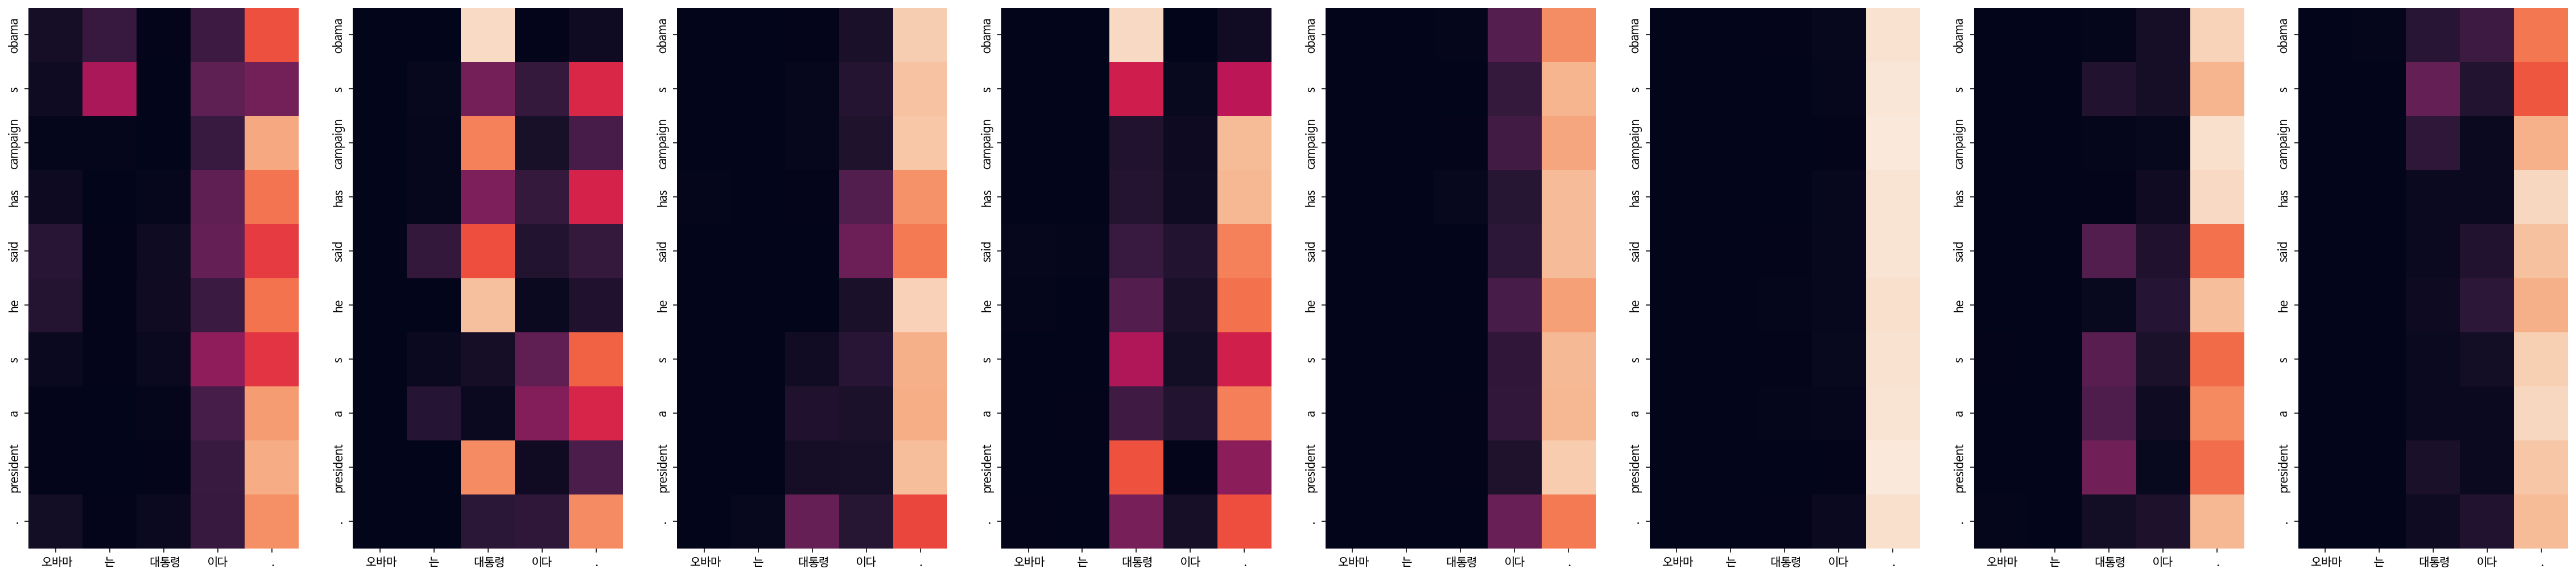

Decoder Self Layer 5


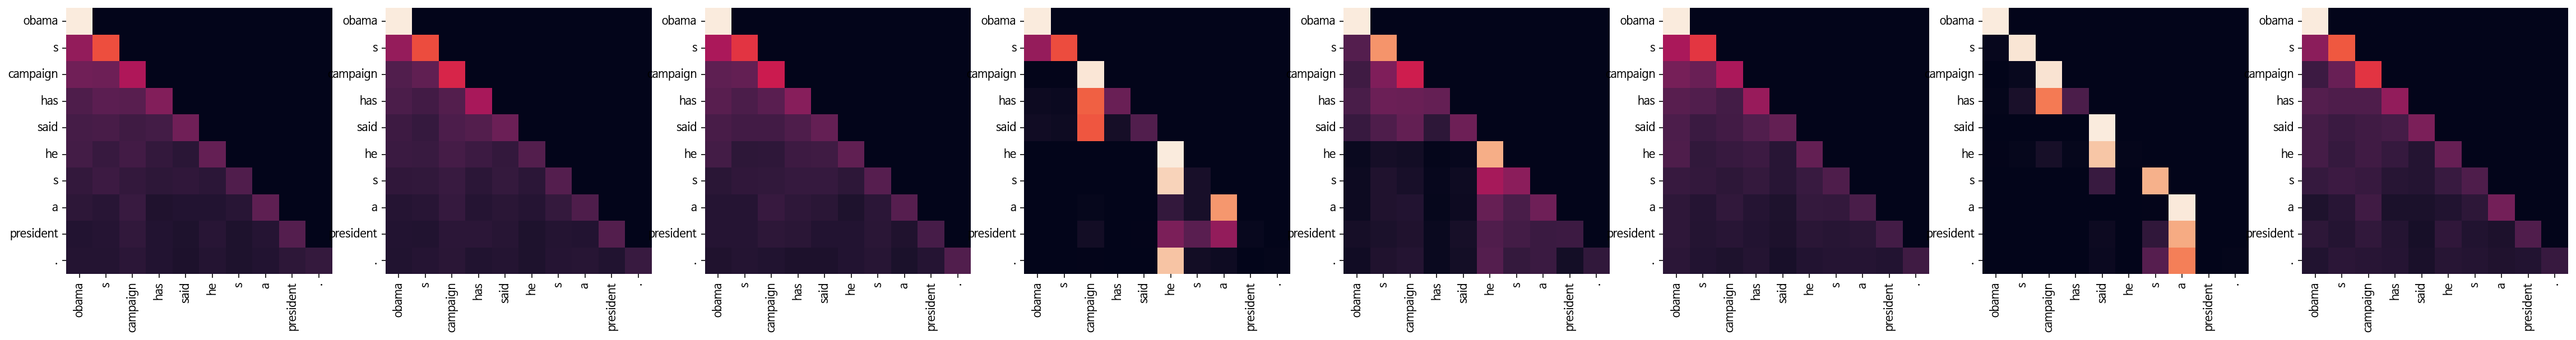

Decoder Src Layer 5


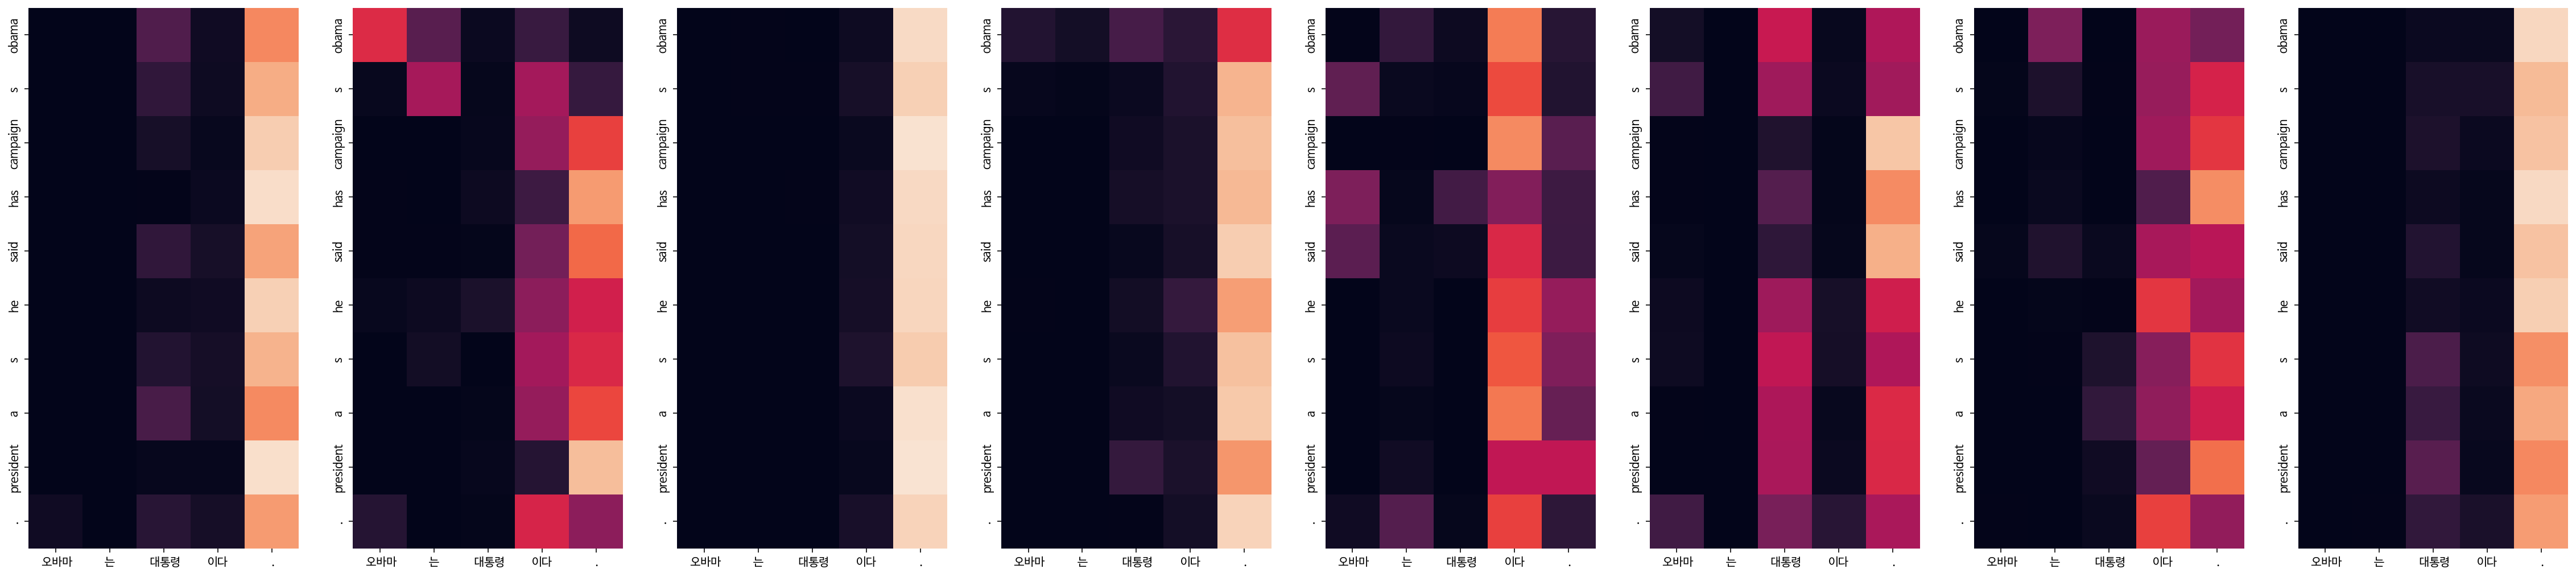

Decoder Self Layer 6


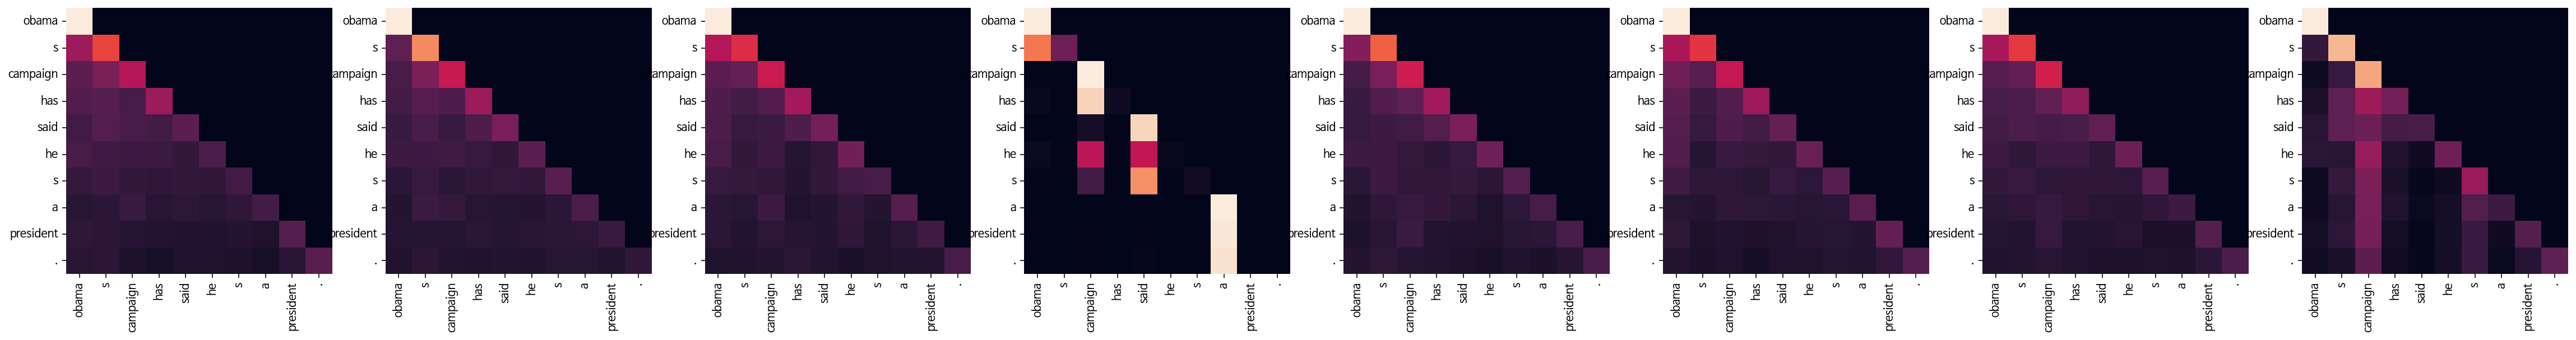

Decoder Src Layer 6


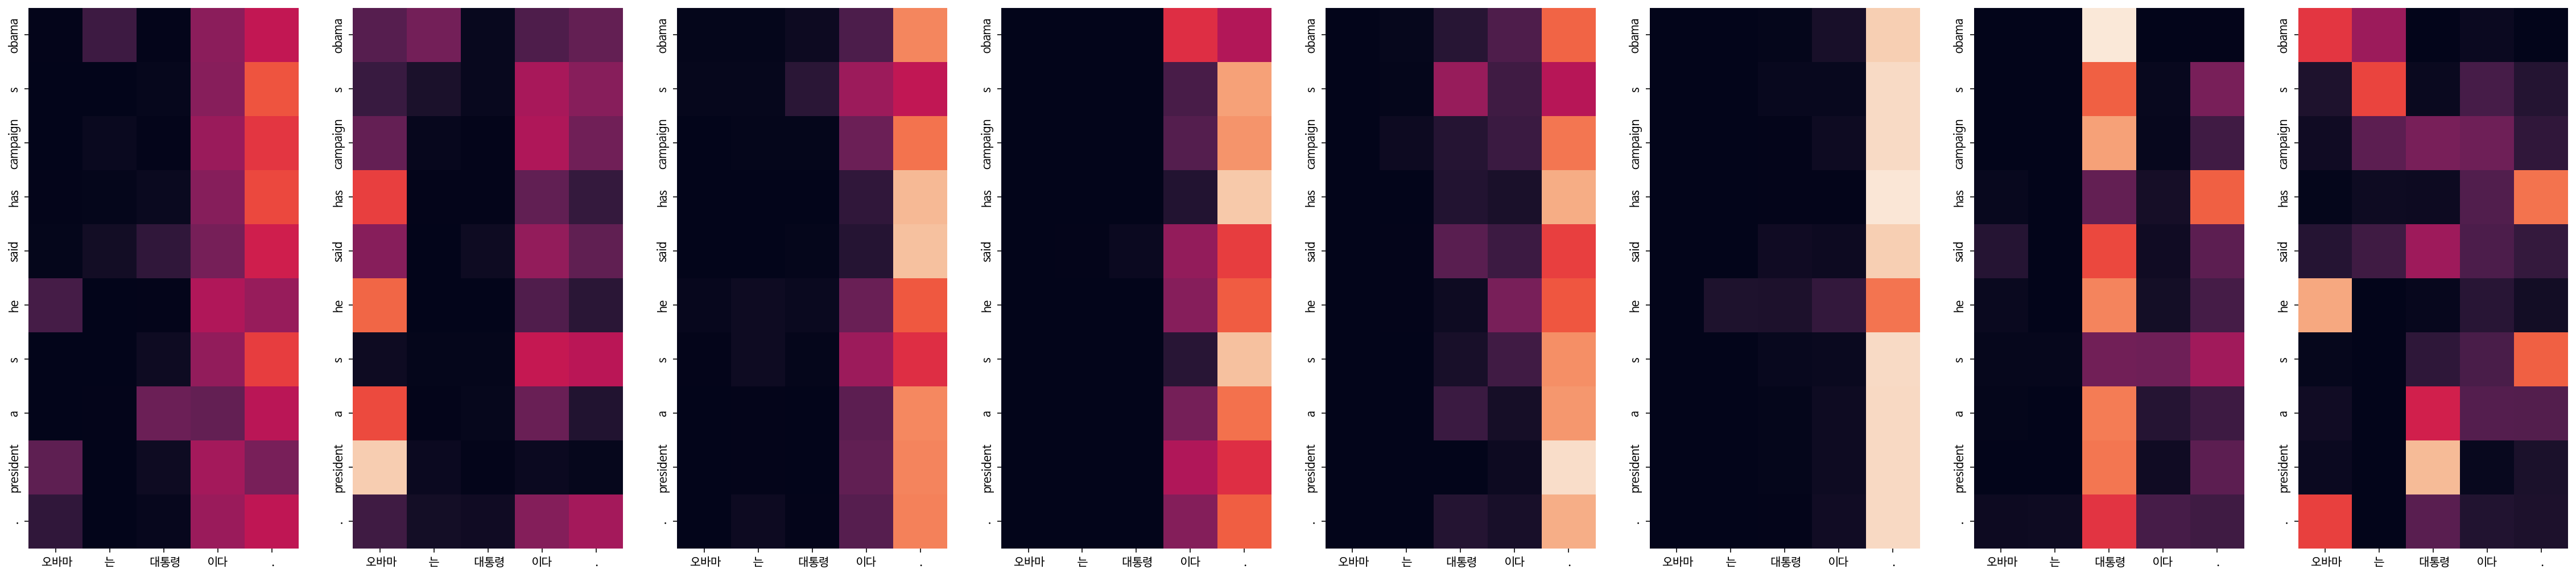

In [221]:
translate("오바마는 대통령이다.", transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Input: 시민들은 도시 속에 산다.
Predicted translation: the people living in the house are vacant .
Encoder Layer 1


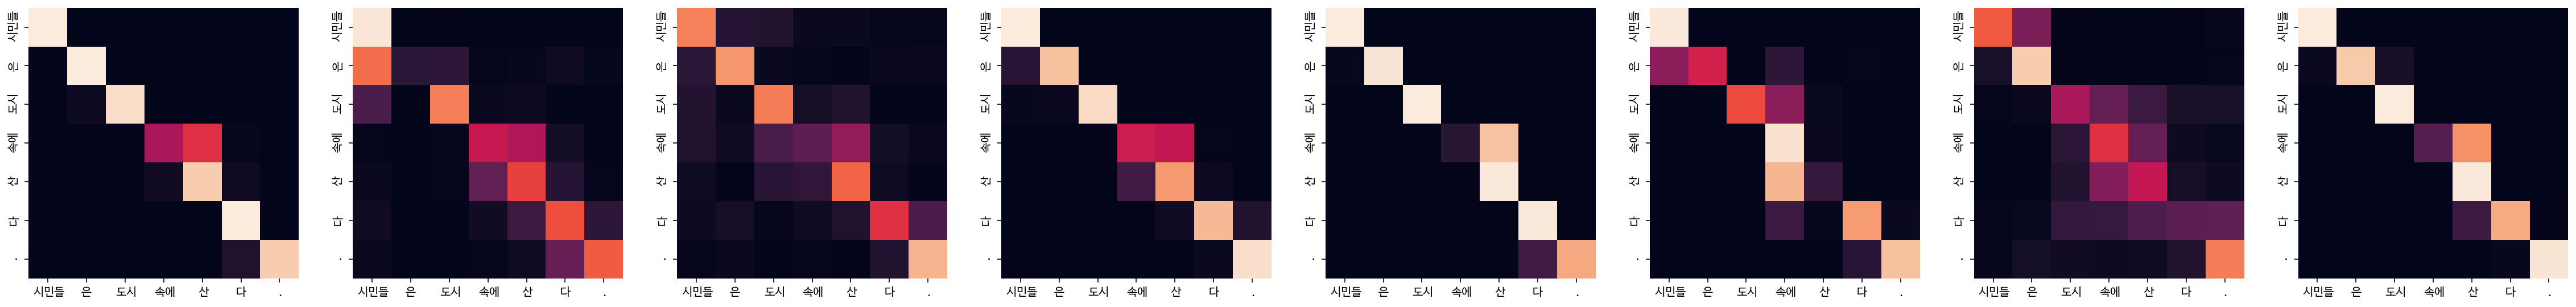

Encoder Layer 2


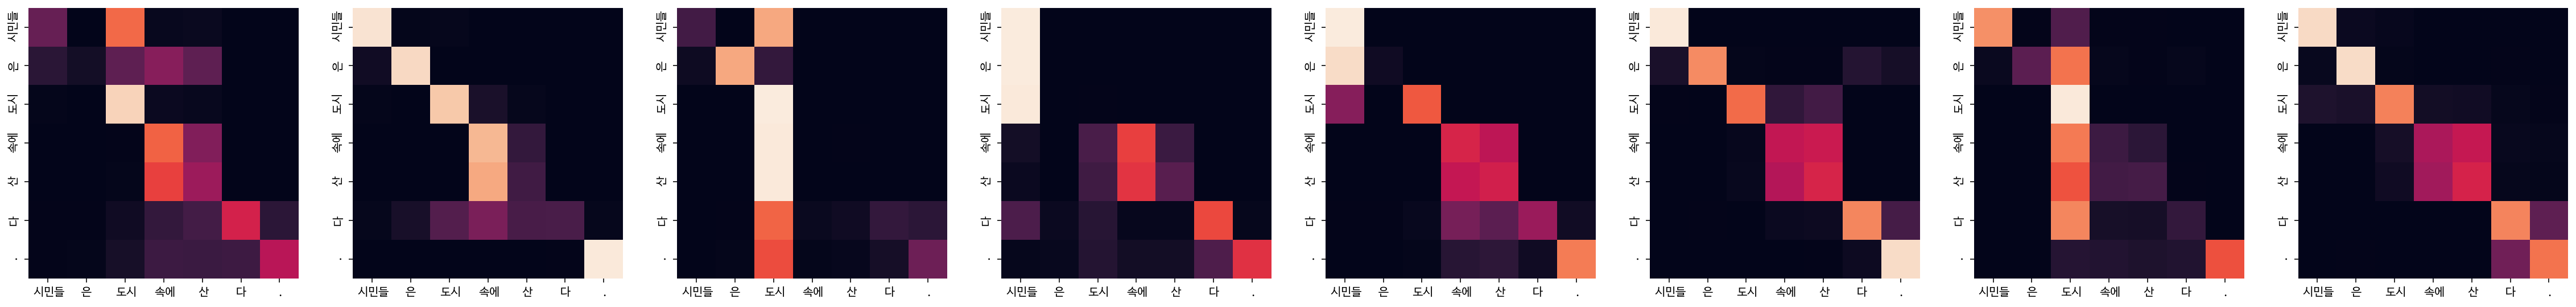

Encoder Layer 3


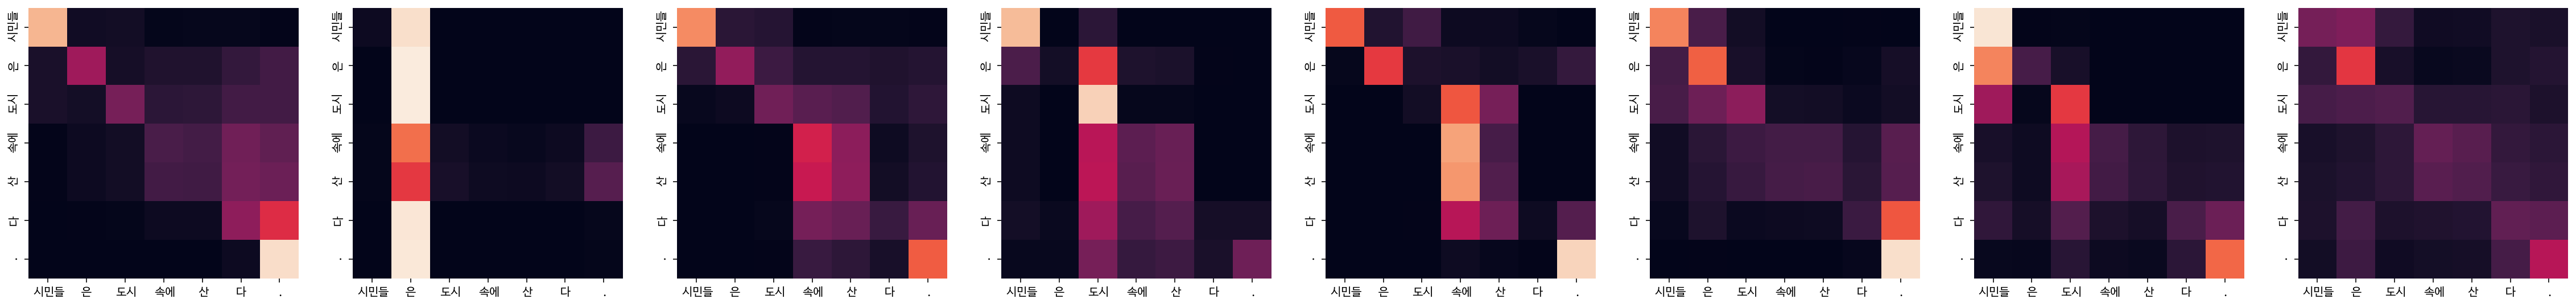

Encoder Layer 4


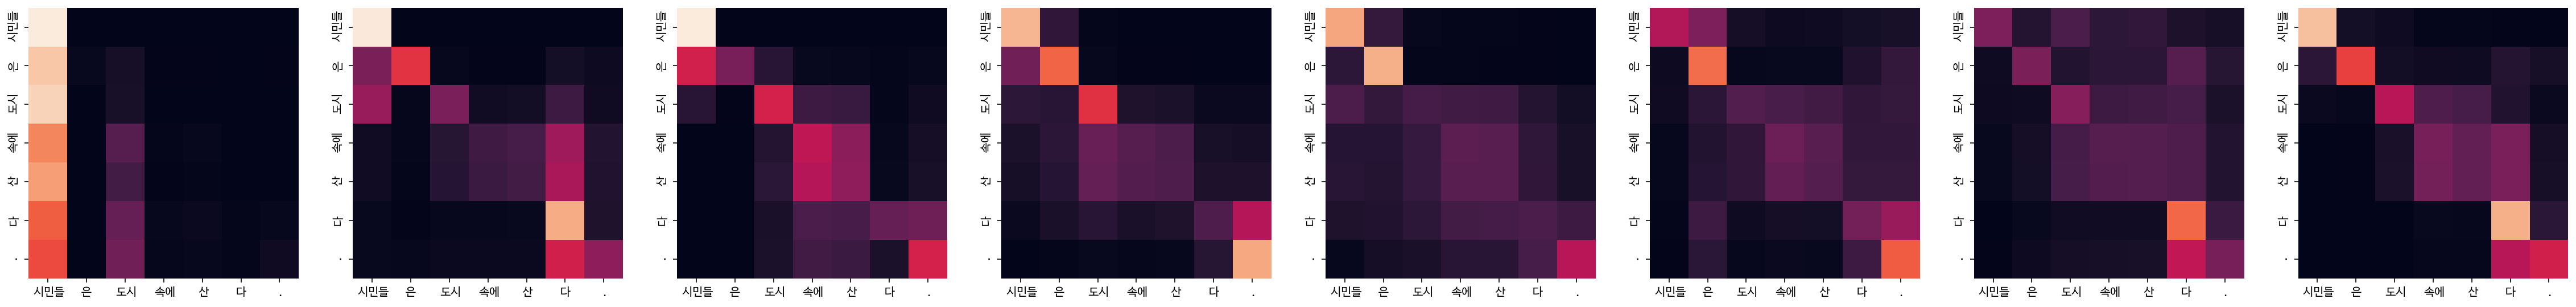

Encoder Layer 5


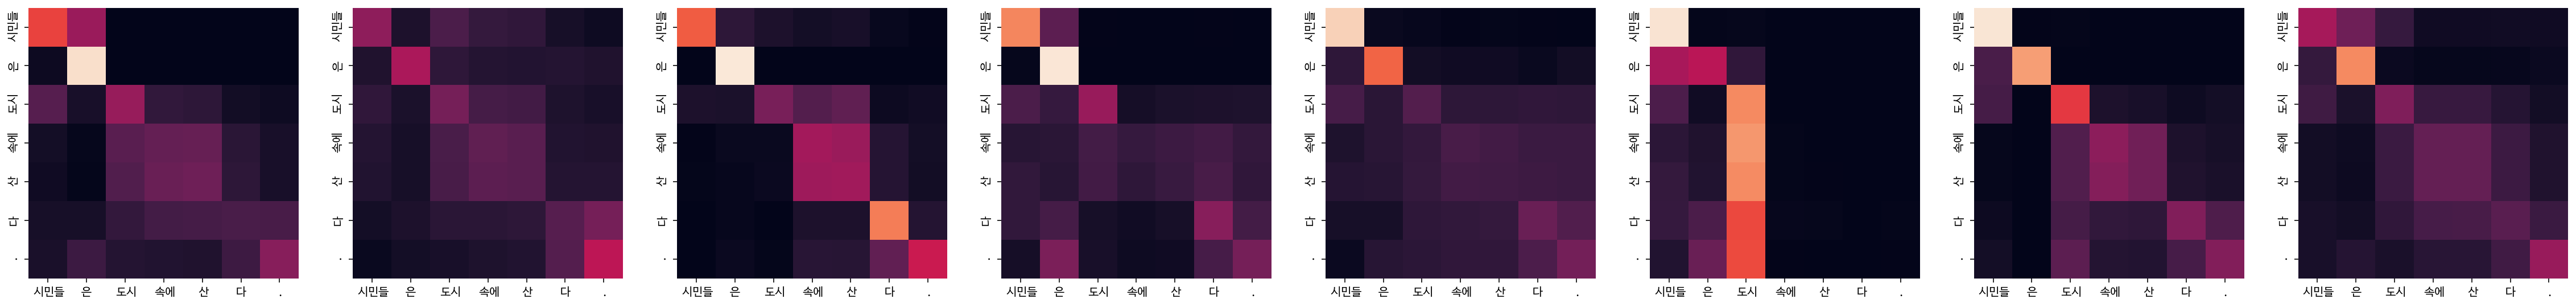

Encoder Layer 6


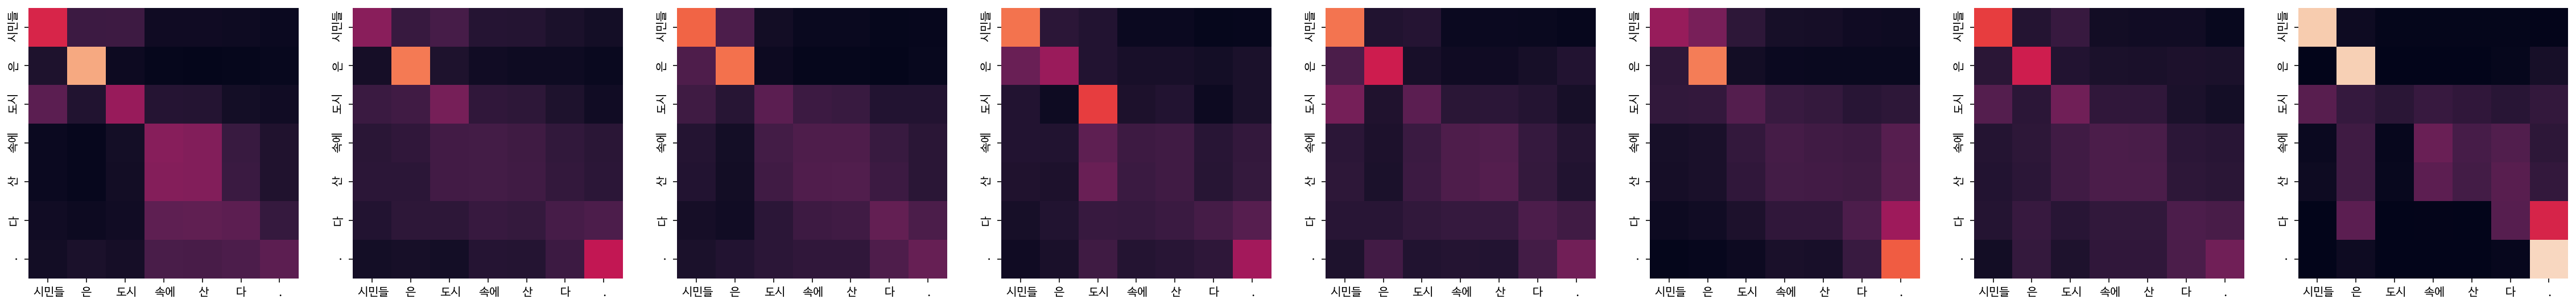

Decoder Self Layer 1


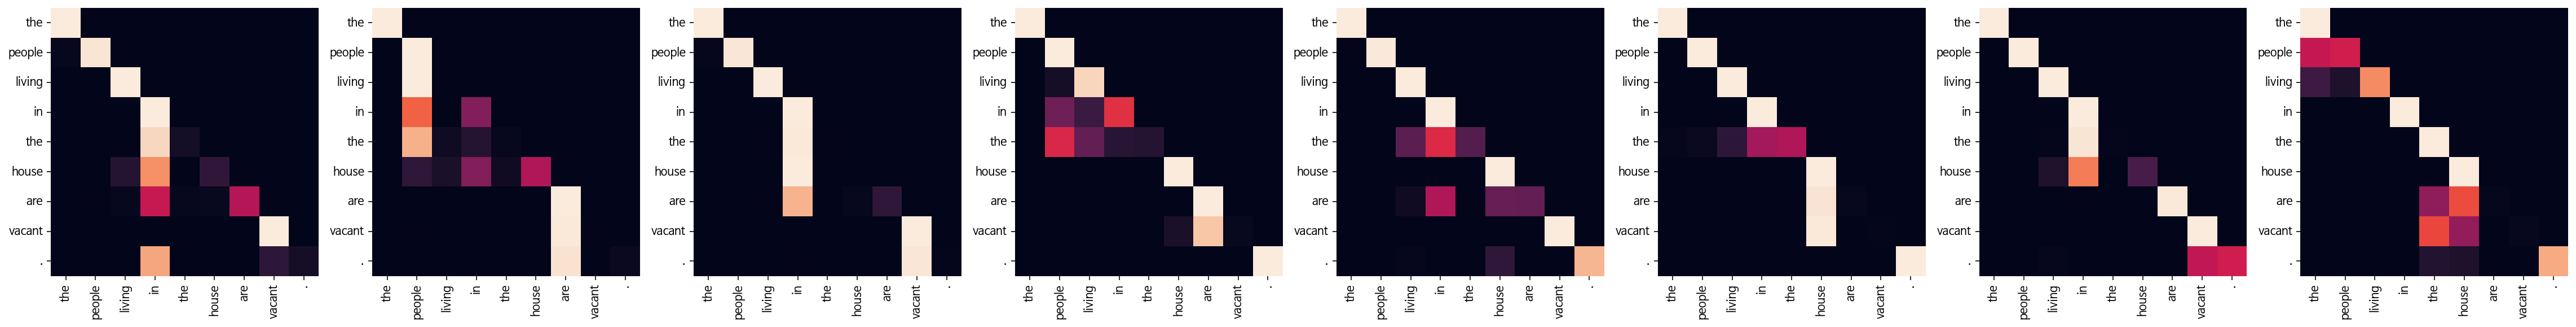

Decoder Src Layer 1


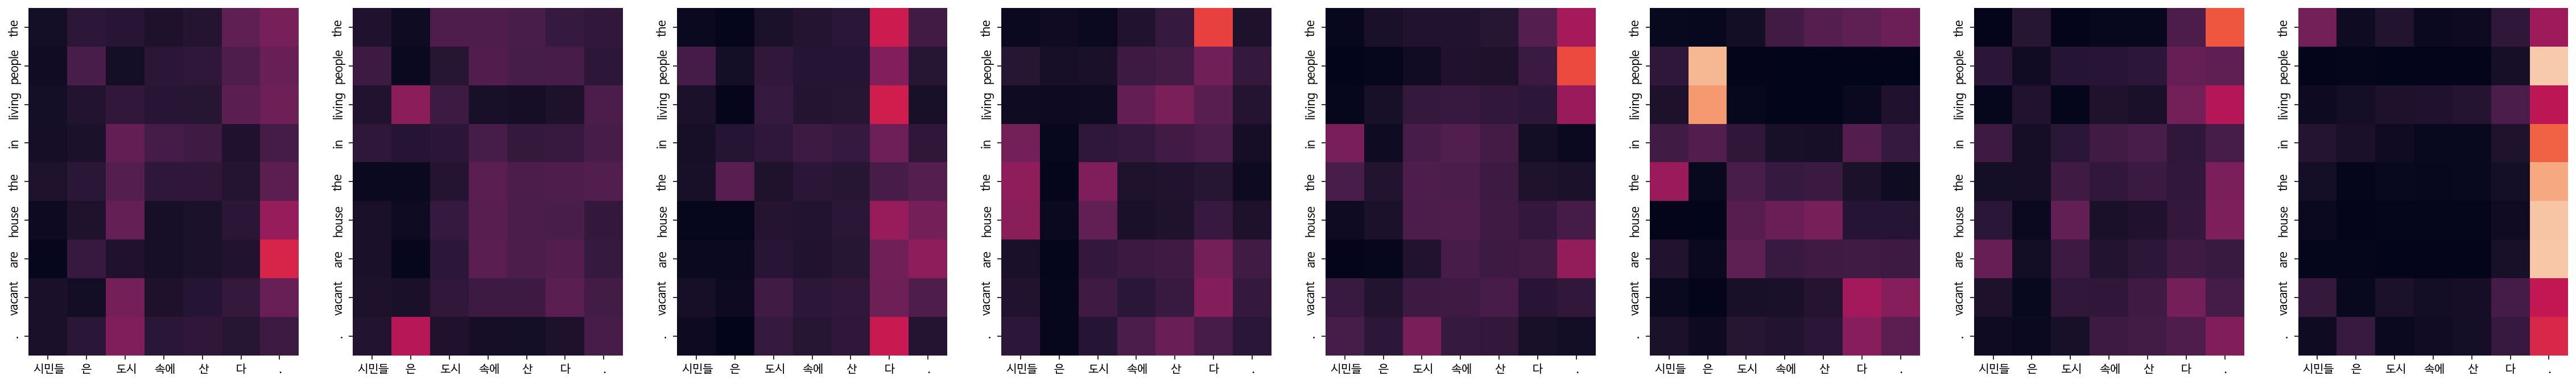

Decoder Self Layer 2


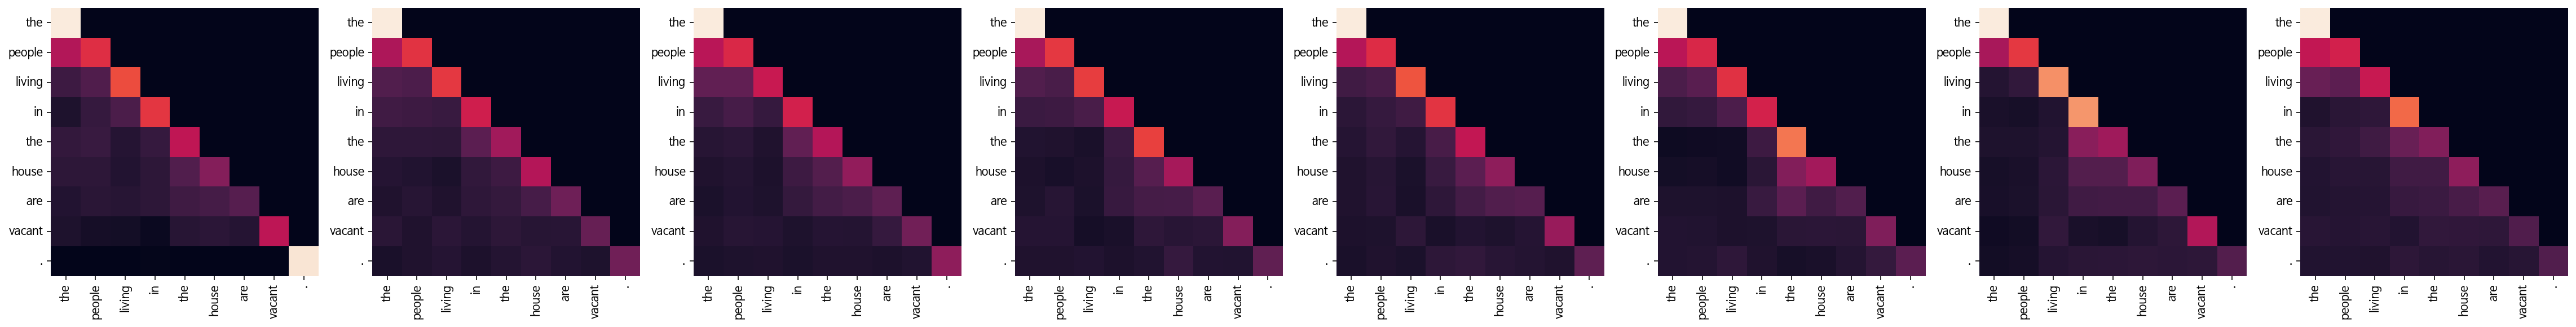

Decoder Src Layer 2


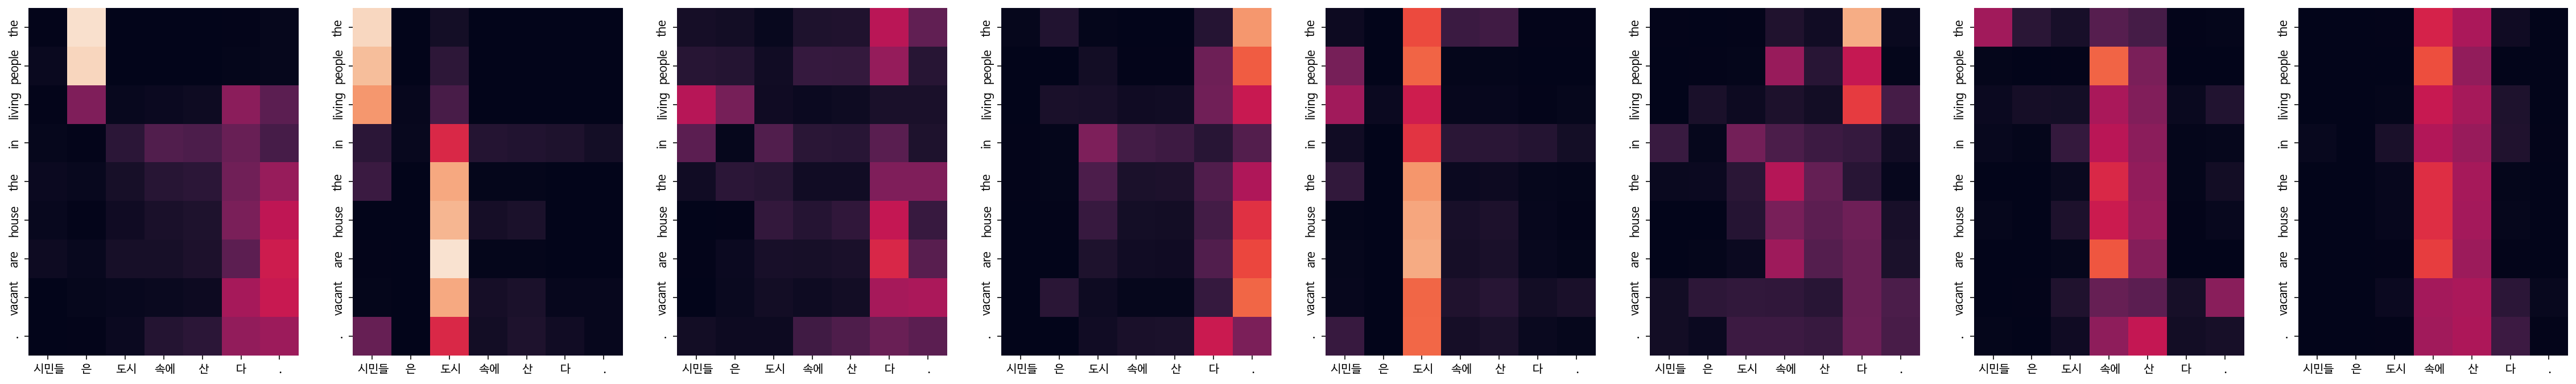

Decoder Self Layer 3


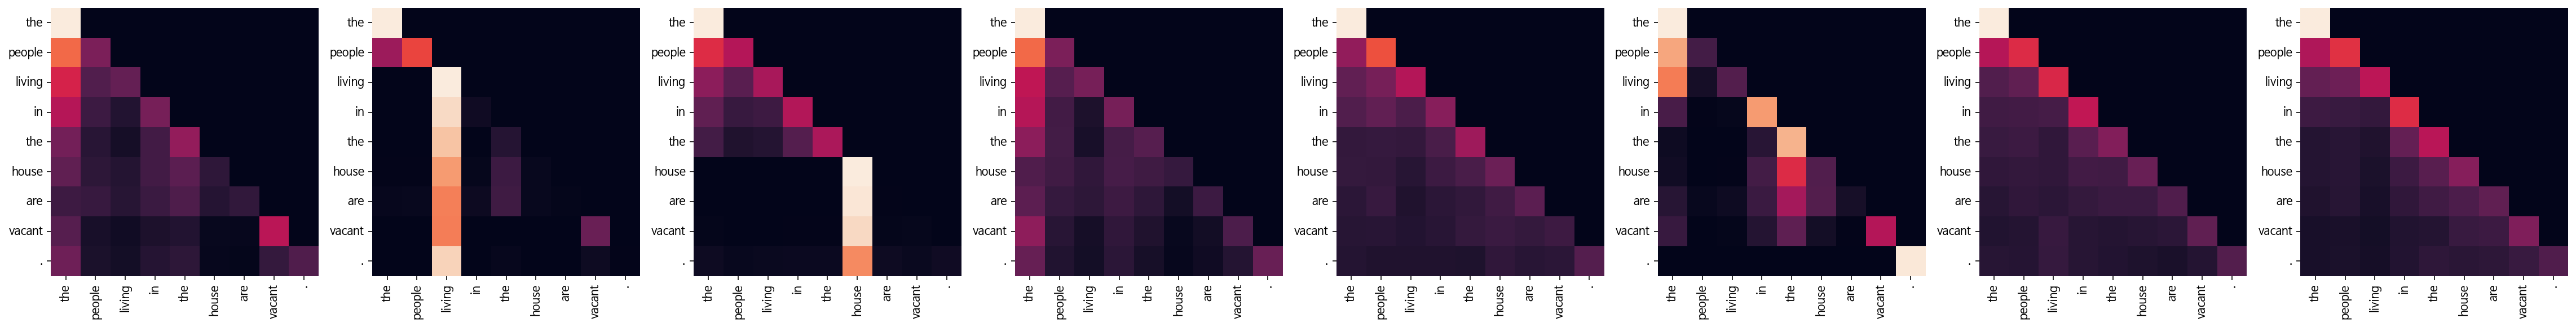

Decoder Src Layer 3


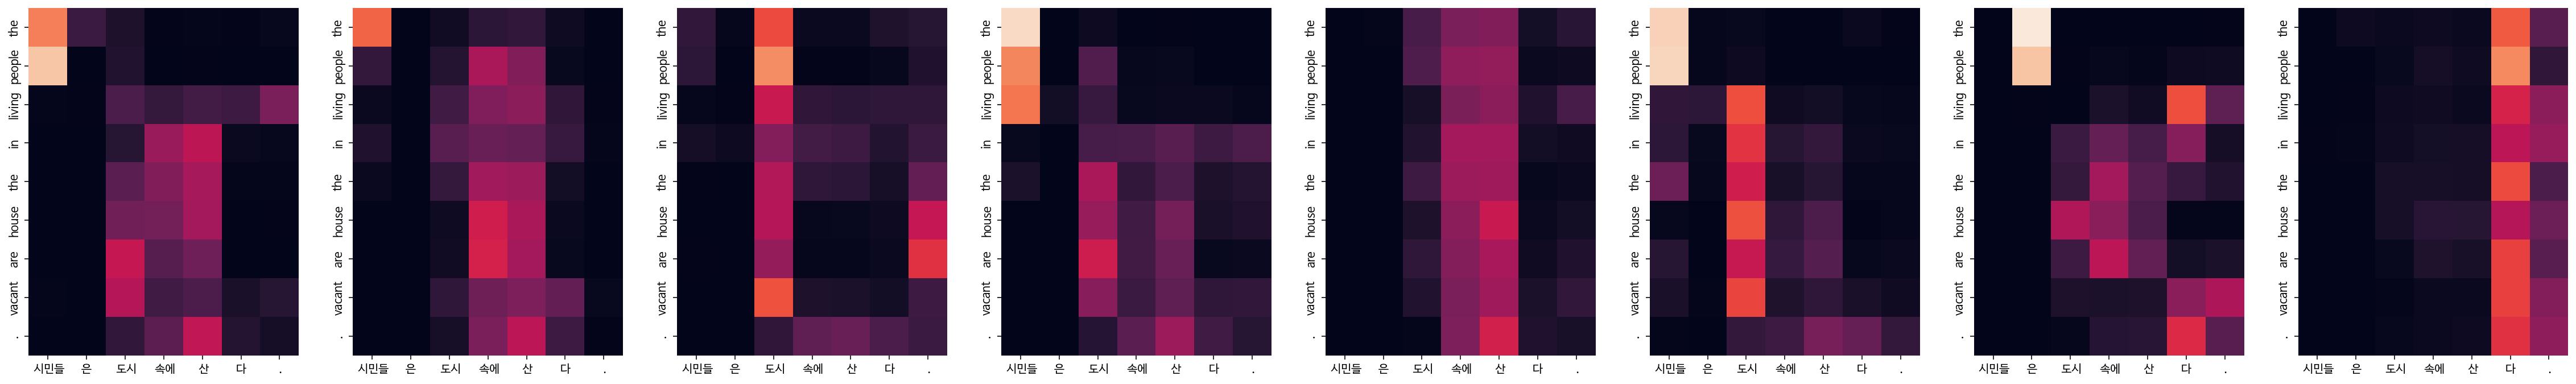

Decoder Self Layer 4


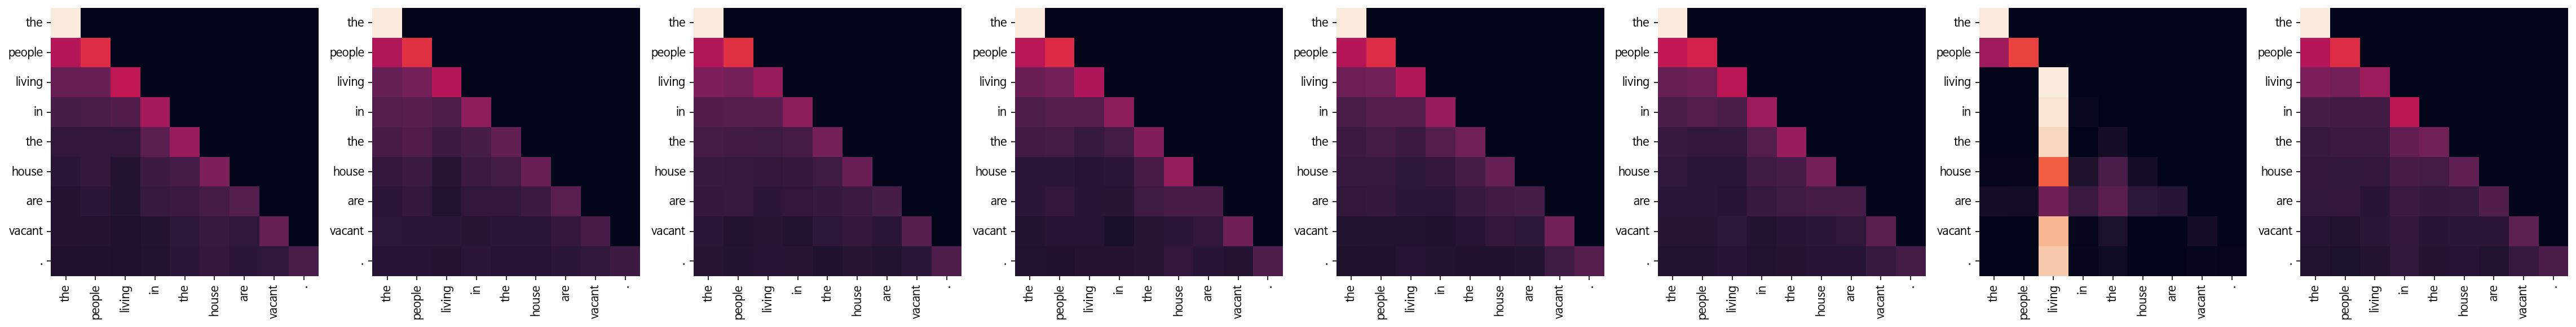

Decoder Src Layer 4


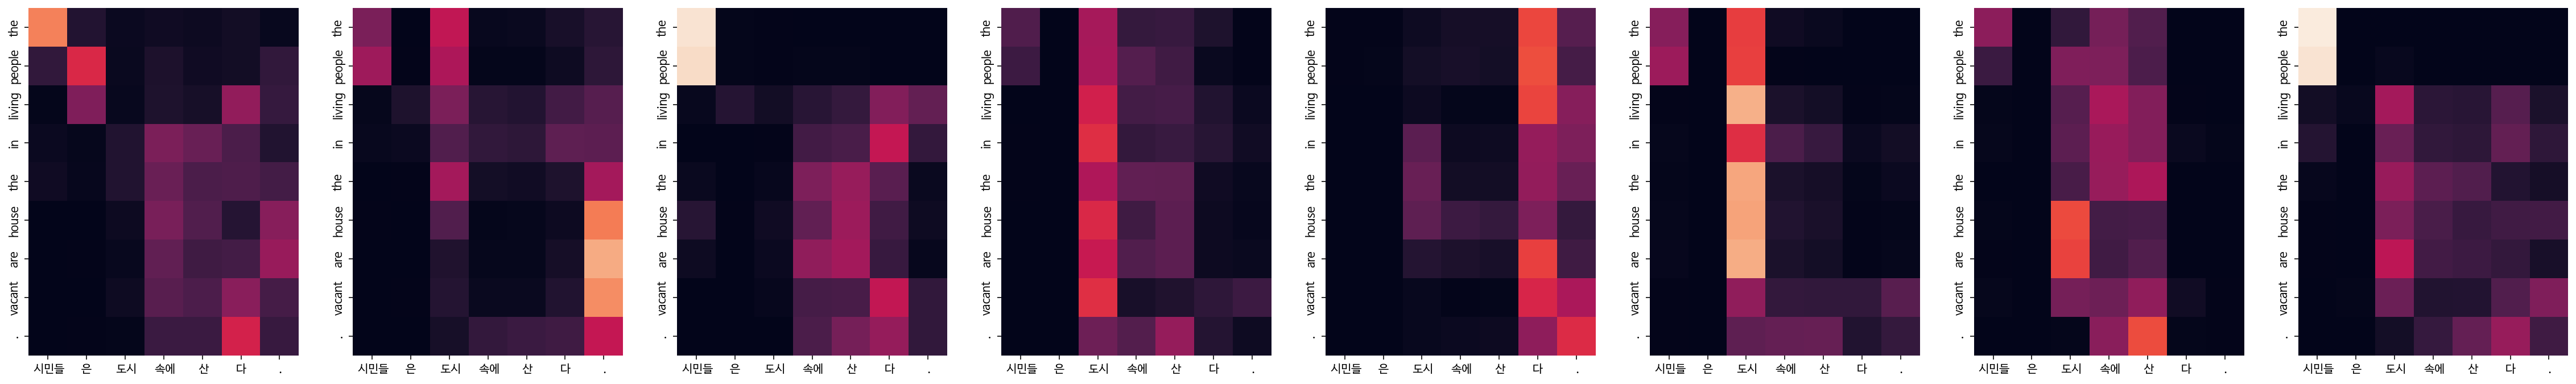

Decoder Self Layer 5


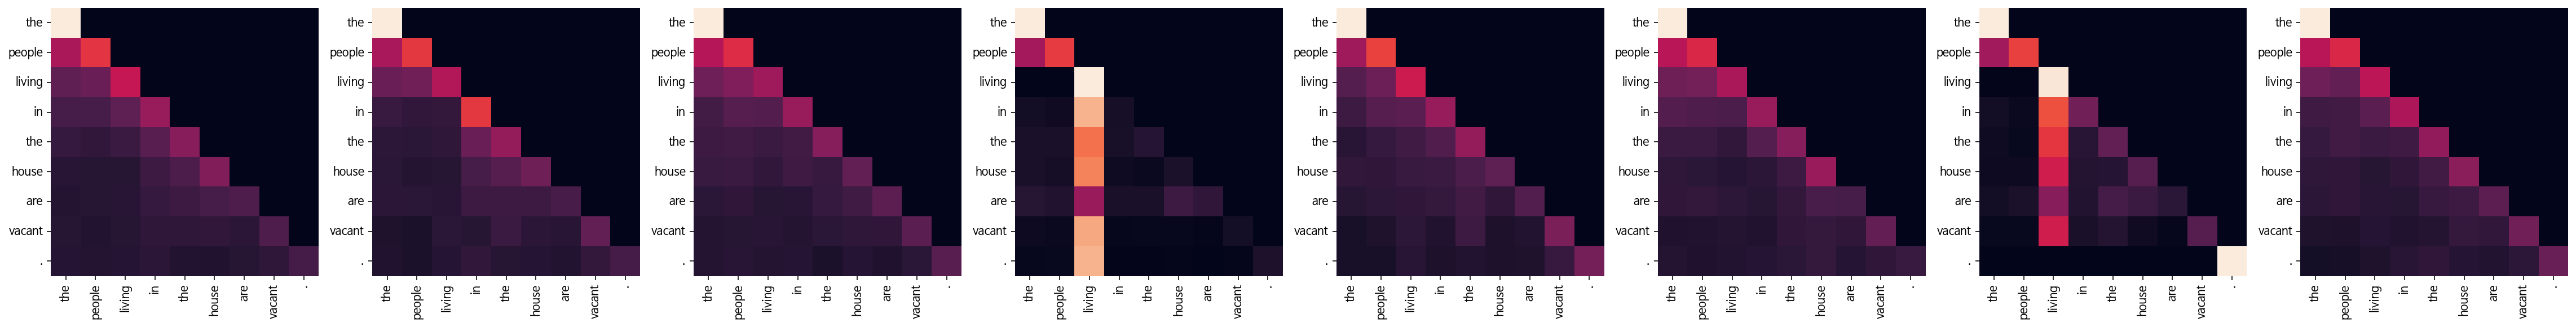

Decoder Src Layer 5


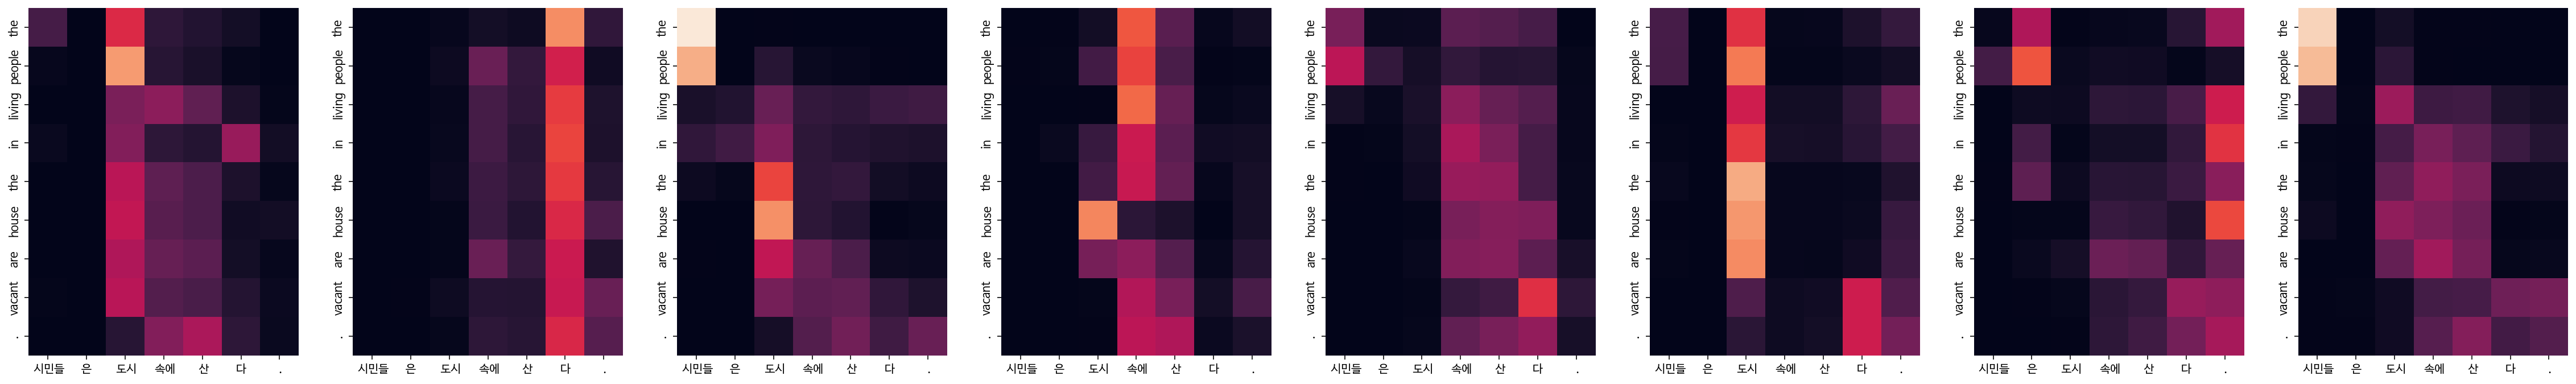

Decoder Self Layer 6


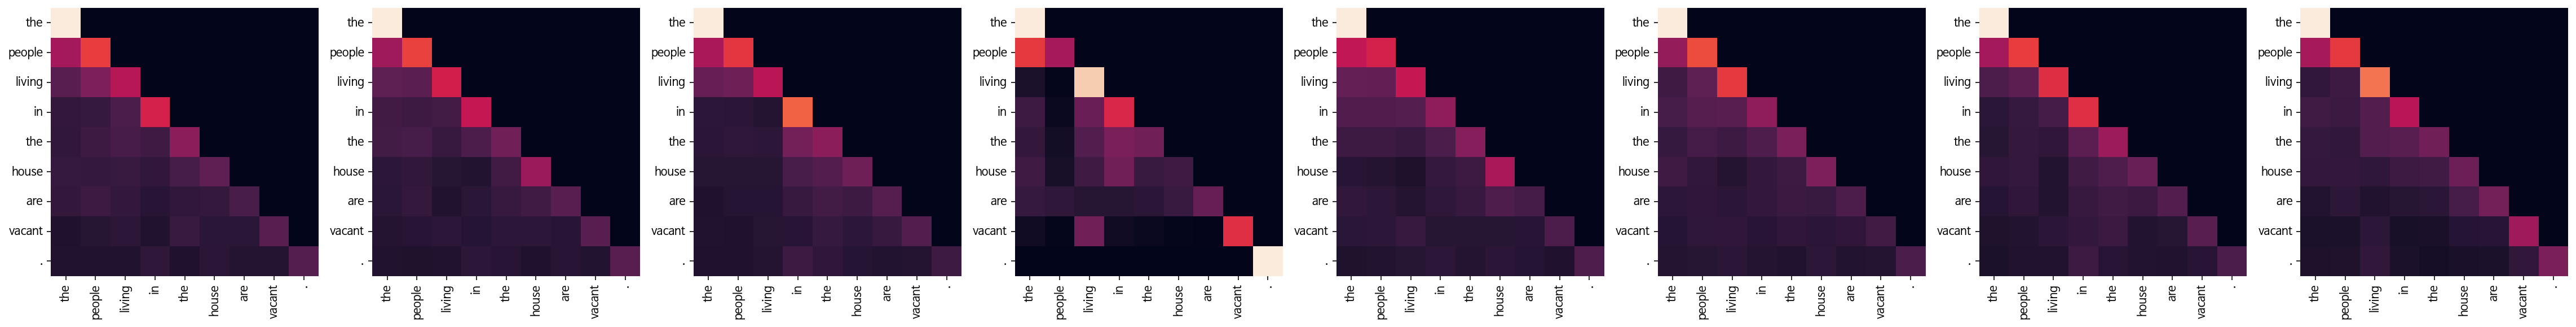

Decoder Src Layer 6


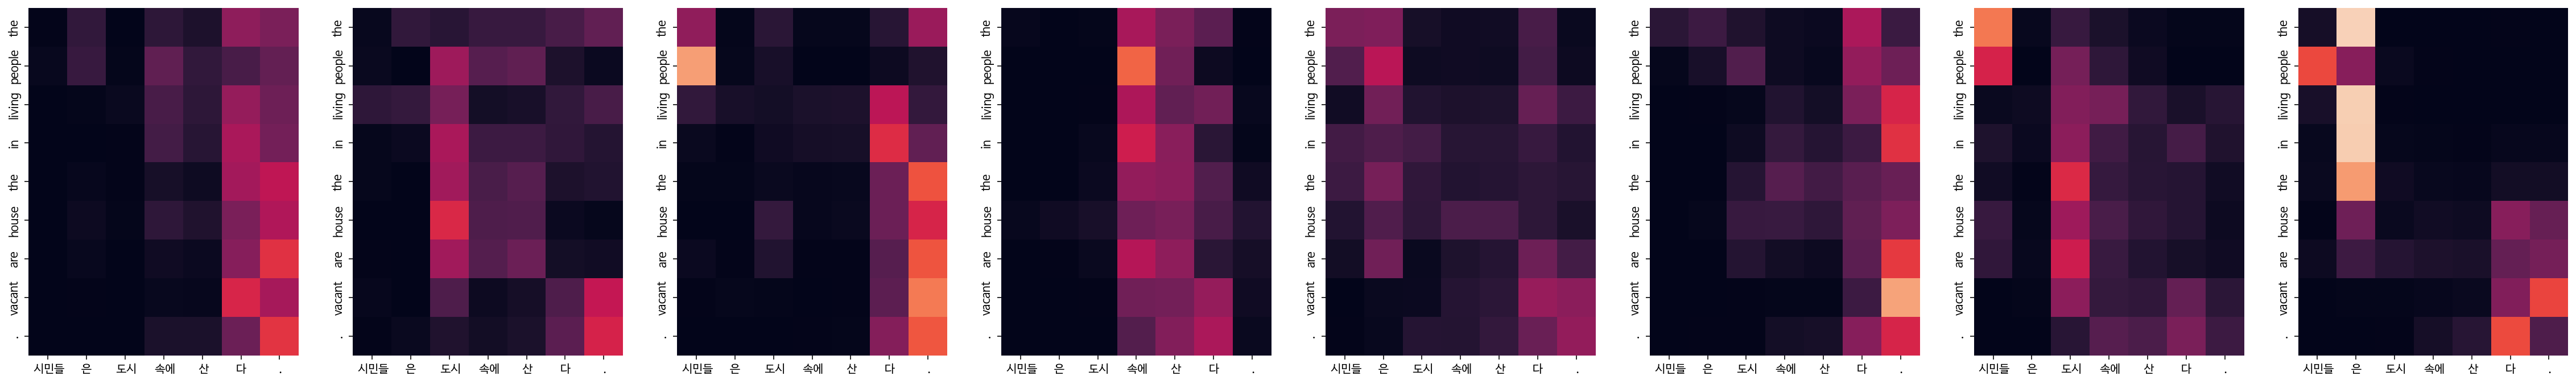

In [222]:
translate("시민들은 도시 속에 산다.", transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Input: 커피는 필요 없다.
Predicted translation: there needs to be a healthy .
Encoder Layer 1


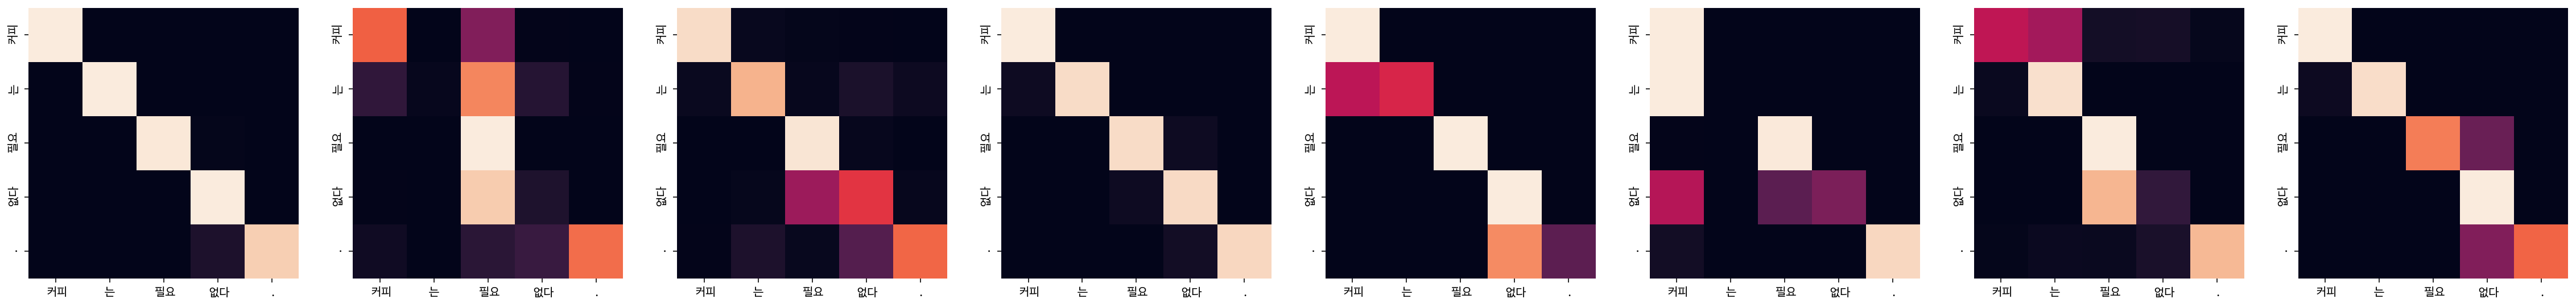

Encoder Layer 2


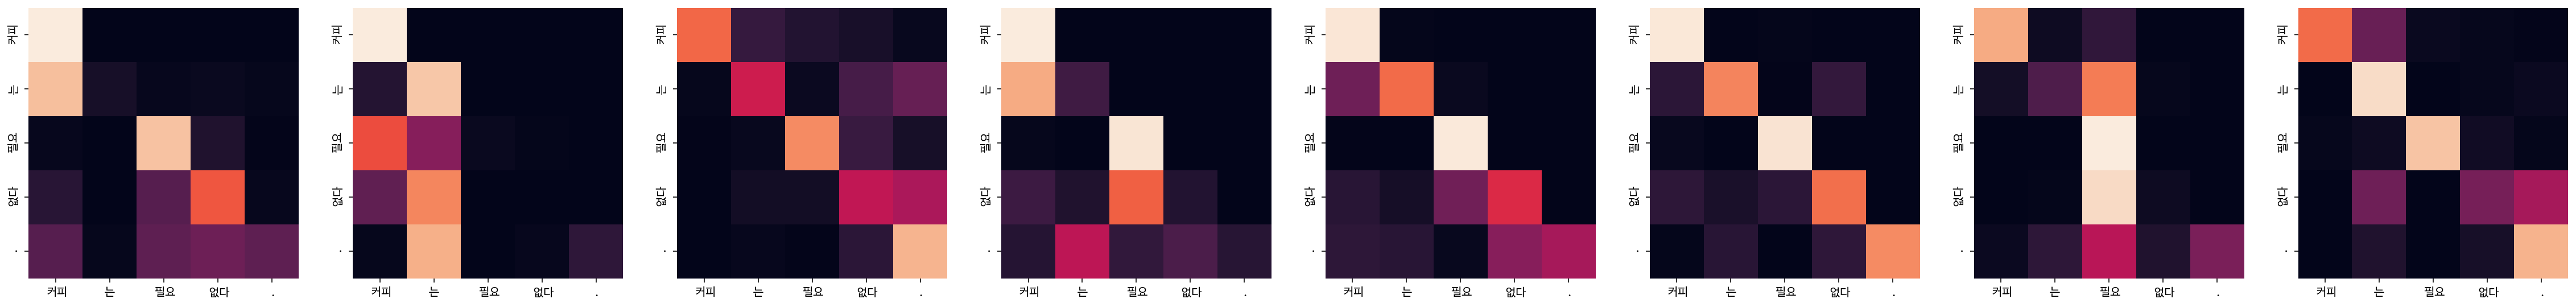

Encoder Layer 3


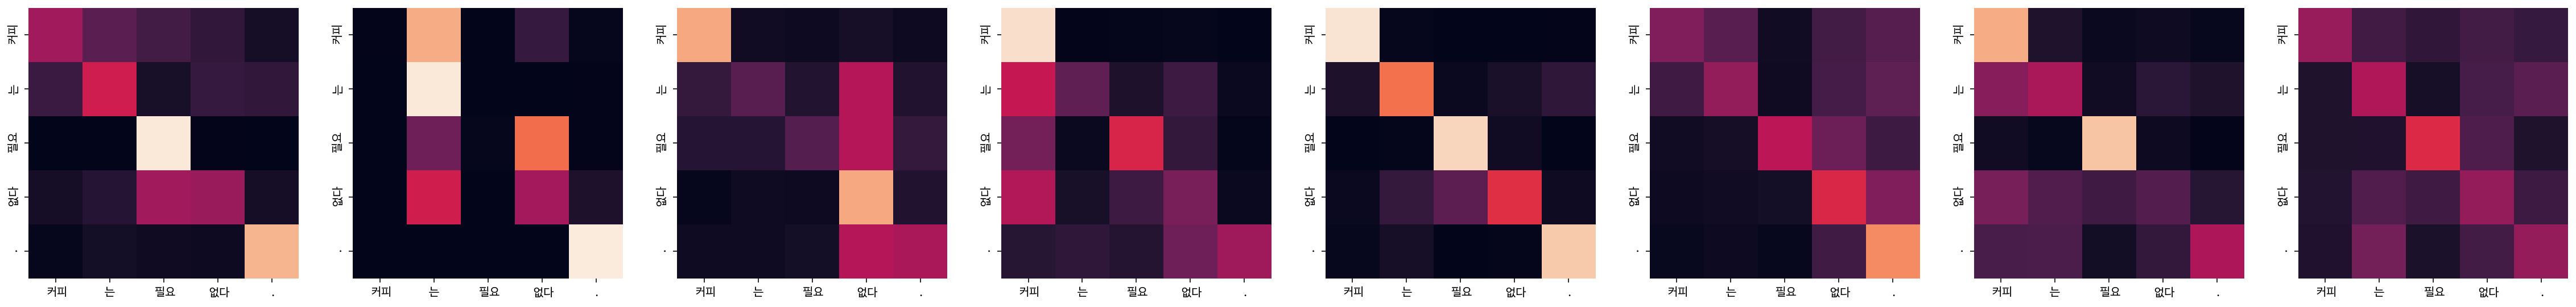

Encoder Layer 4


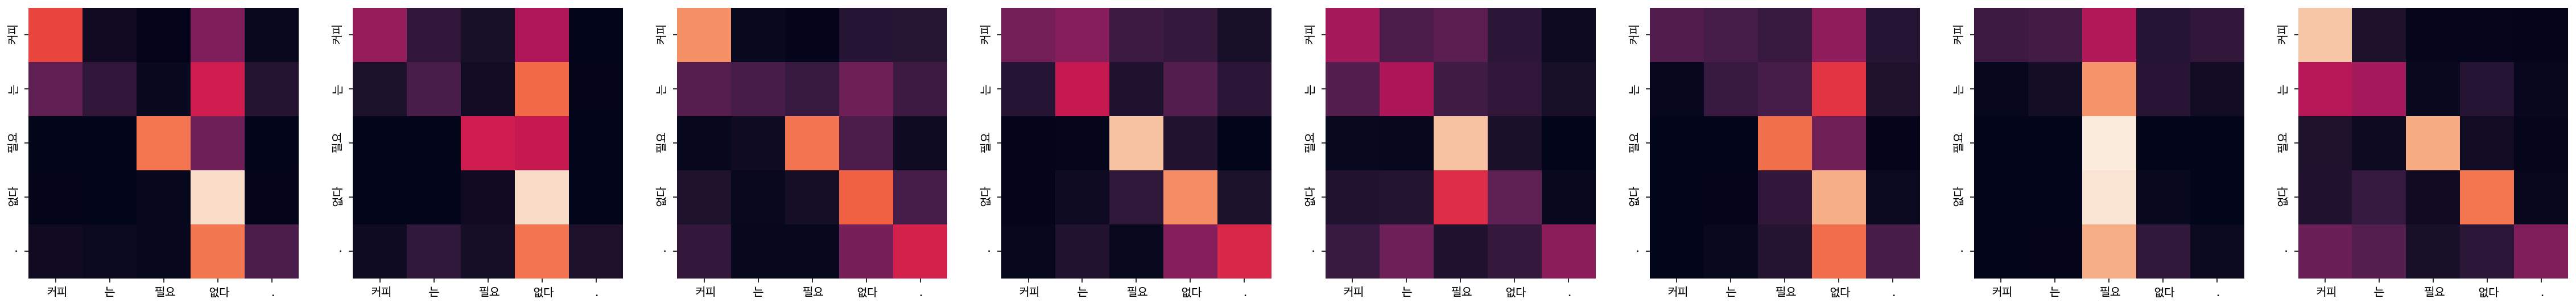

Encoder Layer 5


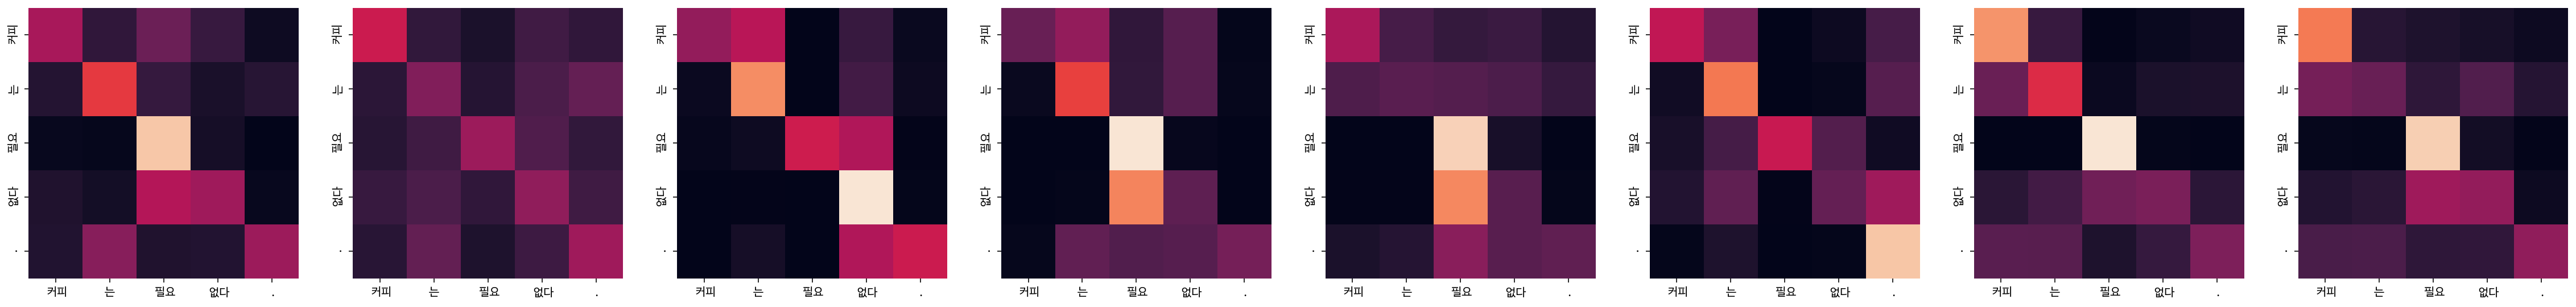

Encoder Layer 6


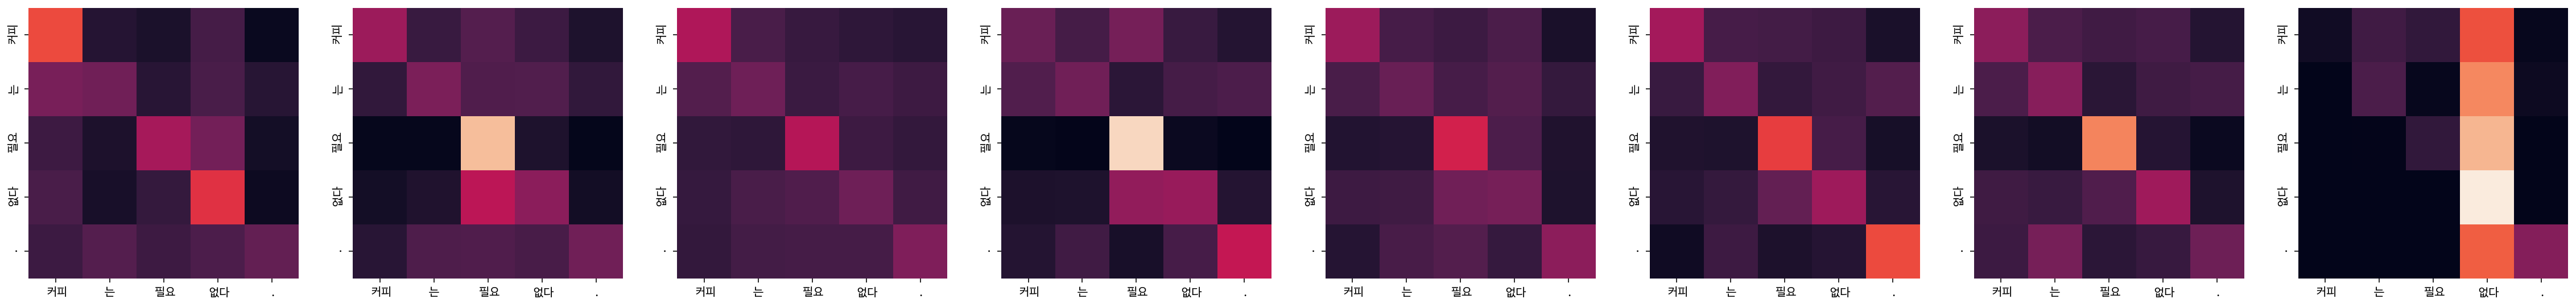

Decoder Self Layer 1


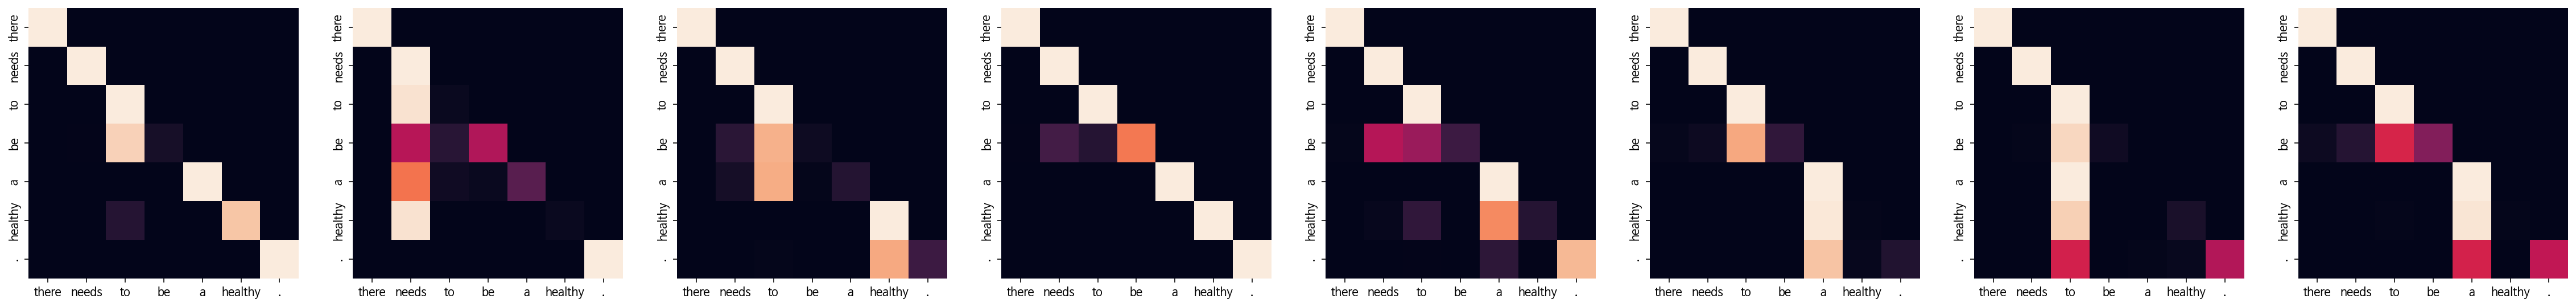

Decoder Src Layer 1


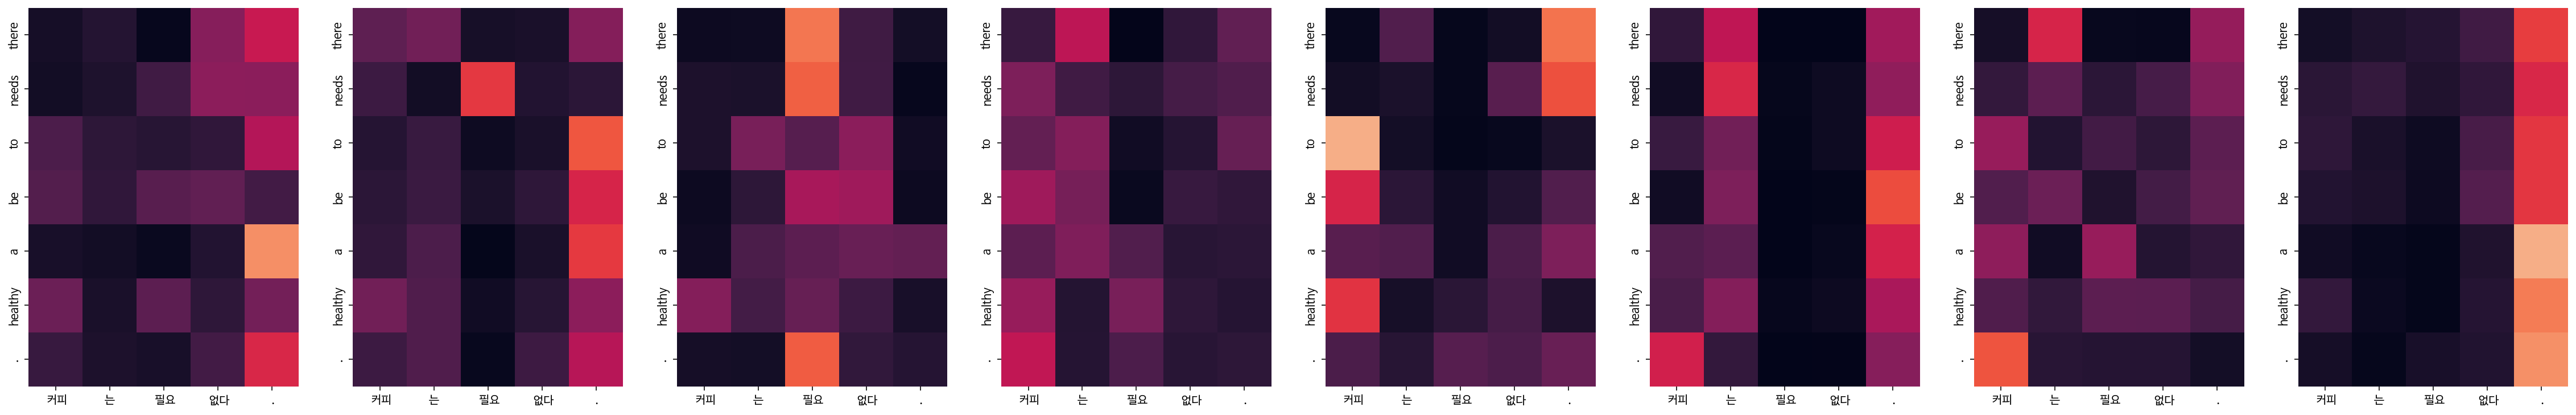

Decoder Self Layer 2


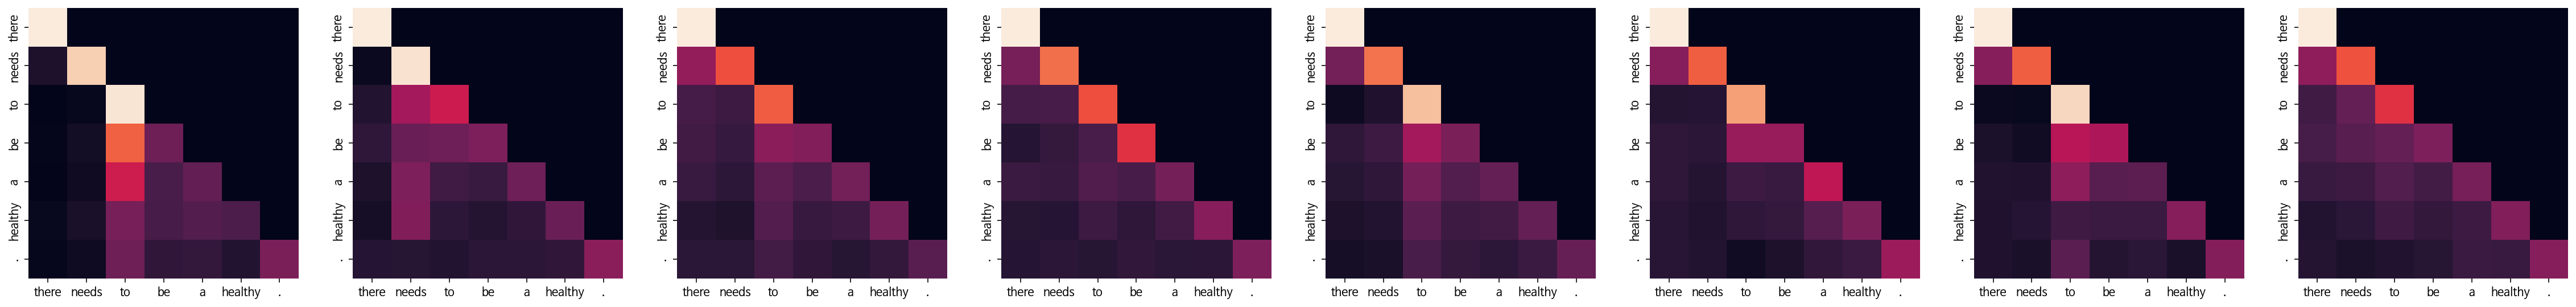

Decoder Src Layer 2


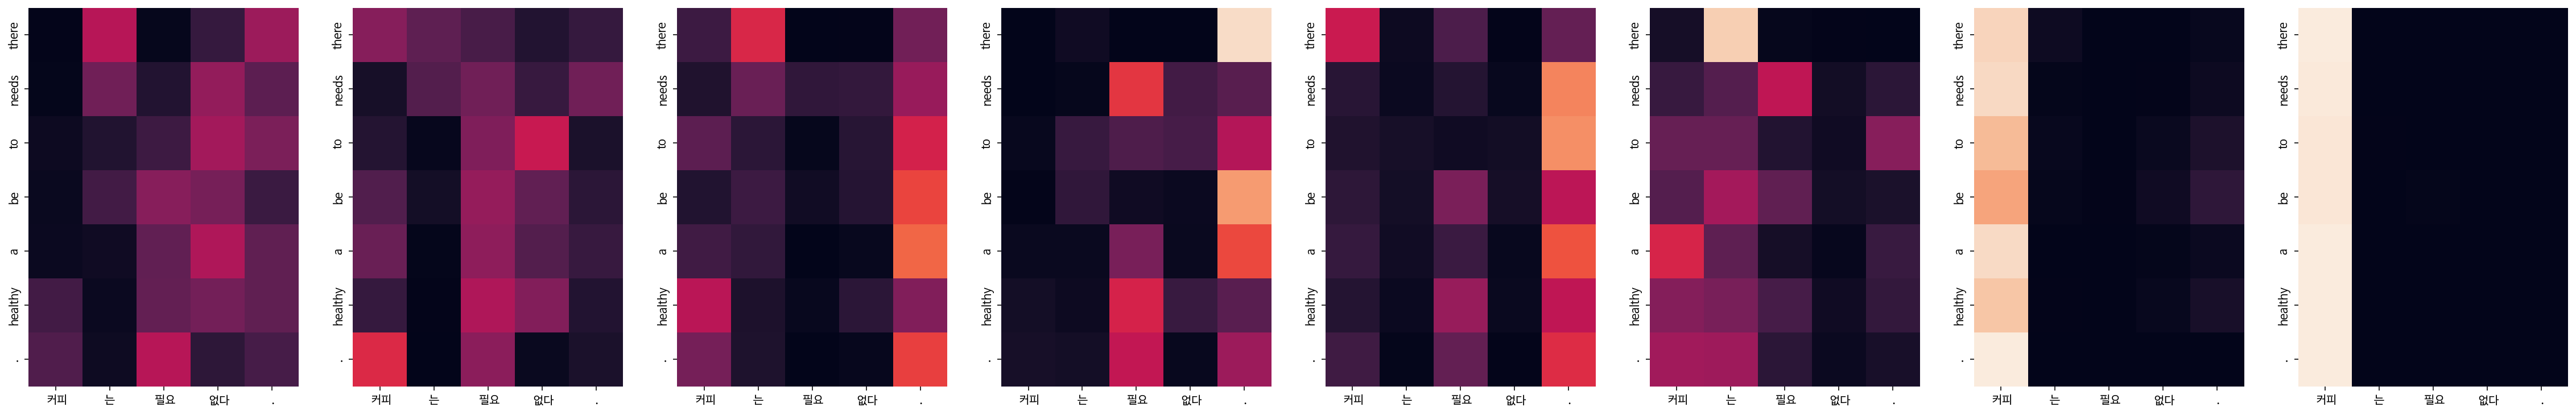

Decoder Self Layer 3


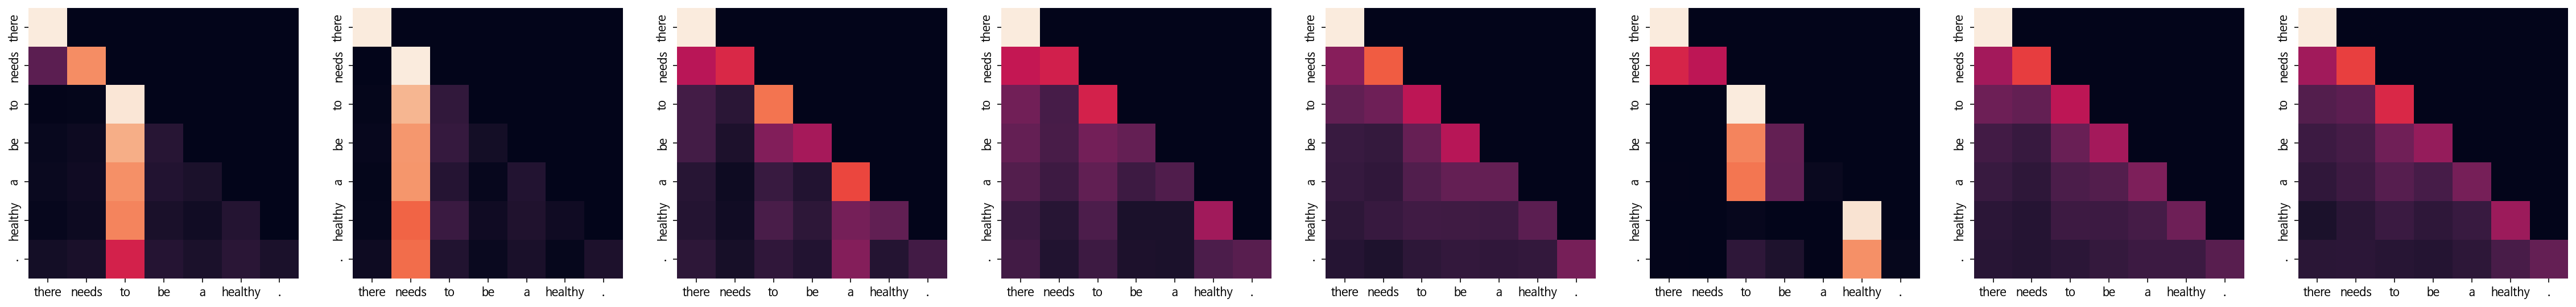

Decoder Src Layer 3


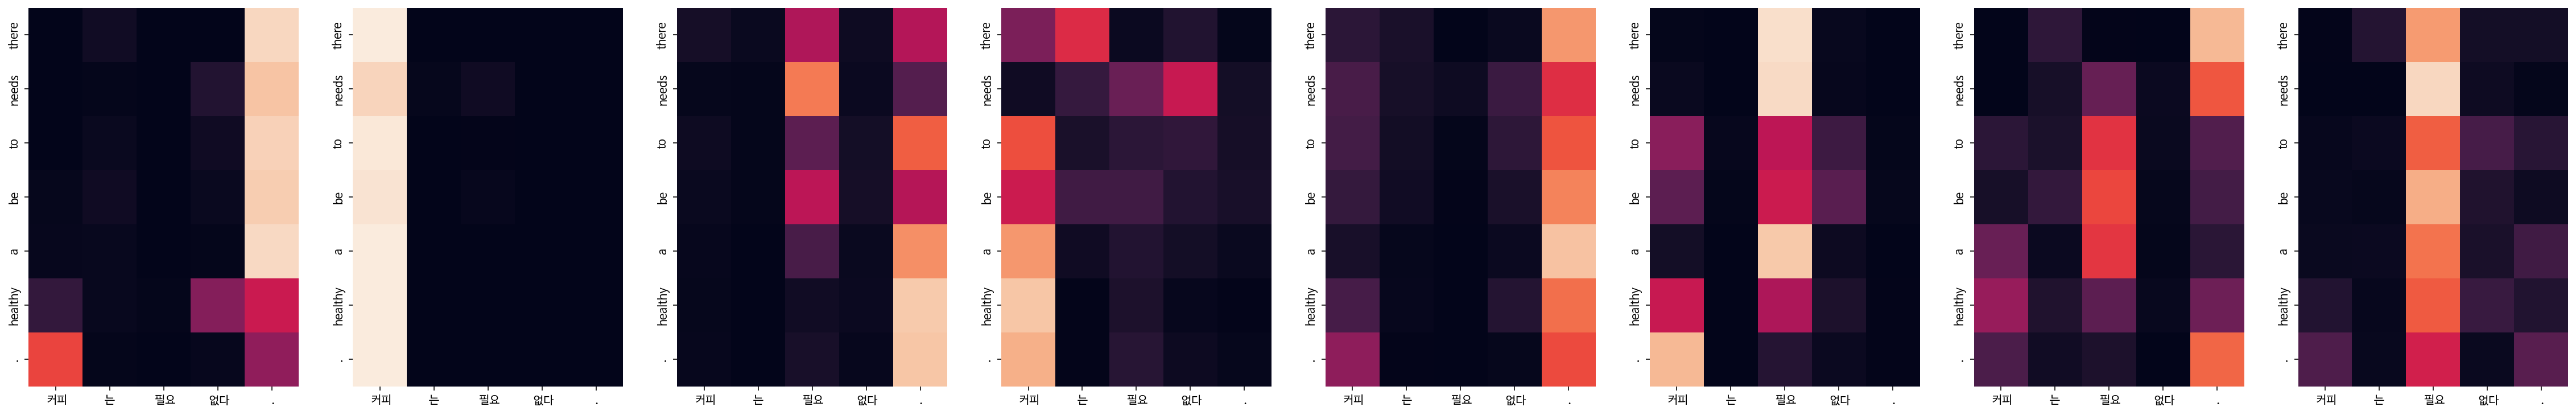

Decoder Self Layer 4


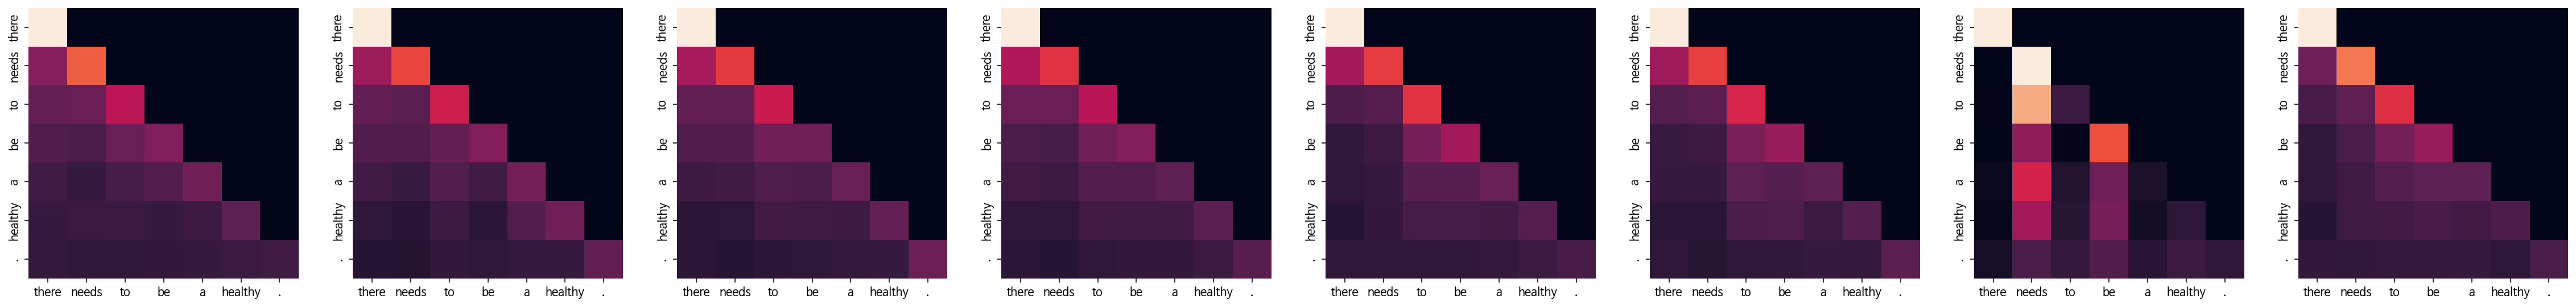

Decoder Src Layer 4


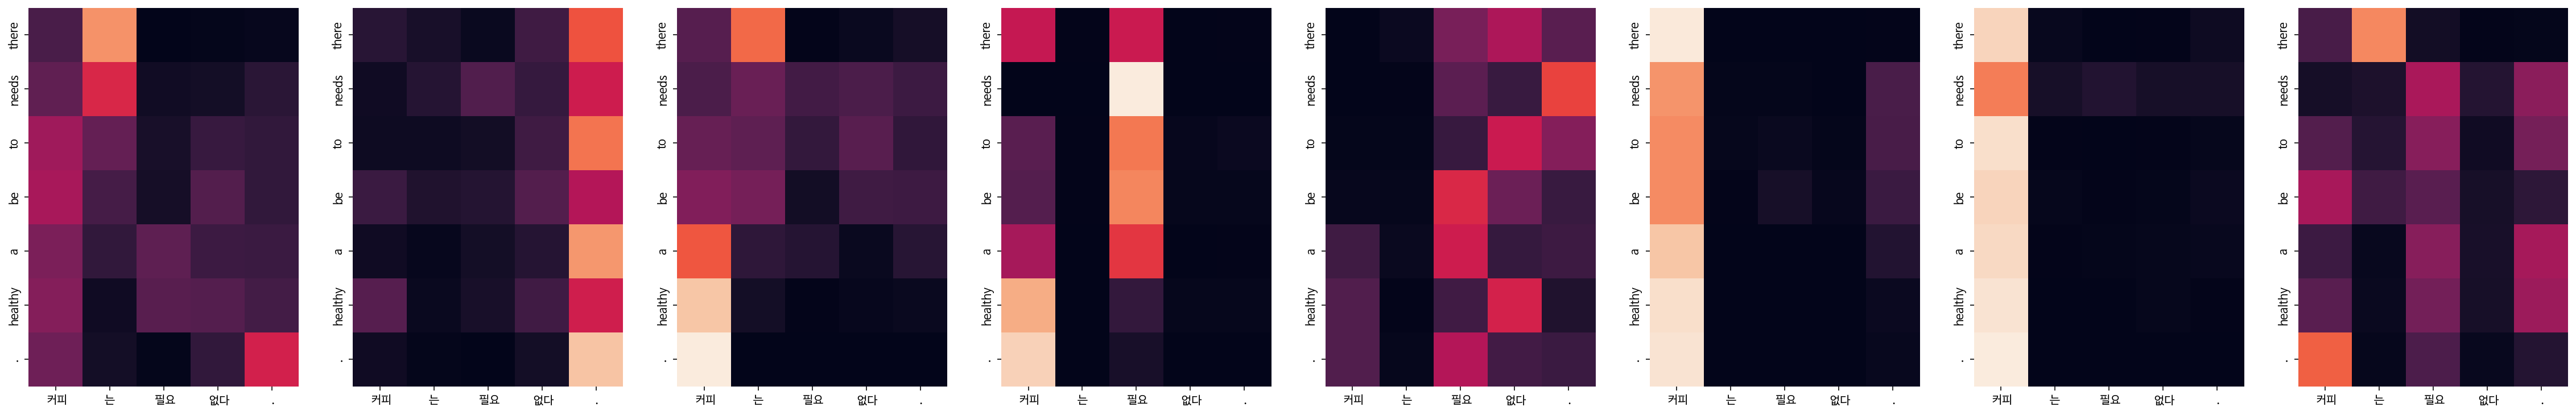

Decoder Self Layer 5


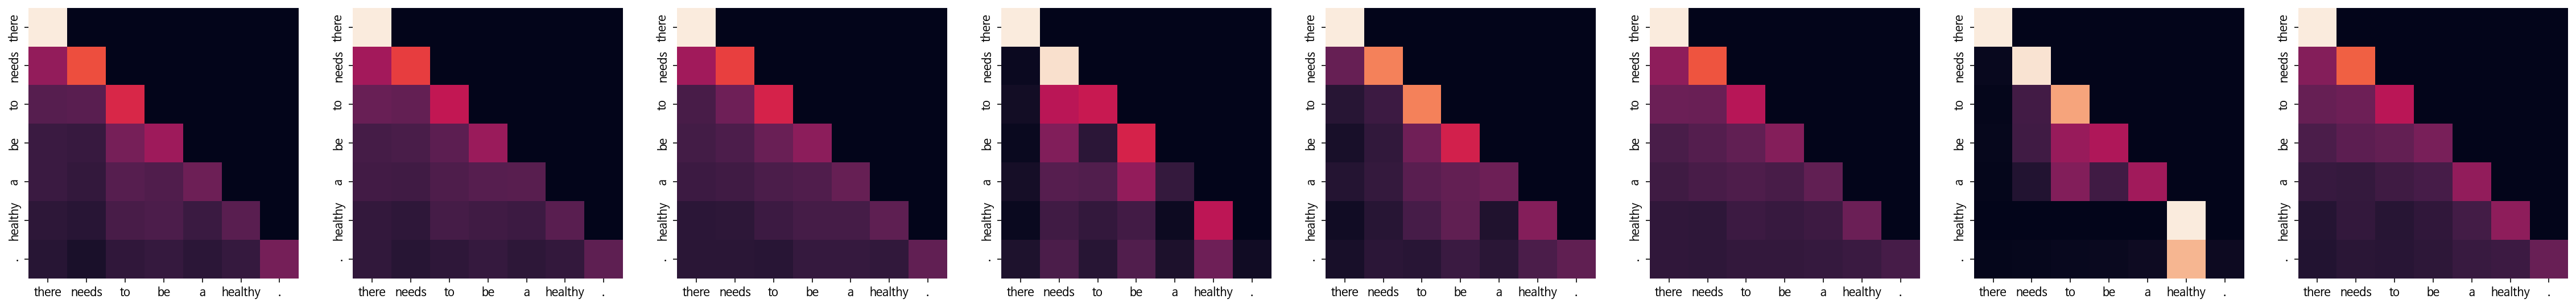

Decoder Src Layer 5


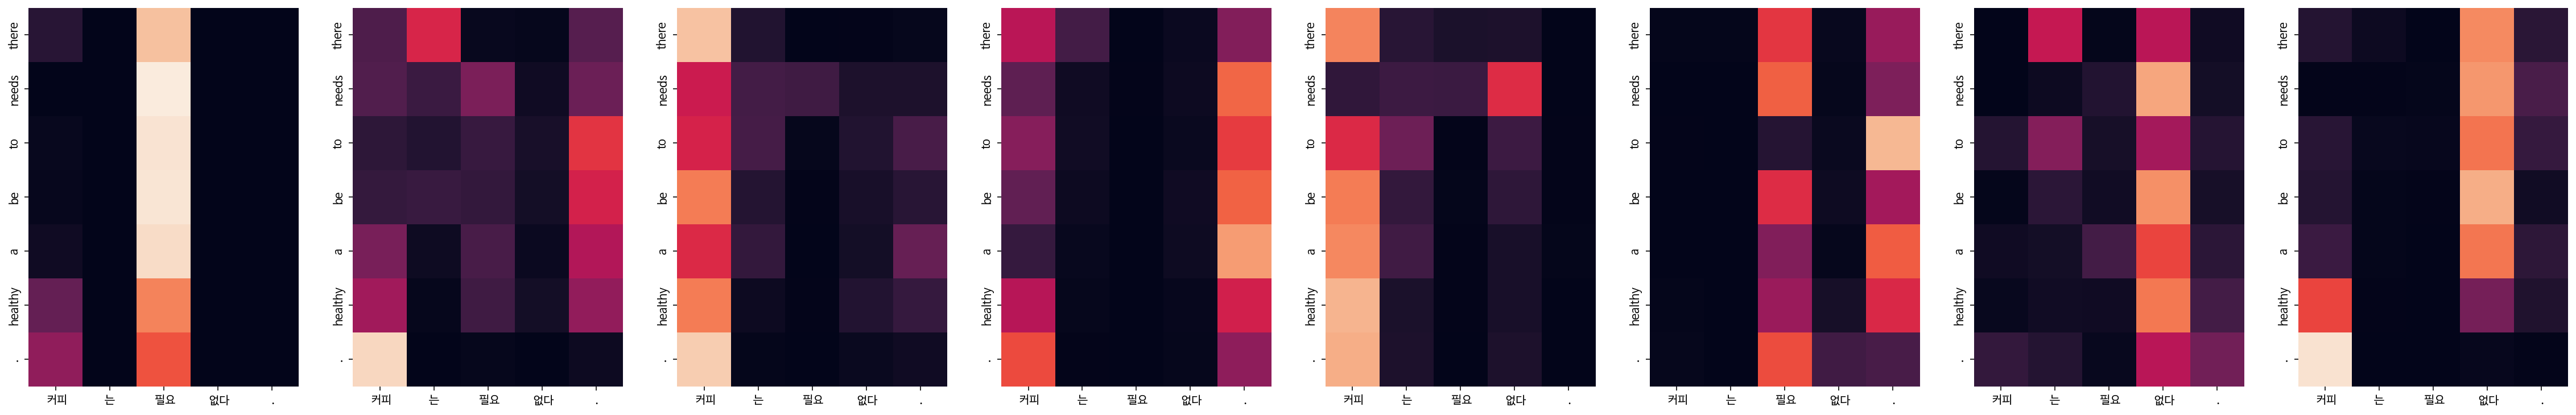

Decoder Self Layer 6


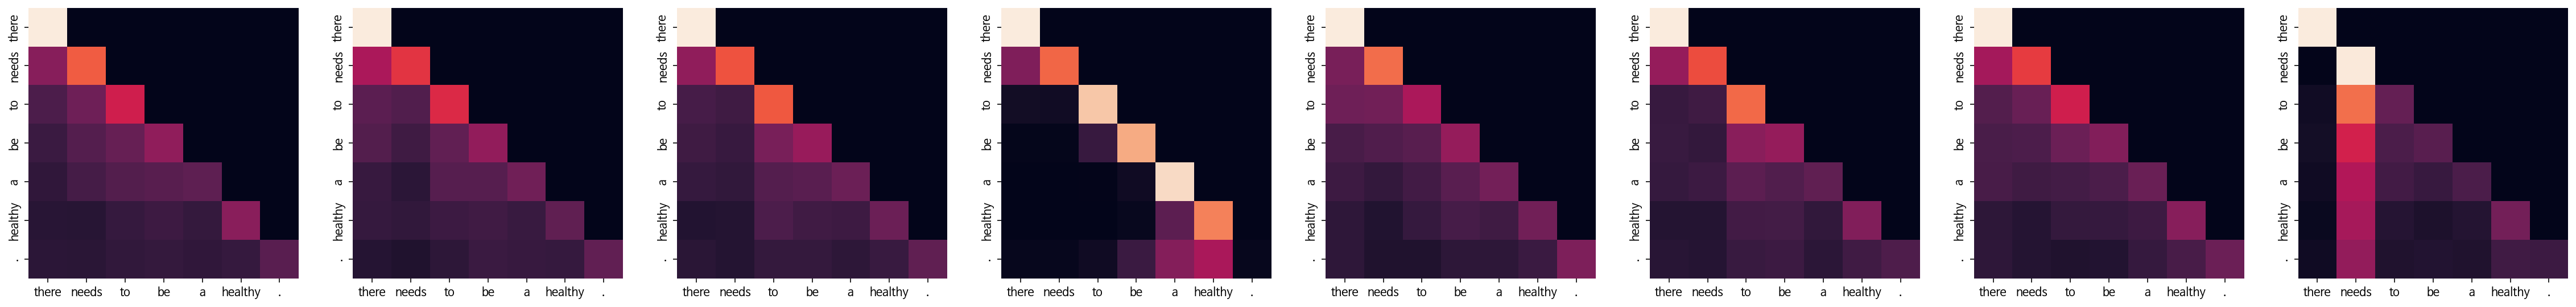

Decoder Src Layer 6


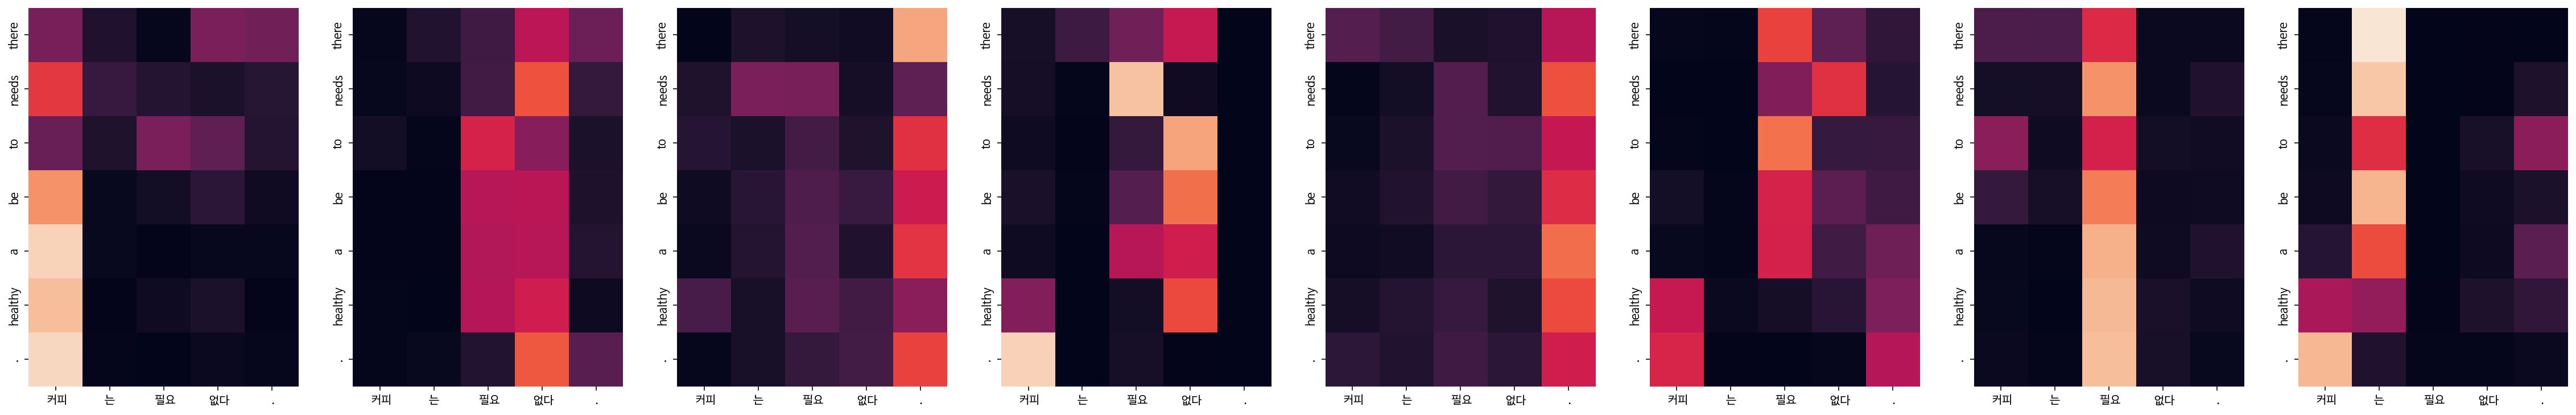

In [223]:
translate("커피는 필요 없다.", transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were the same according to the cause of the deaths .
Encoder Layer 1


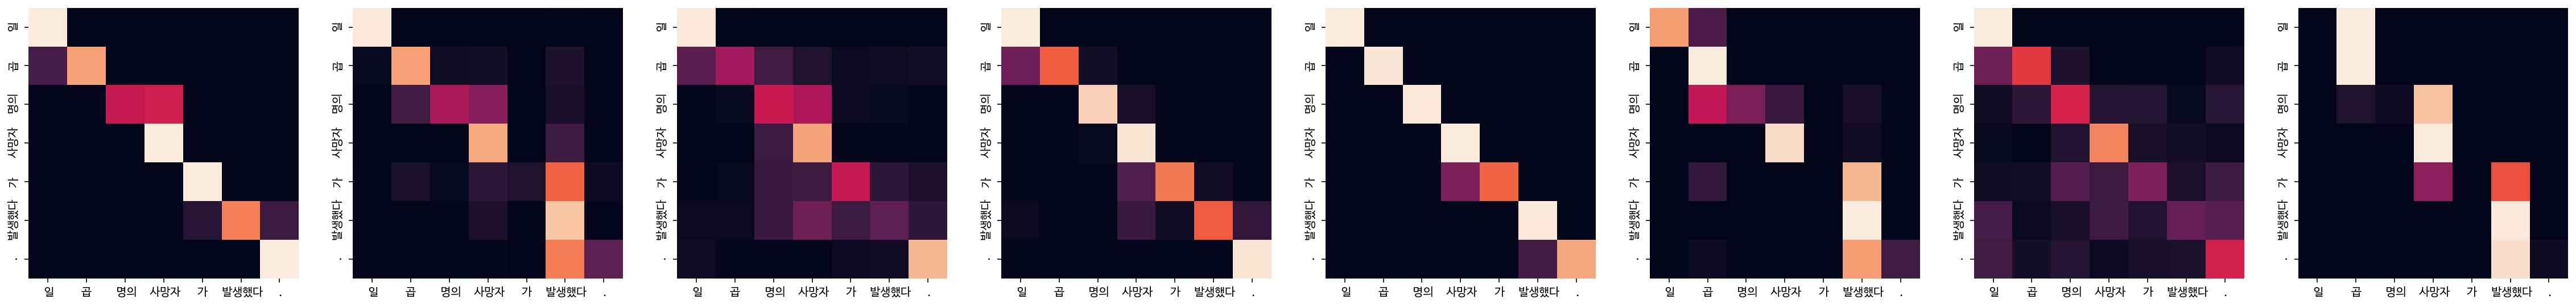

Encoder Layer 2


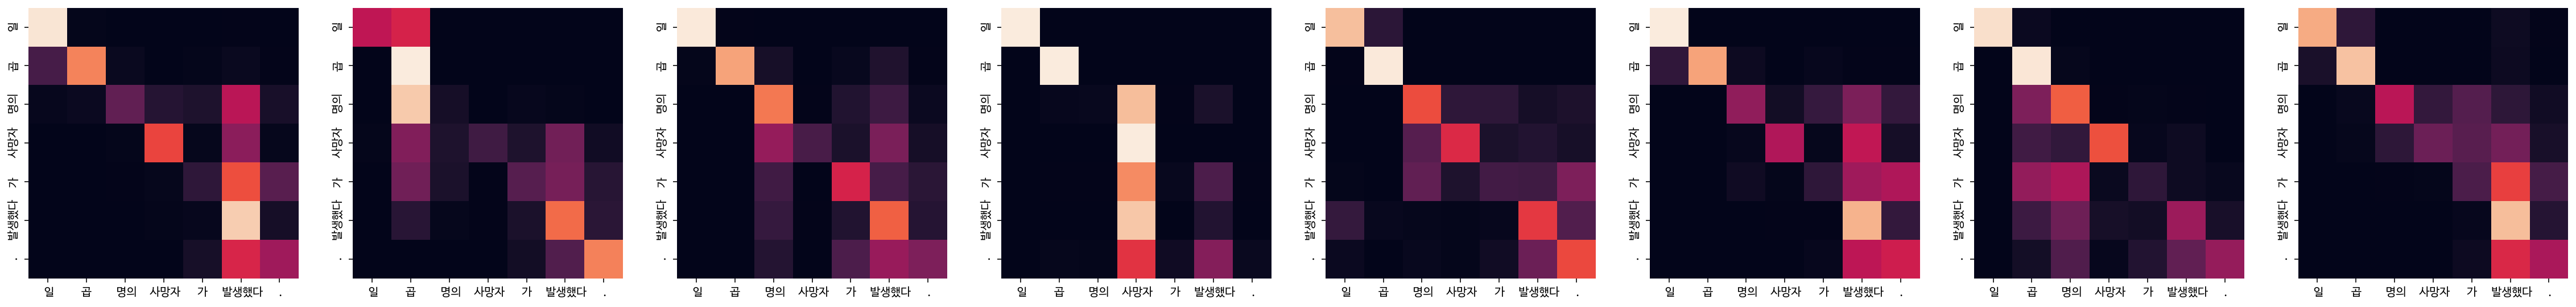

Encoder Layer 3


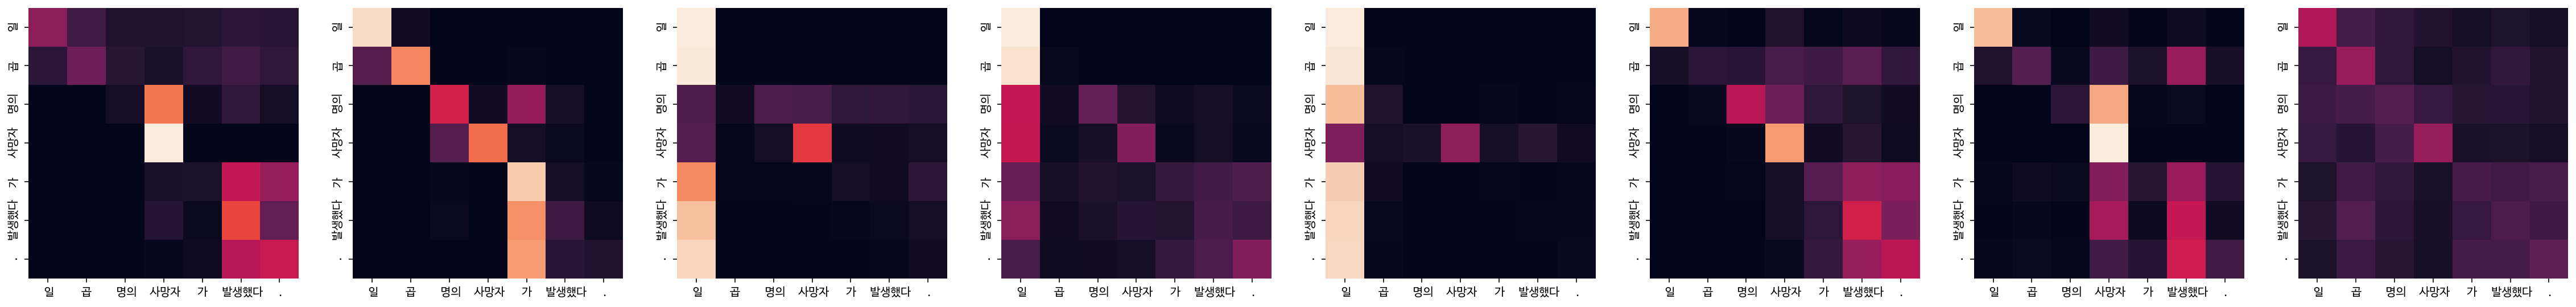

Encoder Layer 4


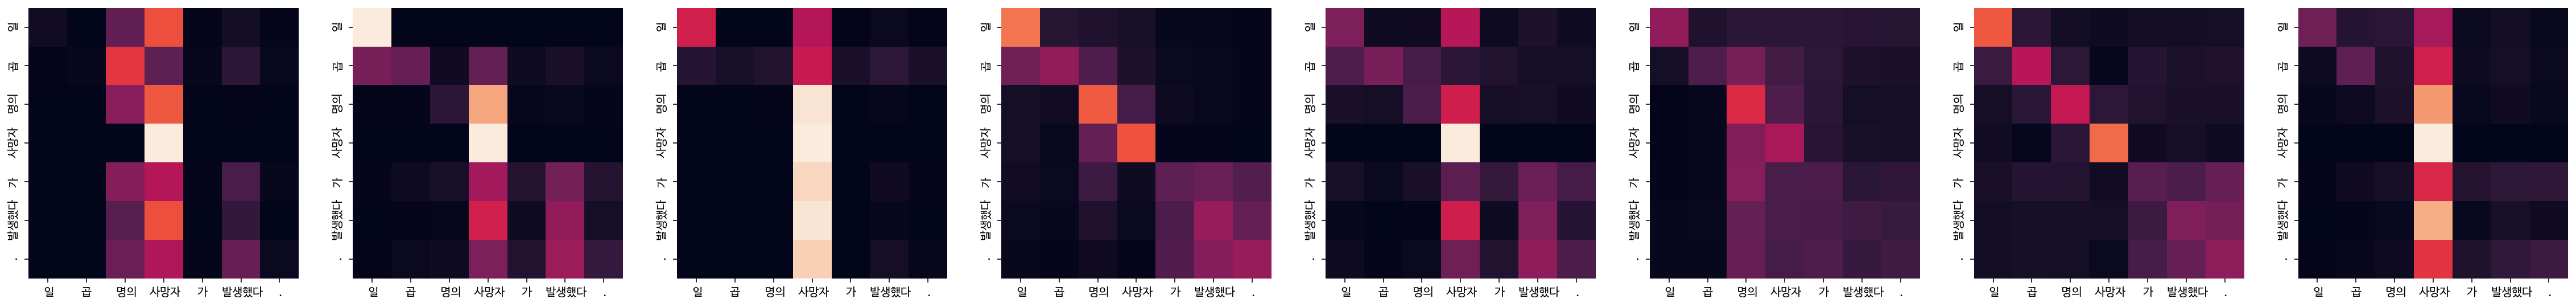

Encoder Layer 5


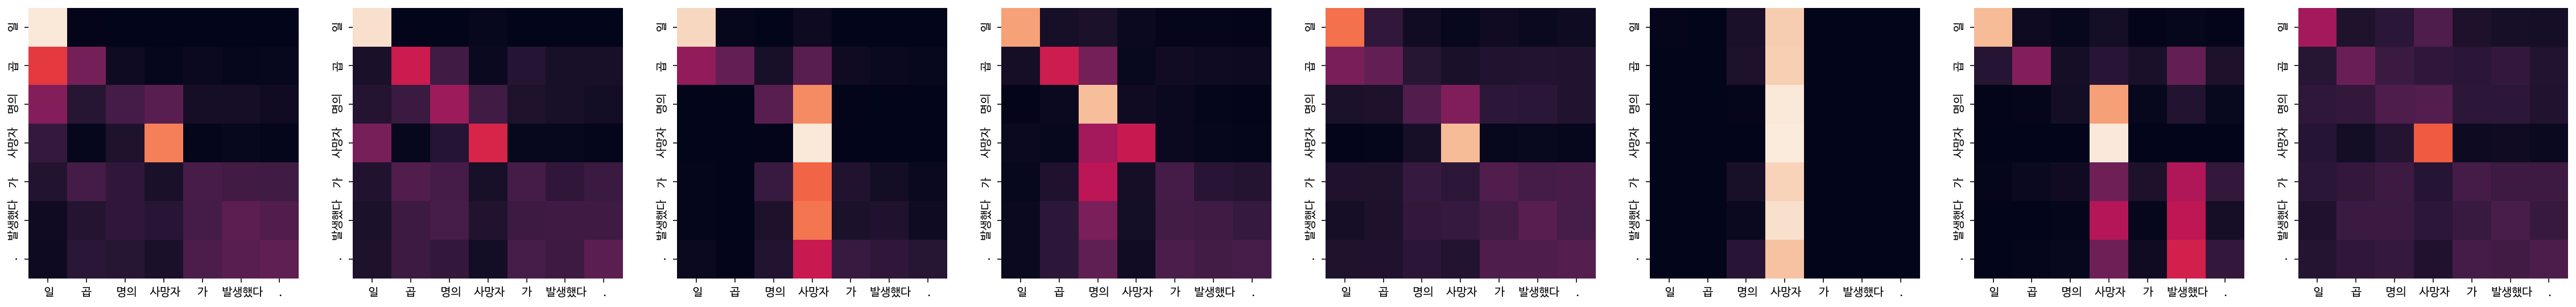

Encoder Layer 6


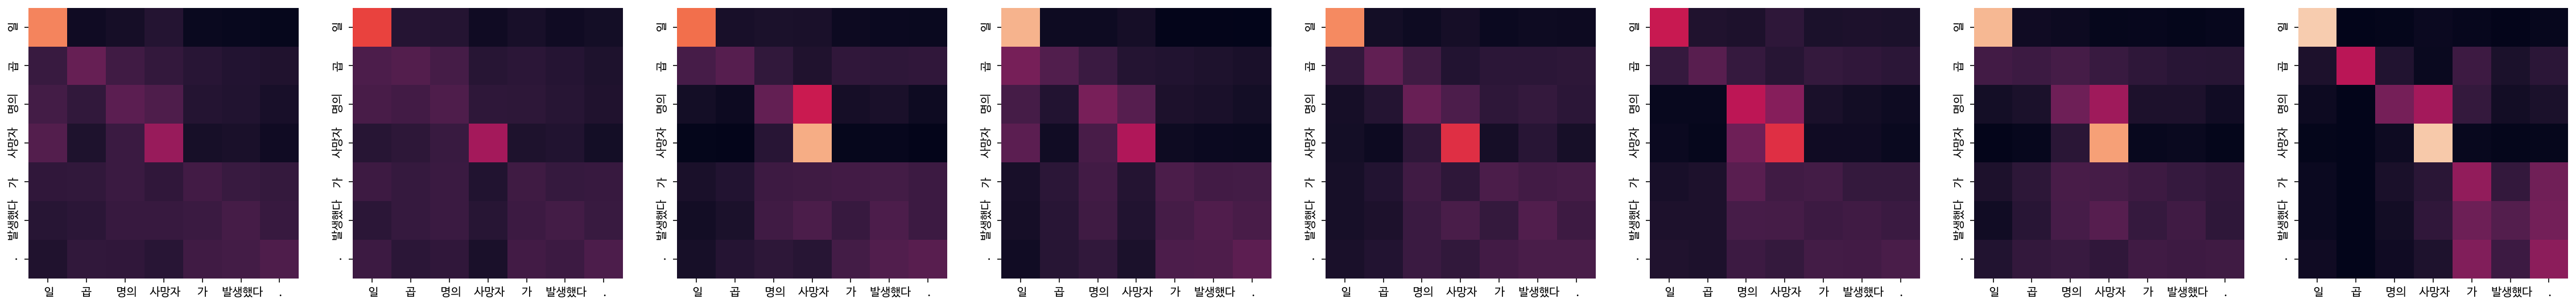

Decoder Self Layer 1


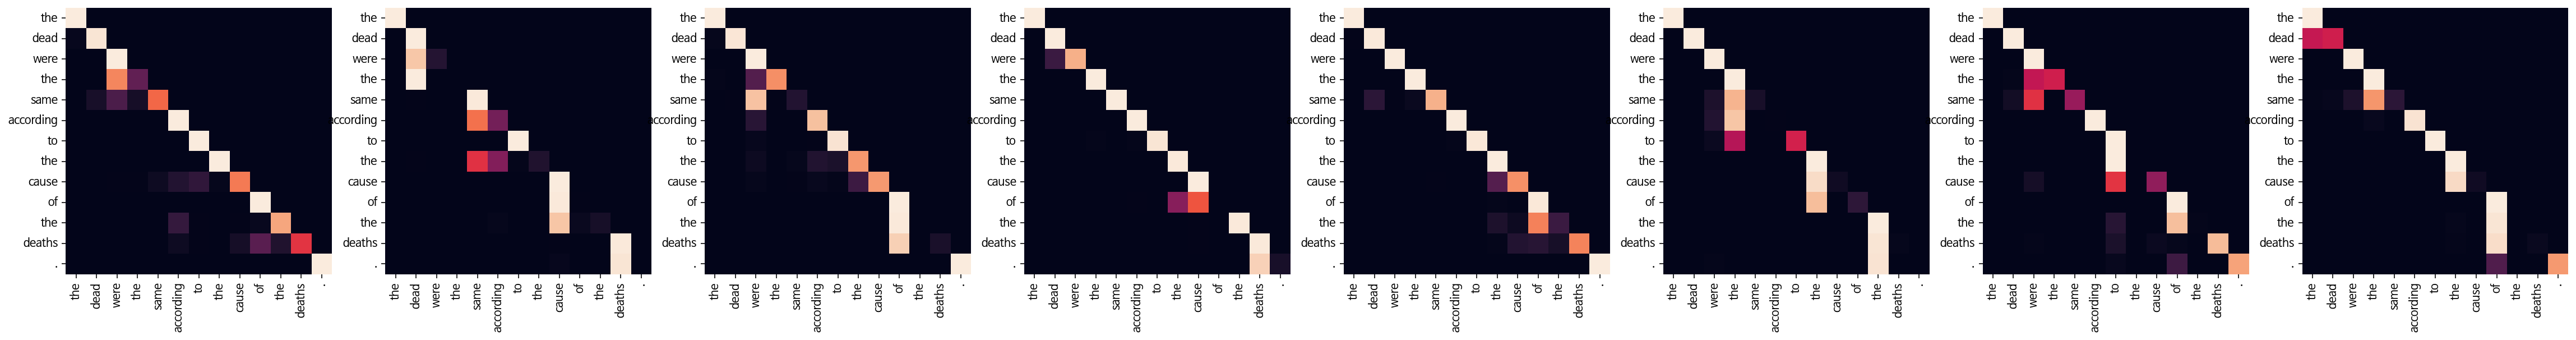

Decoder Src Layer 1


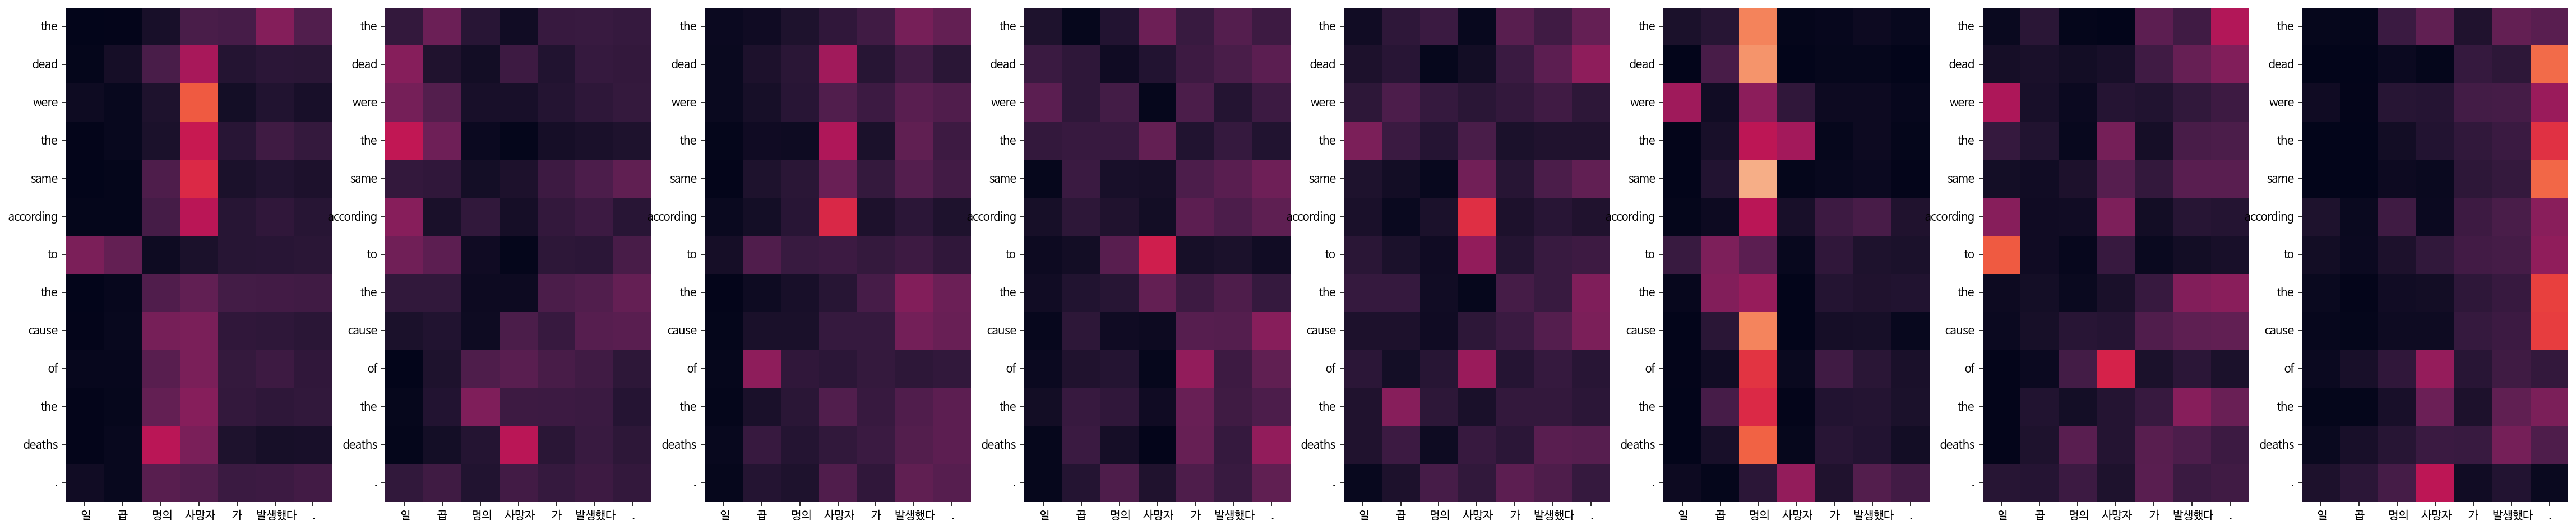

Decoder Self Layer 2


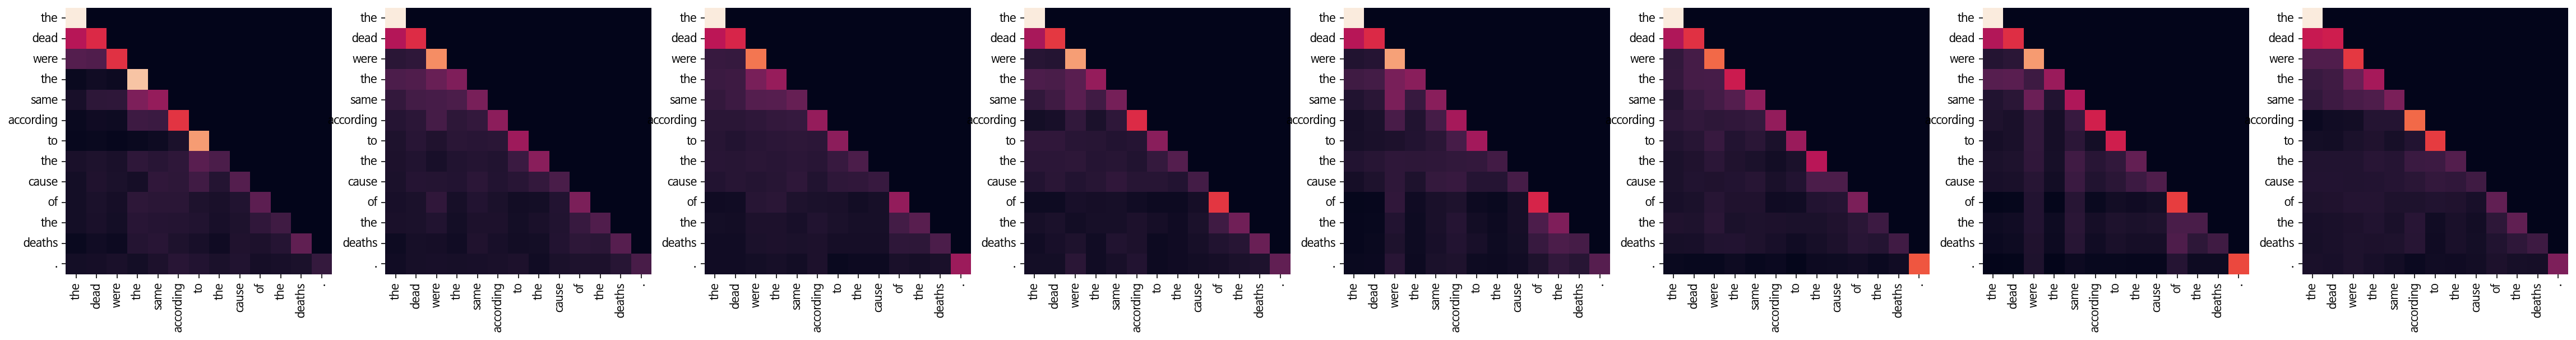

Decoder Src Layer 2


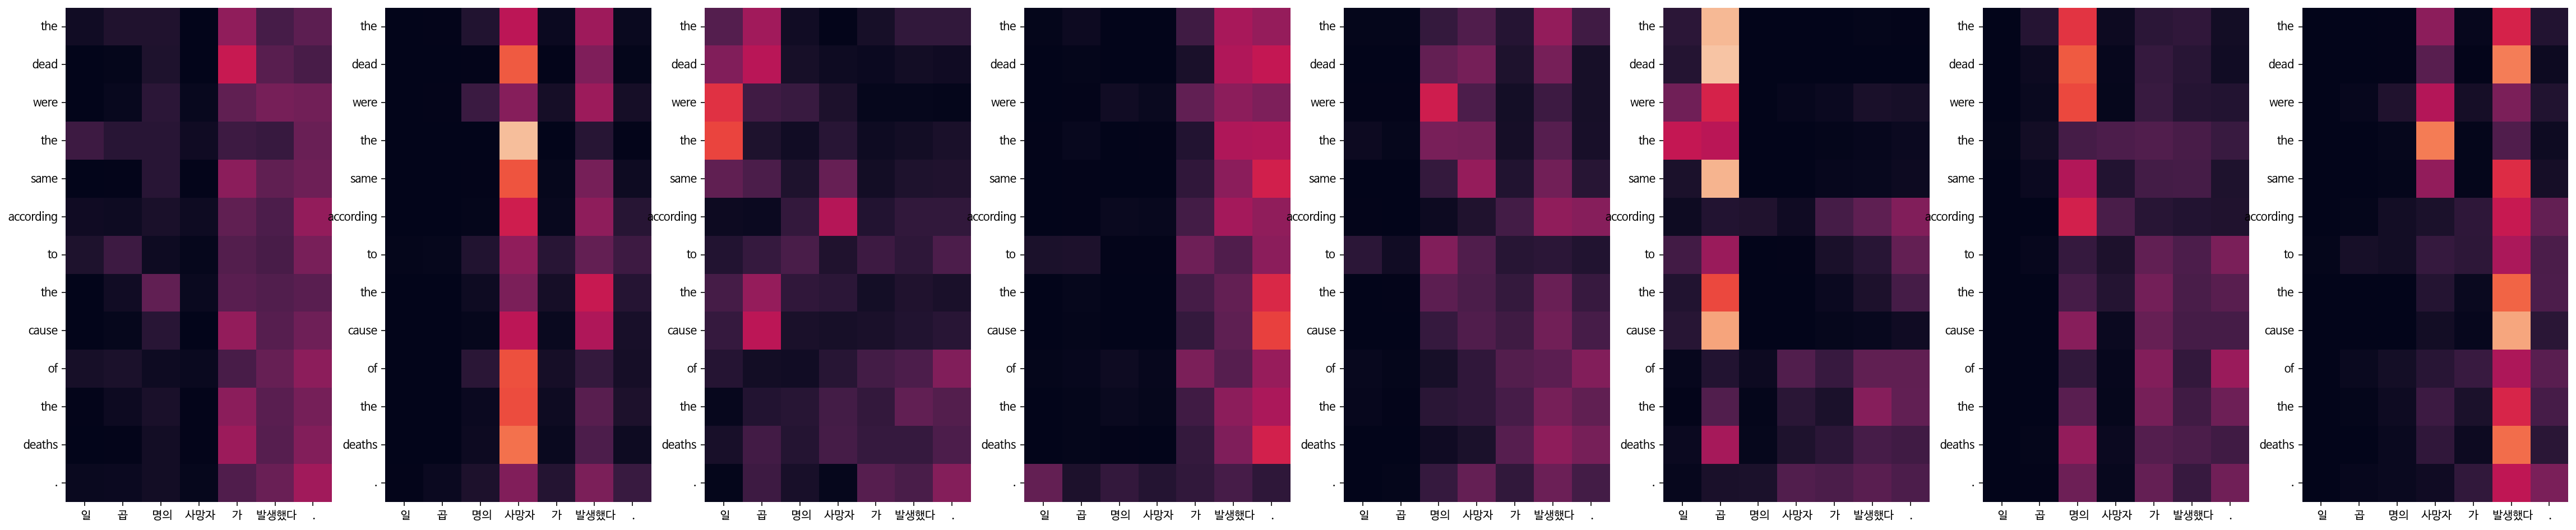

Decoder Self Layer 3


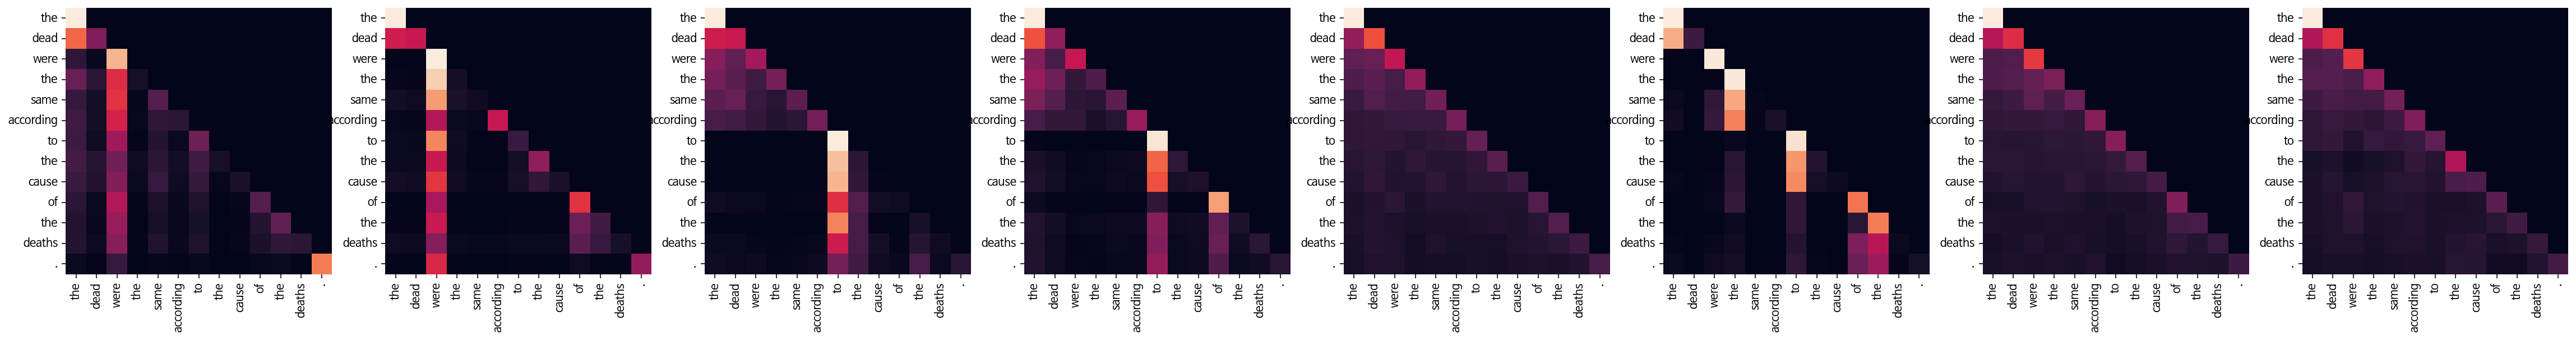

Decoder Src Layer 3


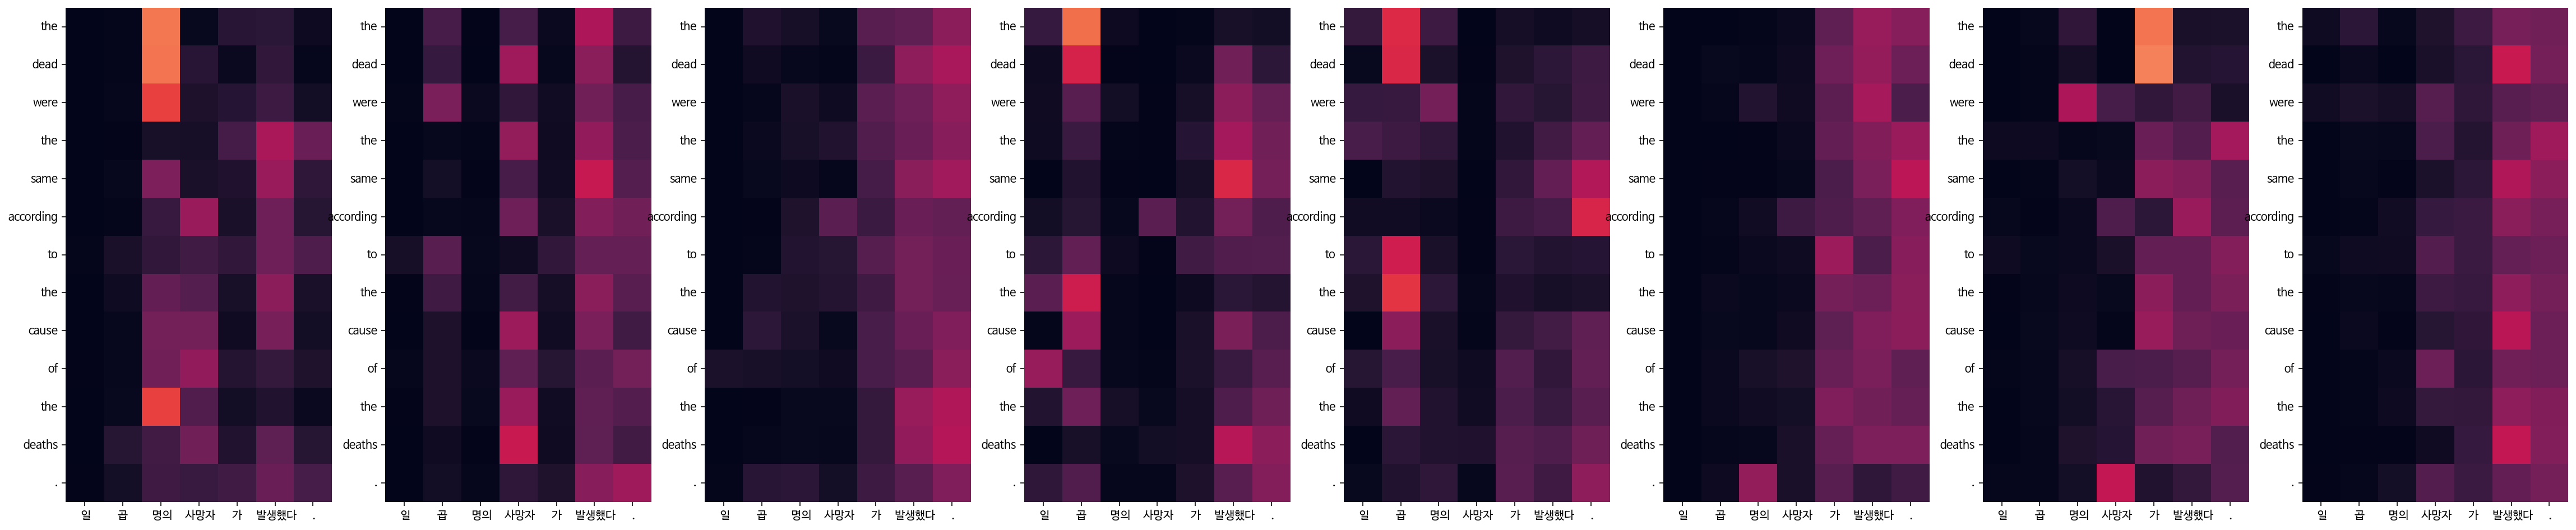

Decoder Self Layer 4


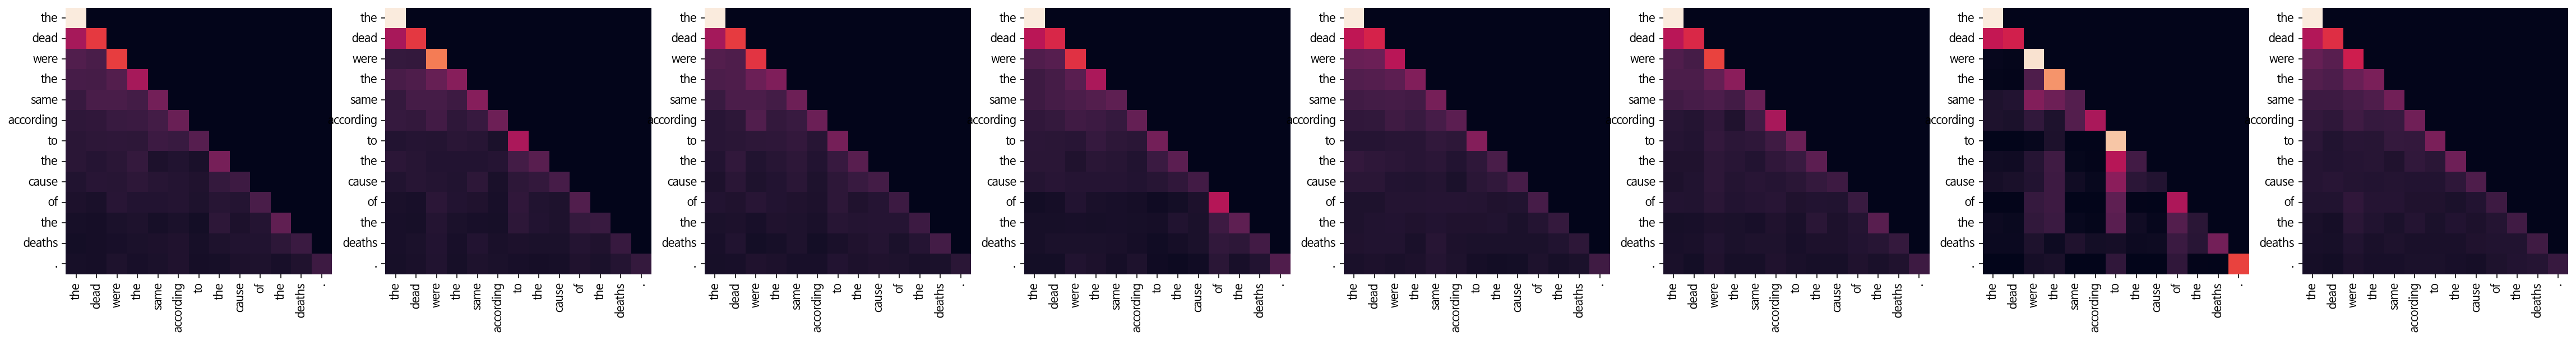

Decoder Src Layer 4


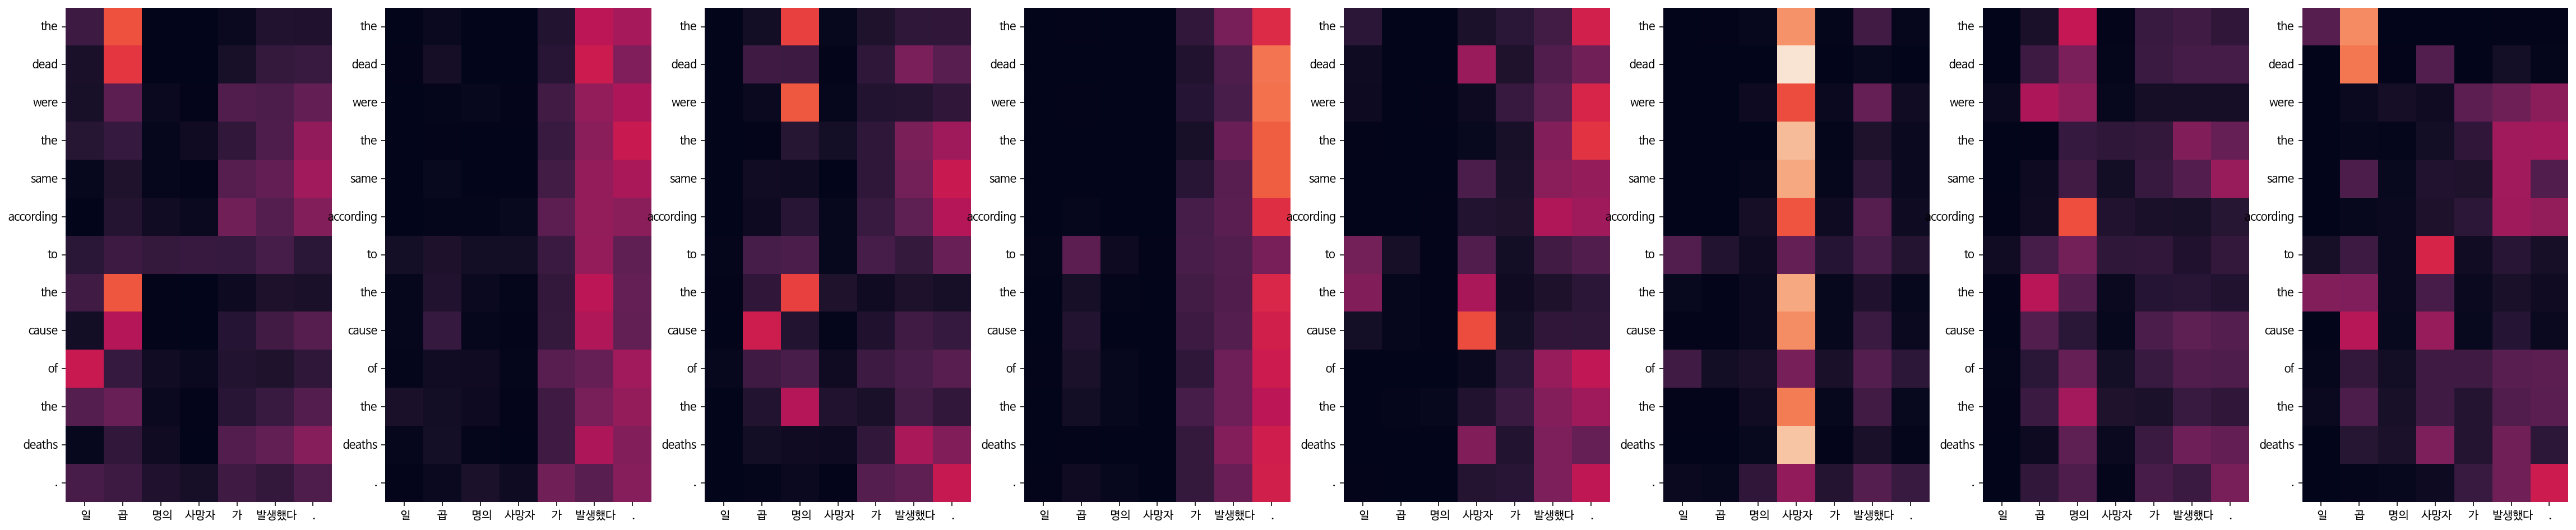

Decoder Self Layer 5


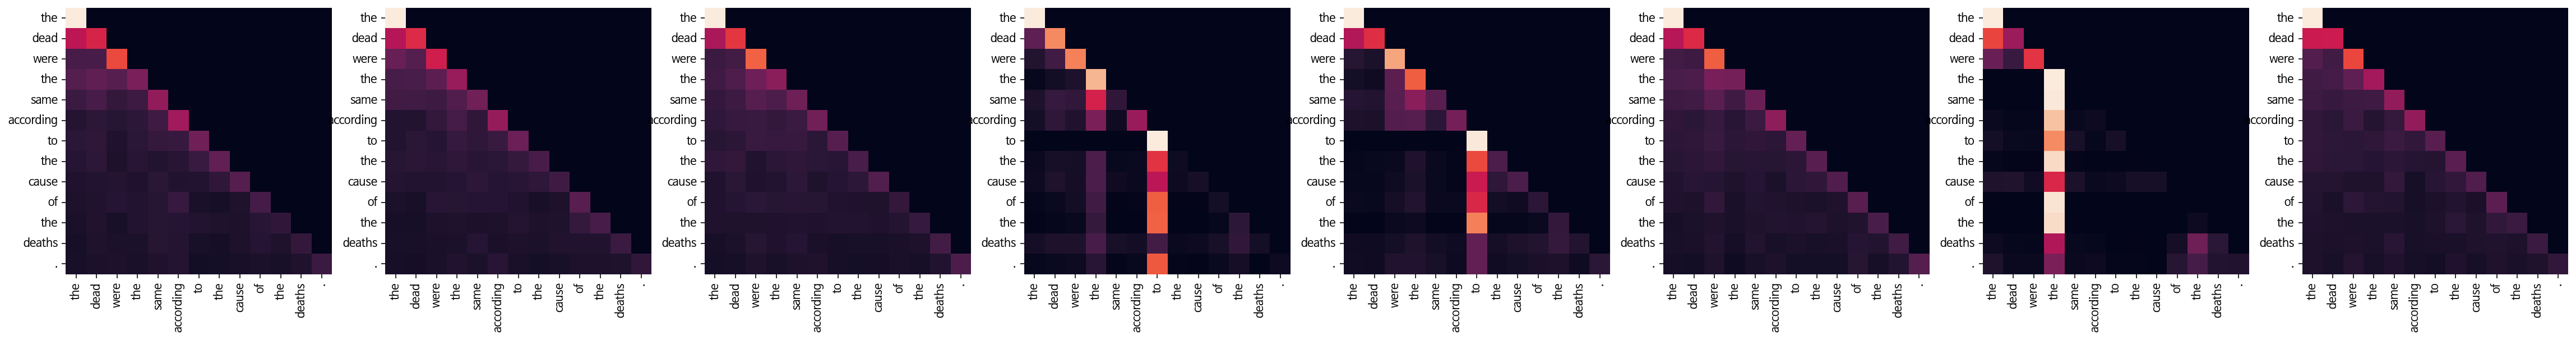

Decoder Src Layer 5


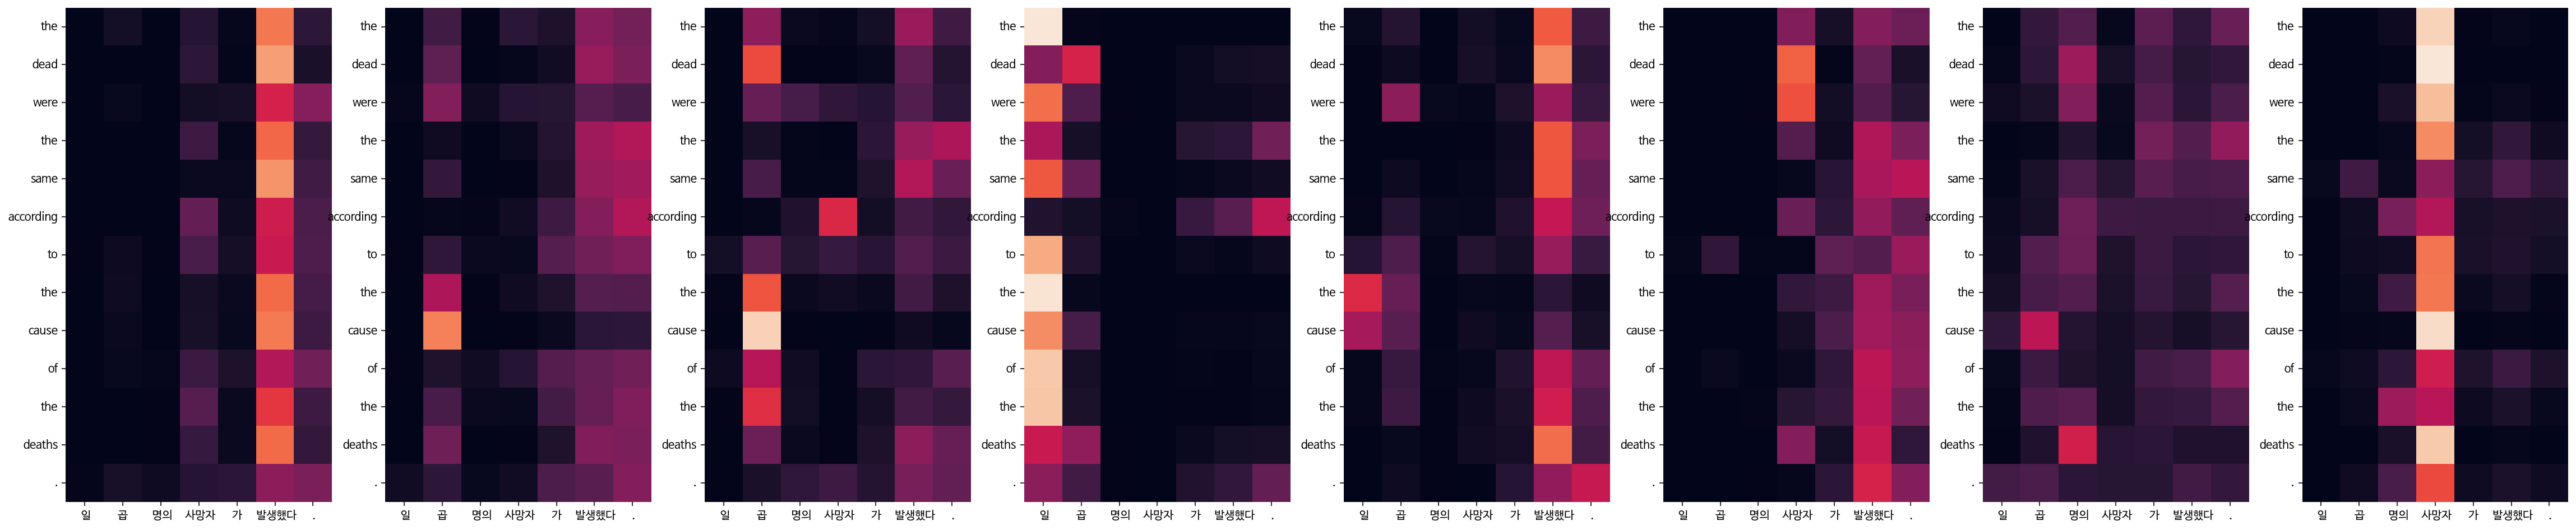

Decoder Self Layer 6


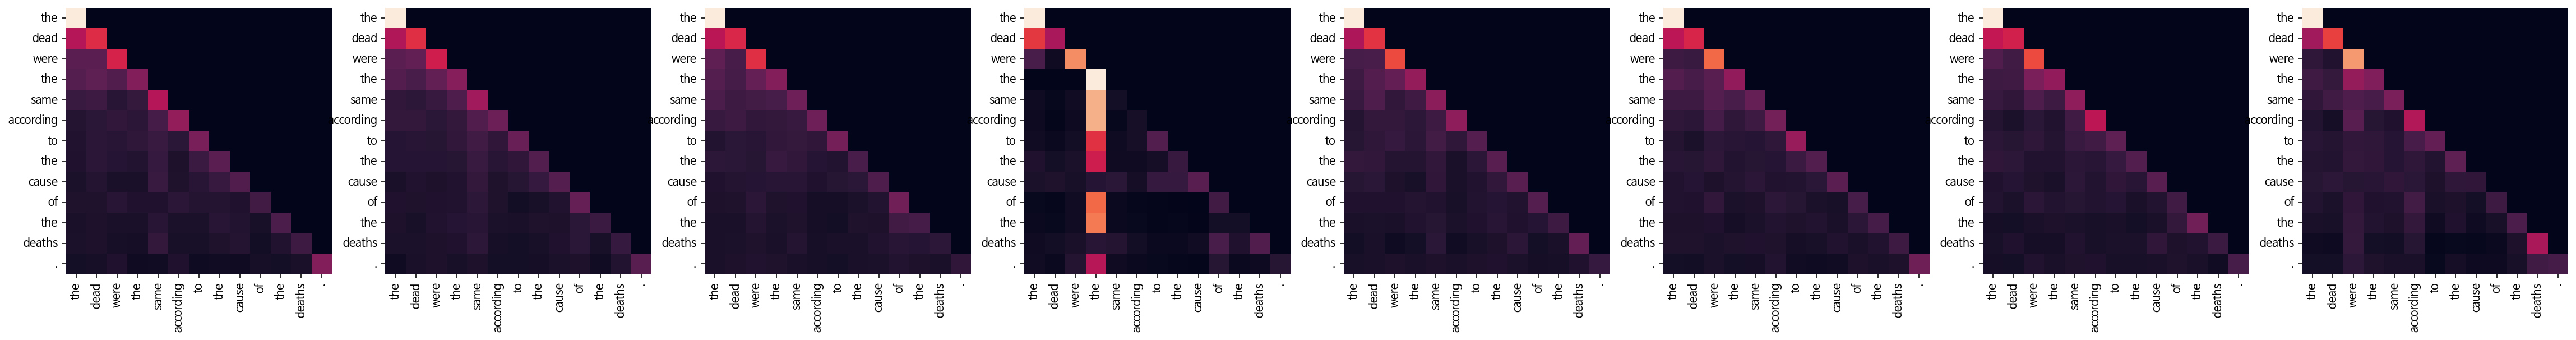

Decoder Src Layer 6


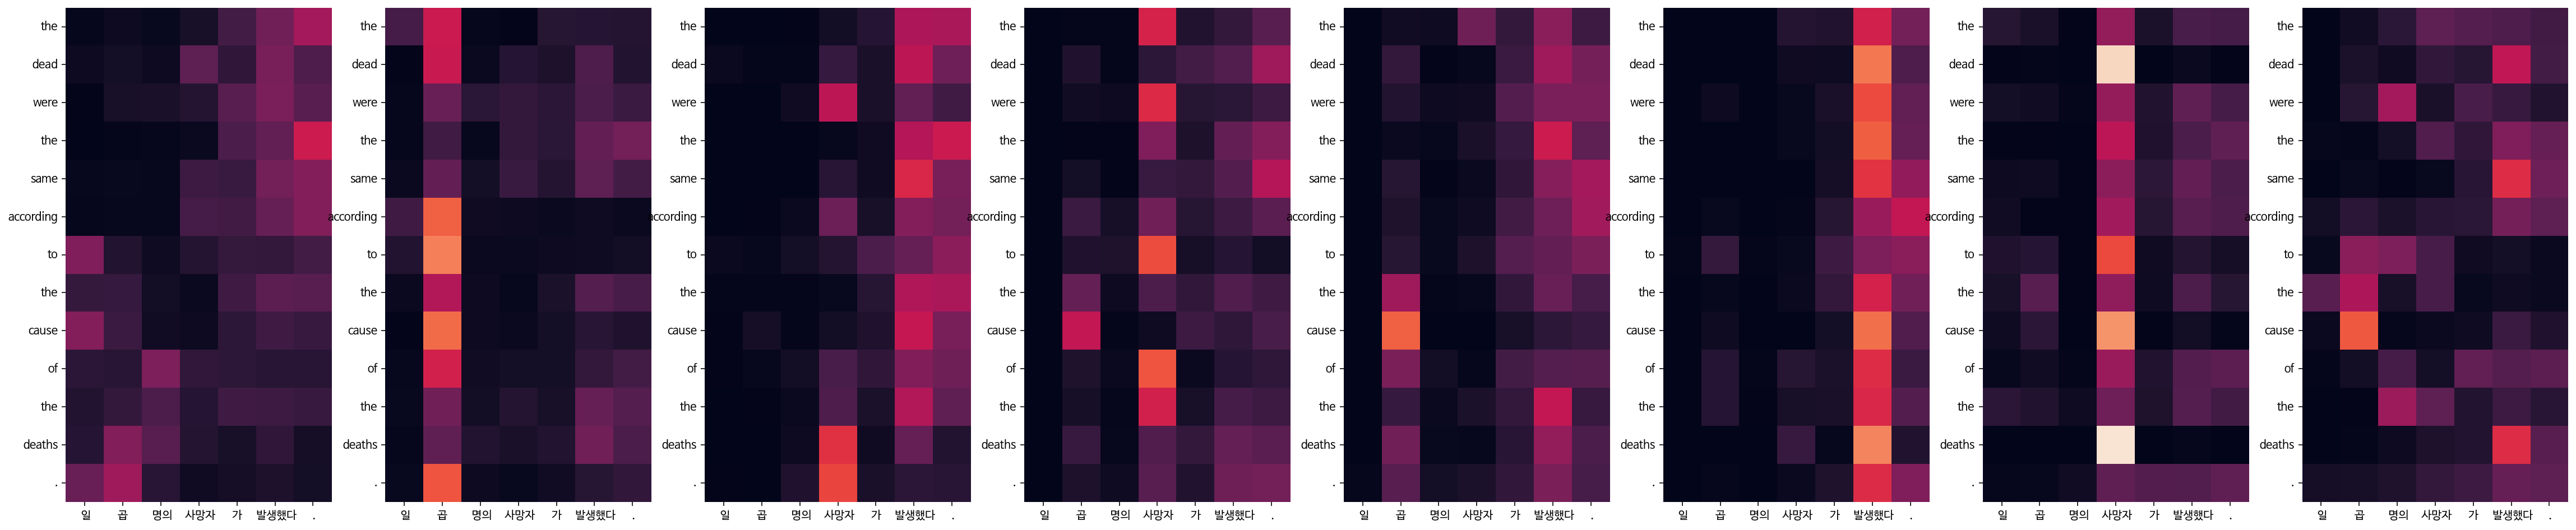

In [224]:
translate("일곱 명의 사망자가 발생했다.", transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Input: 이라크 북부 아르빌에 , 명의 파병군을 둔 우리 정부는 이슬람 테러리스트 단체의 반복적인 경고에 경계를 강화하고 있다 . 삼가다 , 억누르다 이슬람의
Predicted translation: in iraq , as the death toll a push to , troops along with sunni arabs , separatists in korea and the government .
Encoder Layer 1


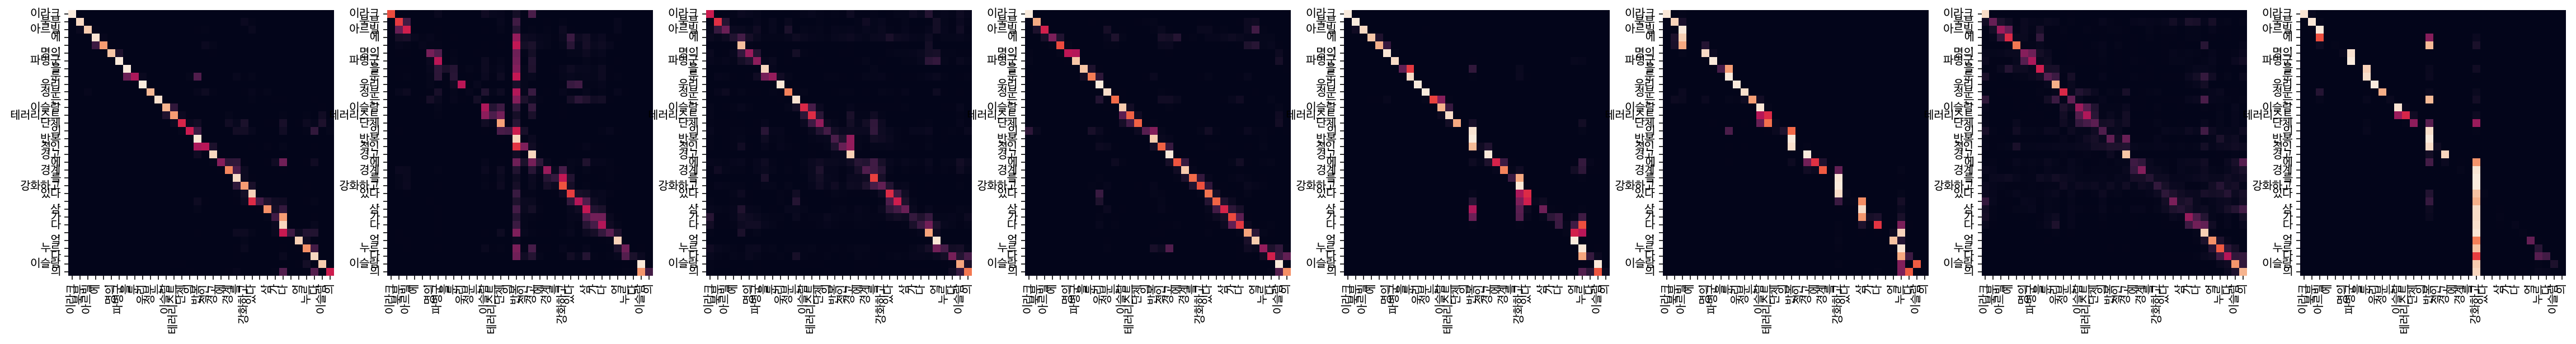

Encoder Layer 2


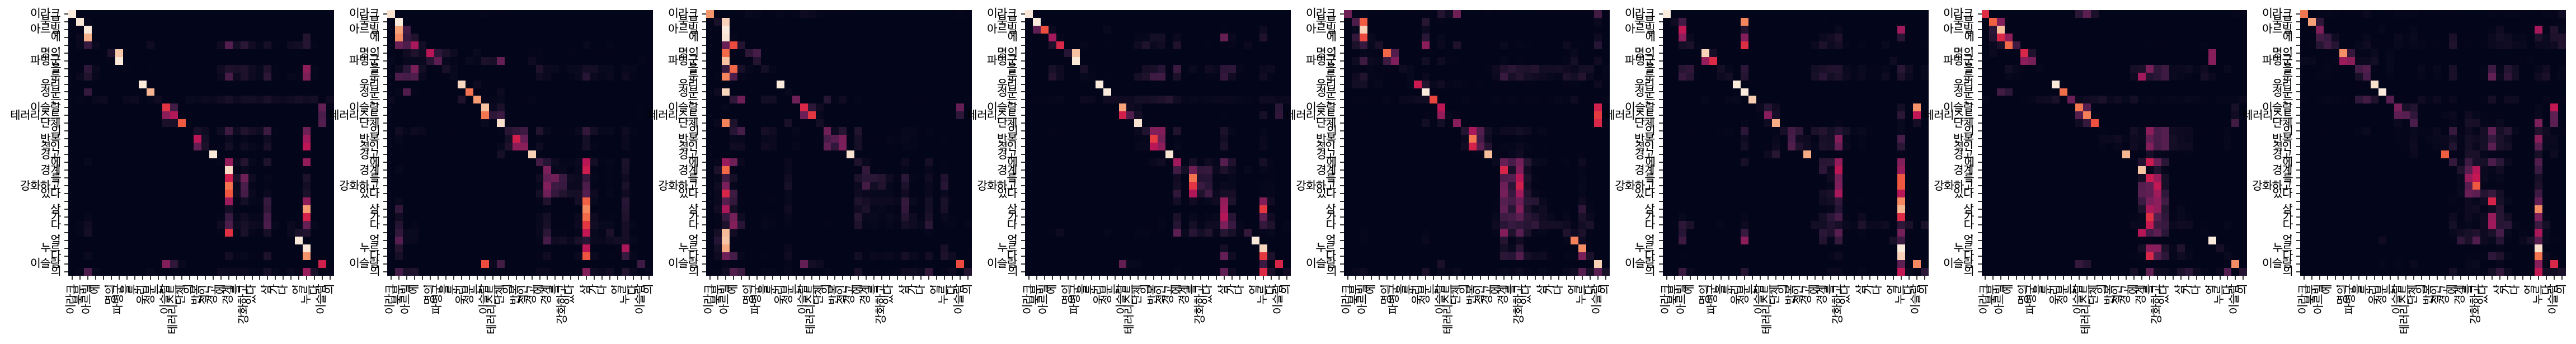

Encoder Layer 3


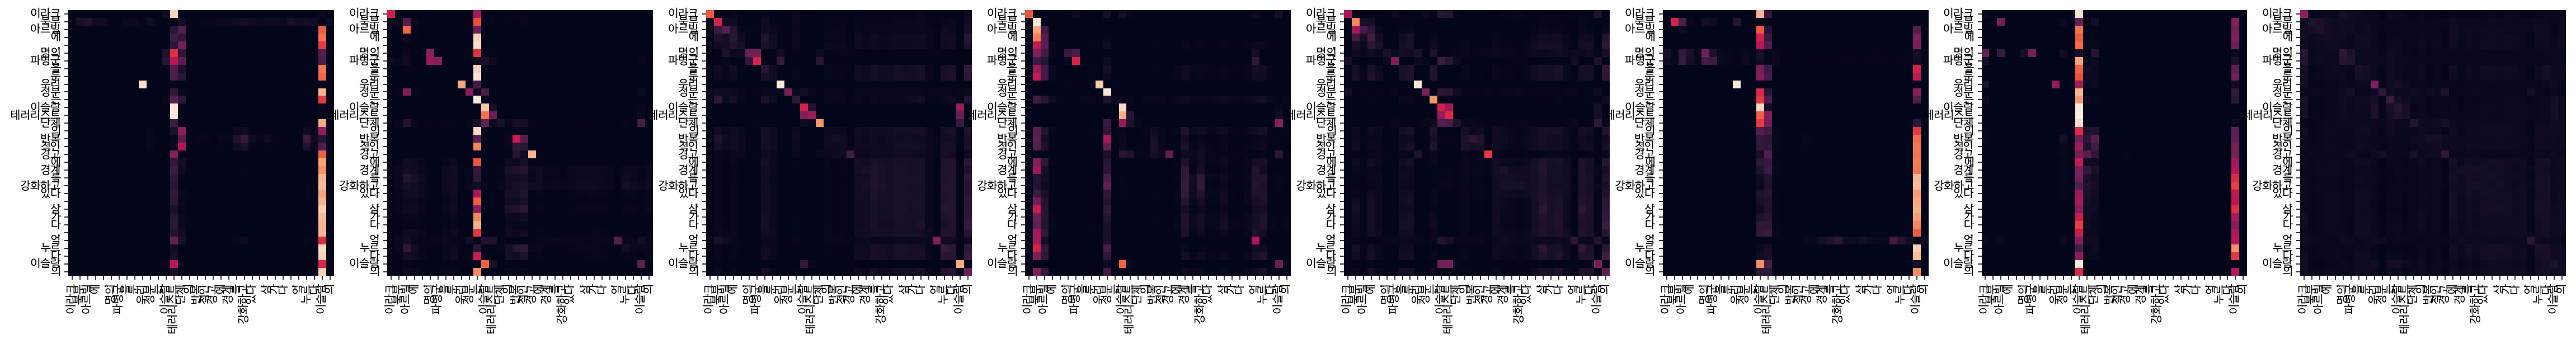

Encoder Layer 4


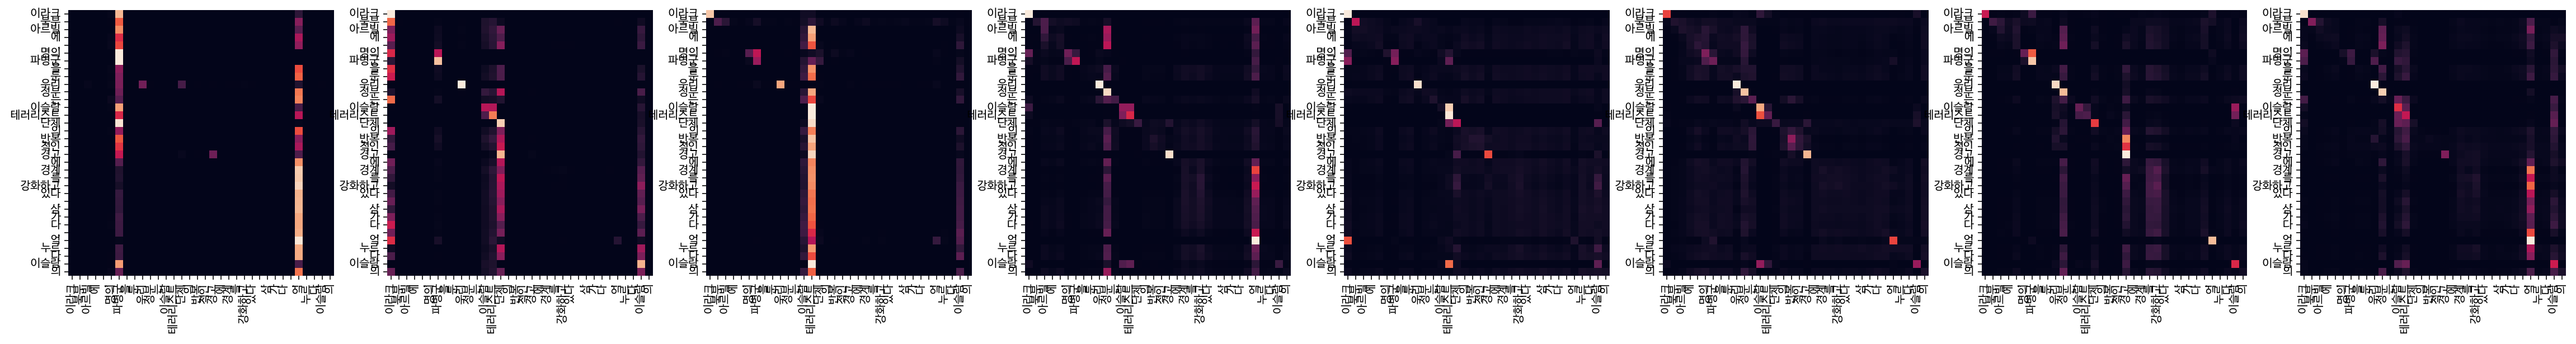

Encoder Layer 5


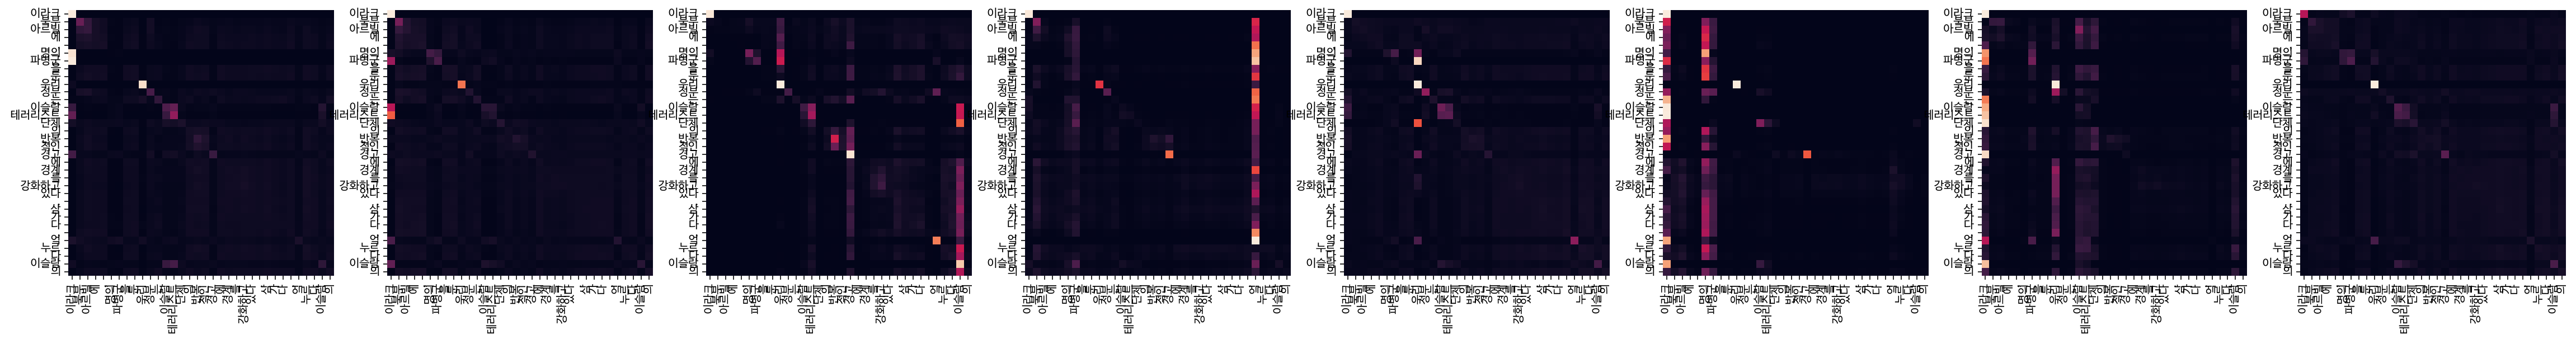

Encoder Layer 6


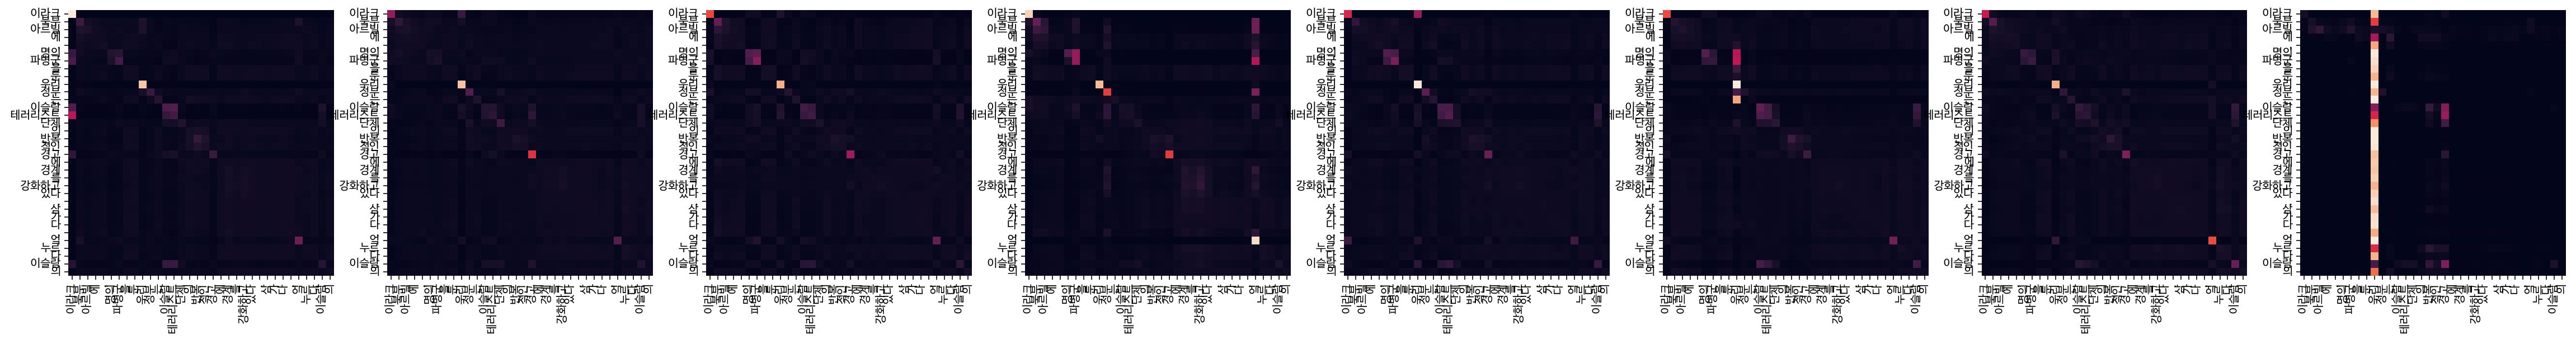

Decoder Self Layer 1


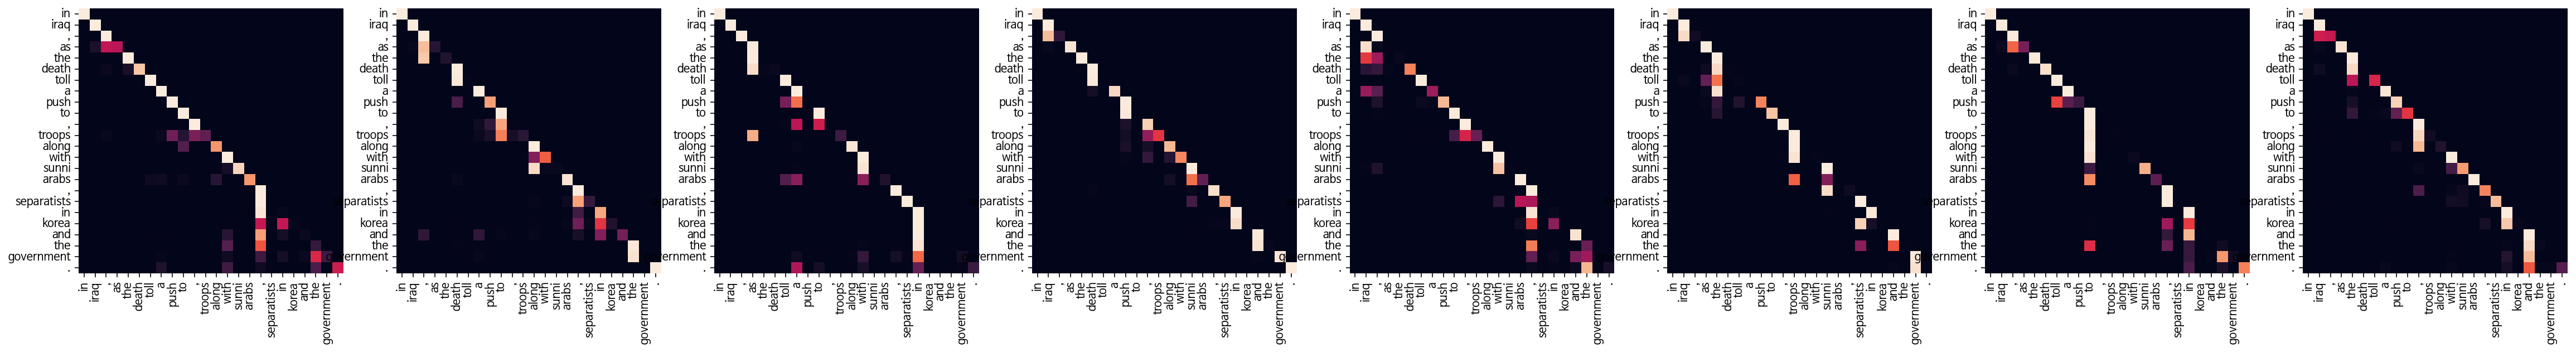

Decoder Src Layer 1


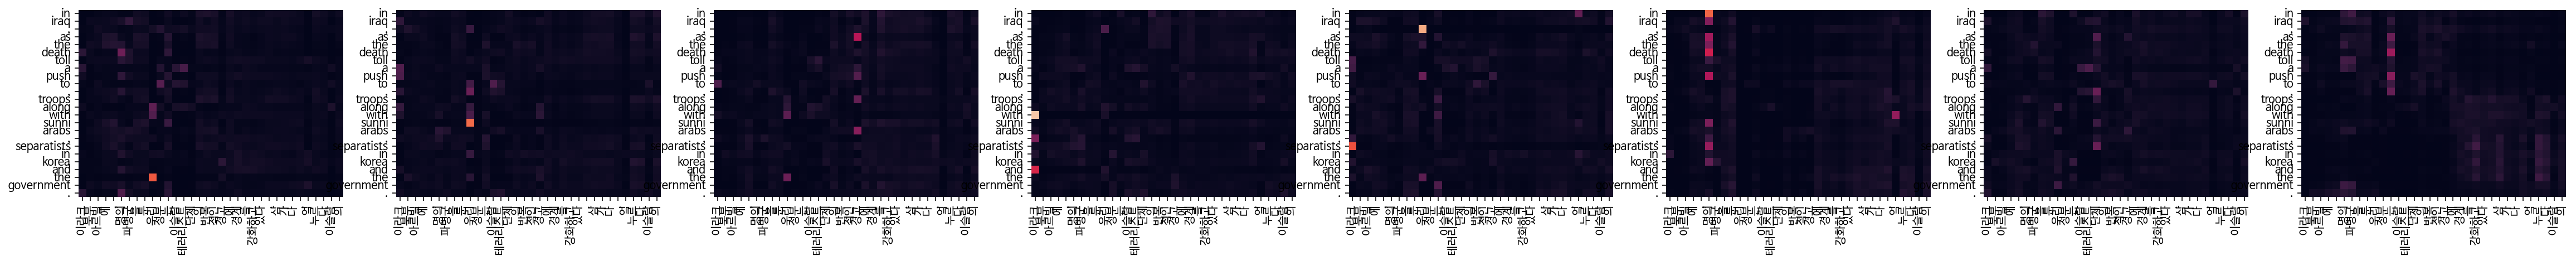

Decoder Self Layer 2


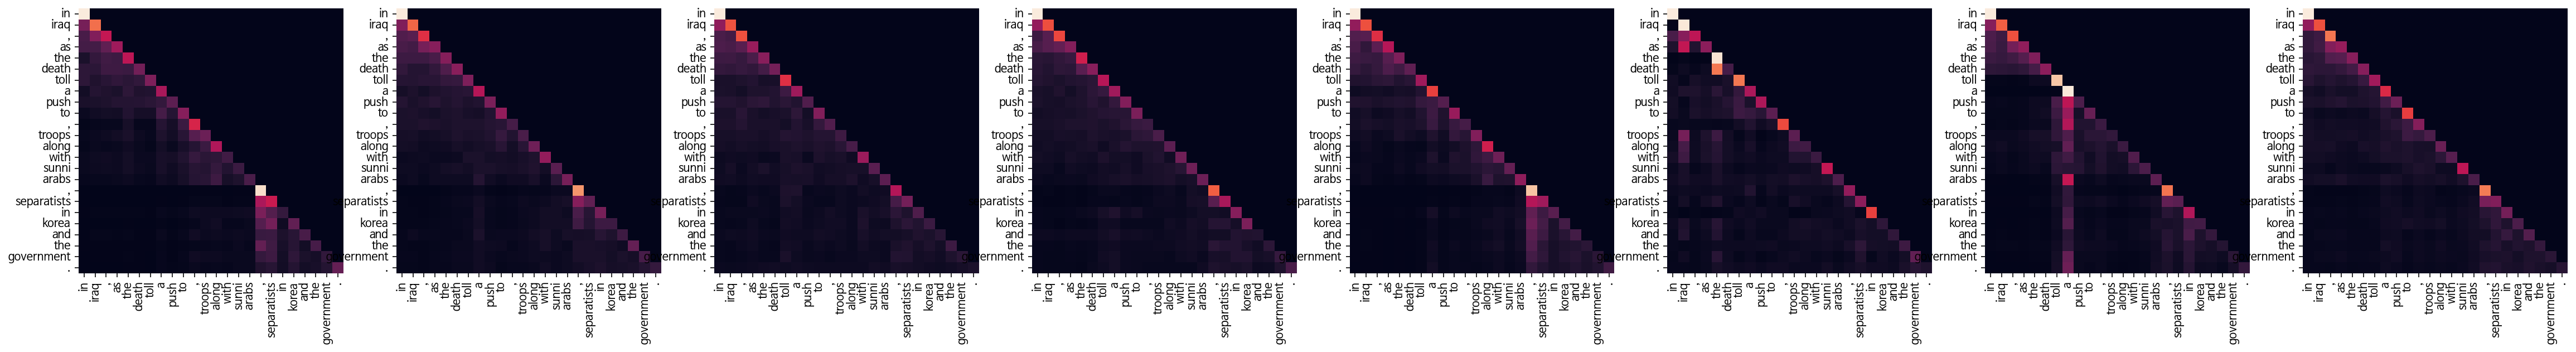

Decoder Src Layer 2


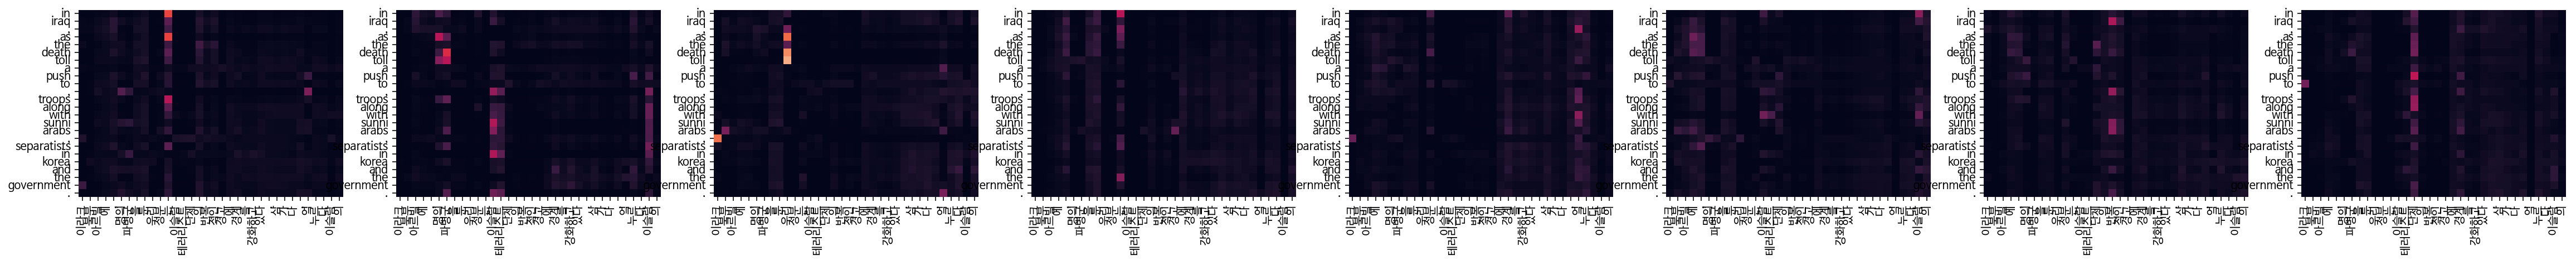

Decoder Self Layer 3


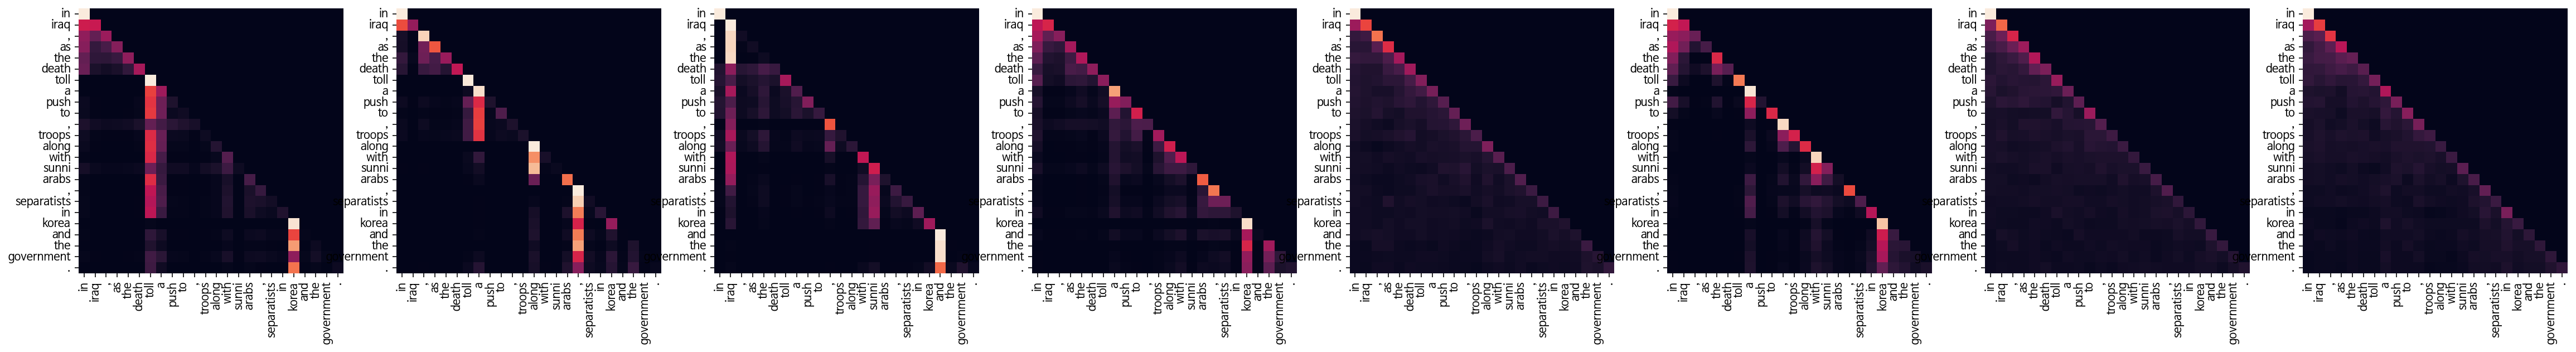

Decoder Src Layer 3


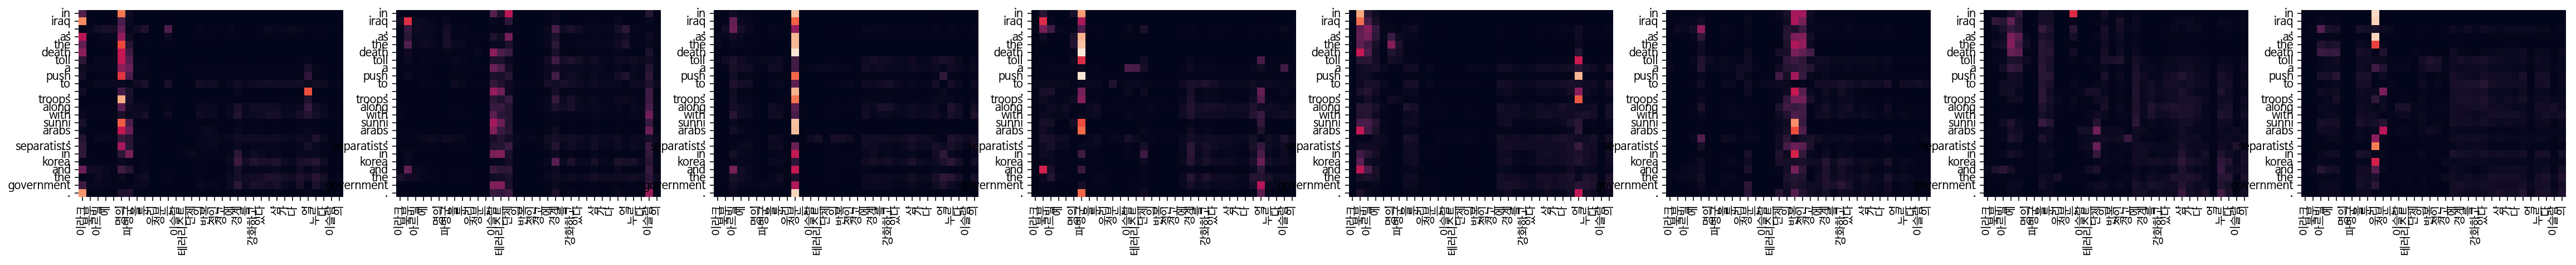

Decoder Self Layer 4


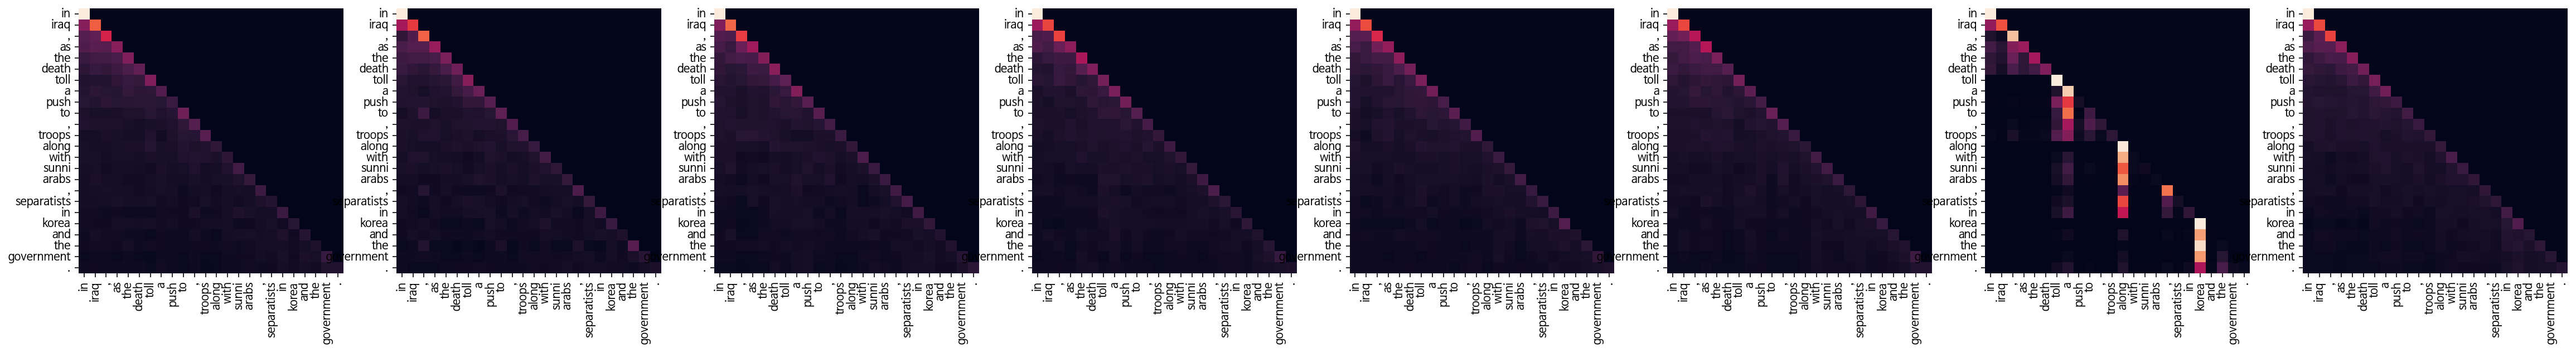

Decoder Src Layer 4


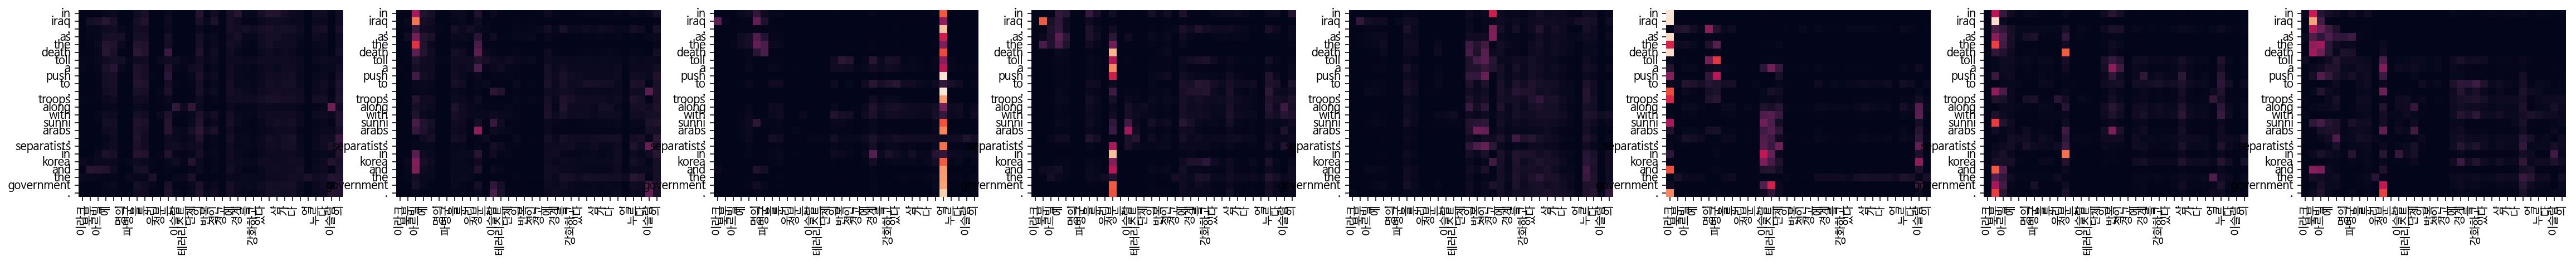

Decoder Self Layer 5


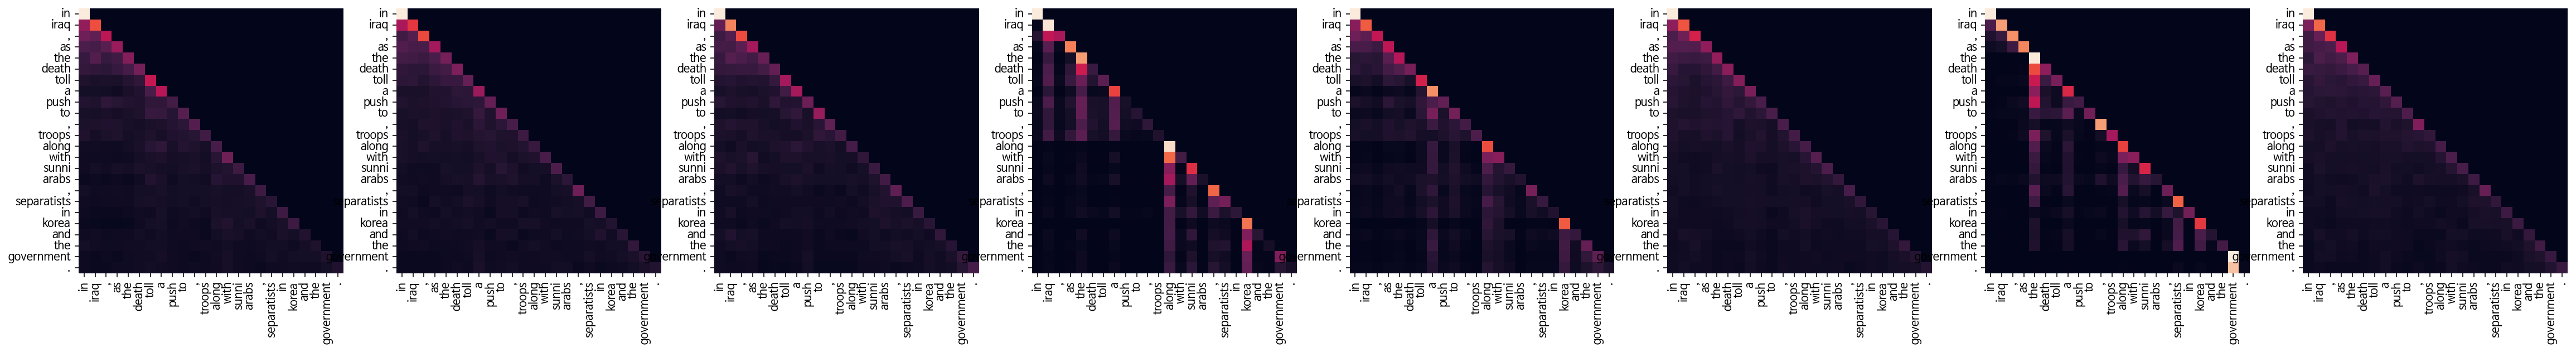

Decoder Src Layer 5


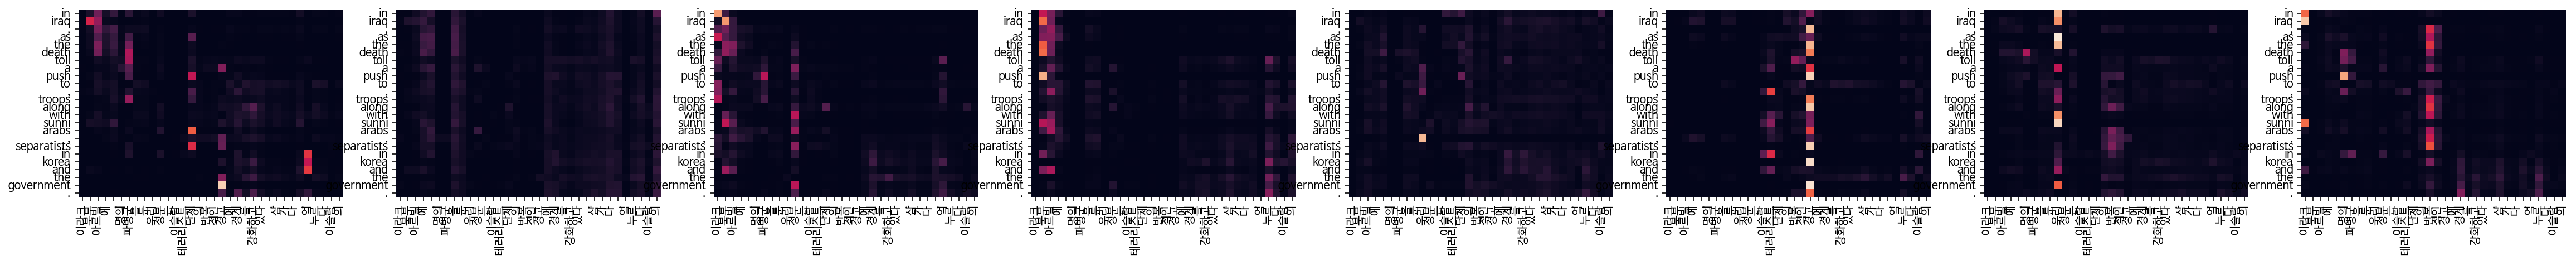

Decoder Self Layer 6


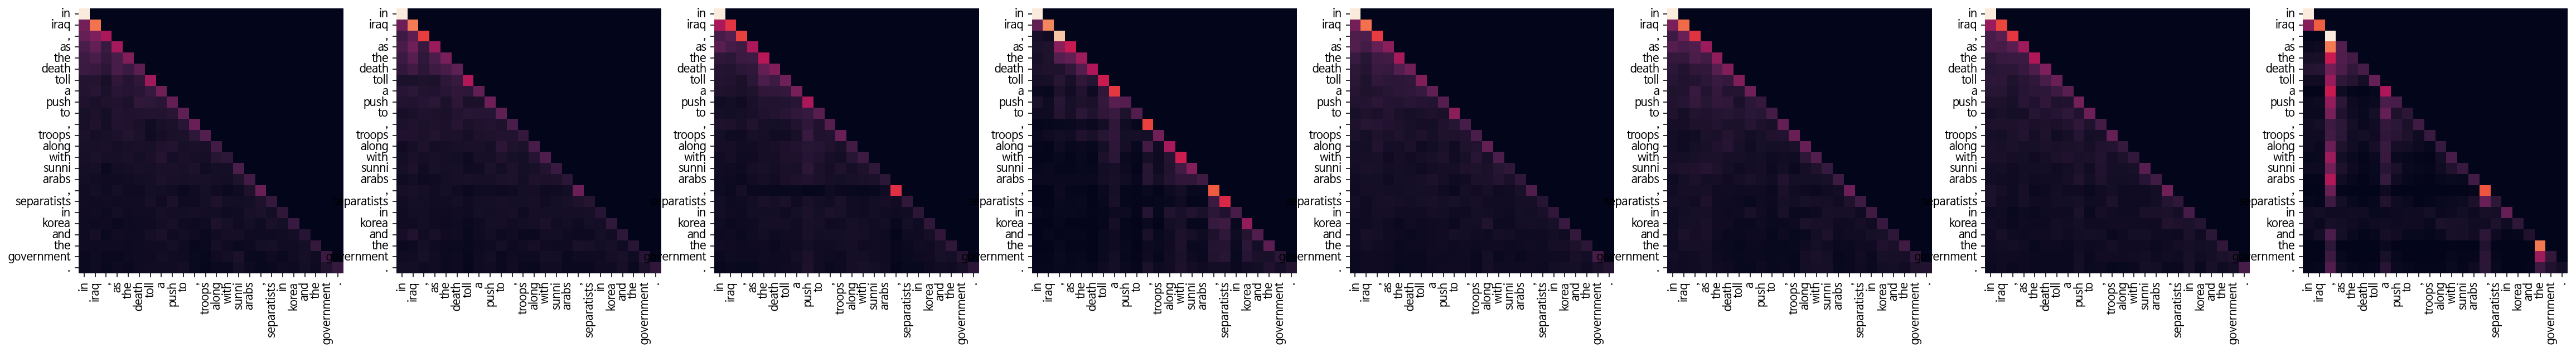

Decoder Src Layer 6


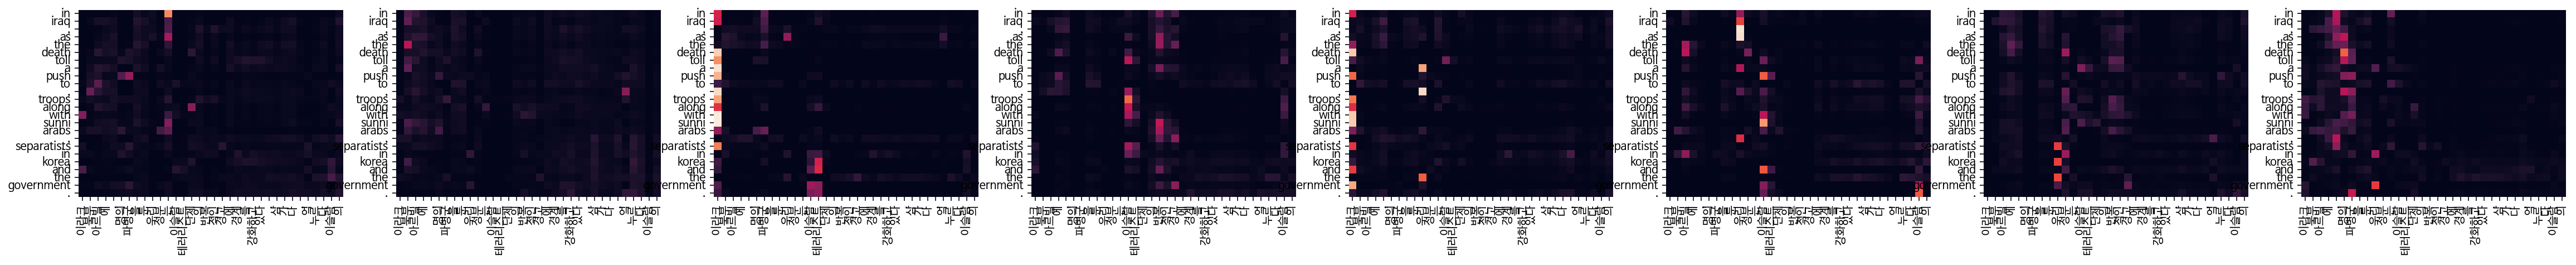

In [225]:
translate(enc_corpus[2][:], transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

In [226]:
dec_corpus[2][:-2]

'with about , combat troops in the northern iraqi town of irbil , south korea has been put on high alert due to repeated warnings from islamic terrorist groups'